In [1]:
print('test')

test


In [2]:
import torch
torch.cuda.get_device_name(0)

c:\Users\yeara\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 4090'

# Package Impoting

In [3]:
# Import necessary packages
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from sklearn.metrics import accuracy_score

import transformers
from transformers import BertTokenizer, BertModel, BertForQuestionAnswering, AutoModel
from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import default_data_collator, get_scheduler
from accelerate import Accelerator
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, AdamW, get_scheduler
from transformers import PreTrainedModel, AutoModelForQuestionAnswering, AutoConfig
from transformers.modeling_outputs import QuestionAnsweringModelOutput

import torch
from torch.optim import AdamW
import torch.nn as nn  # Neural networks
import torch.optim as optim  # Optimizers
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

from datasets import load_dataset

import random
from accelerate import Accelerator
import collections
import evaluate
import json

In [4]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

import pickle

from transformers import pipeline

# Functions

In [5]:
def compute_lacc(predictions, references):
    correct_start = 0
    correct_end = 0
    total = 0

    for pred, ref in zip(predictions, references):
        pred_start = pred['prediction_start']
        pred_end = pred['prediction_end']
        ref_start = ref['answers'][0]['answer_start']
        ref_end = ref['answers'][0]['answer_start'] + len(ref['answers'][0]['text'])

        if pred_start == ref_start:
            correct_start += 1
        if pred_end == ref_end:
            correct_end += 1
        total += 1

    lacc = (correct_start + correct_end) / (2 * total)
    return lacc

def compute_sacc(predictions, references):
    correct_sequences = 0
    total = 0

    for pred, ref in zip(predictions, references):
        pred_text = pred['prediction_text']
        ref_text = ref['answers'][0]['text']

        if pred_text == ref_text:
            correct_sequences += 1
        total += 1

    sacc = correct_sequences / total
    return sacc


In [6]:
# def lcs(X, Y):  
#   m = len(X)
#   n = len(Y)
#   L = [[0] * (n + 1) for _ in range(m + 1)]
  
#   for i in range(m + 1):
#     for j in range(n + 1):
#       if i == 0 or j == 0:
#         L[i][j] = 0
#       elif X[i - 1] == Y[j - 1]:
#         L[i][j] = L[i - 1][j - 1] + 1
#       else:   

#         L[i][j] = max(L[i - 1][j], L[i][j - 1])
  
#   return L[m][n]

# def lacc(predictions, references):
#   lacc_scores = []
#   for pred, ref in zip(predictions, references):
#     lacc_score = lcs(pred, ref) / len(ref)
#     lacc_scores.append(lacc_score)
  
#   return np.mean(lacc_scores)

# def sacc(predictions, references):
#   sacc_scores = []
#   for pred, ref in zip(predictions, references):
#     sacc_score = int(pred == ref)
#     sacc_scores.append(sacc_score)
  
#   return np.mean(sacc_scores)

In [7]:
def compute_mrr(predictions, references):
    reciprocal_ranks = []
    for pred, ref in zip(predictions, references):
        if ref["answers"]:
            correct_answers = [a["text"] for a in ref["answers"]]
            try:
                rank = next(i + 1 for i, p in enumerate(pred["prediction_text"]) if p in correct_answers)
                reciprocal_ranks.append(1.0 / rank)
            except StopIteration:
                reciprocal_ranks.append(0.0)
    return np.mean(reciprocal_ranks)

In [8]:
def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in examples:
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                        "prediction_start": offsets[start_index][0],
                        "prediction_end": offsets[end_index][1],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"],
                 "prediction_start": best_answer["prediction_start"], "prediction_end": best_answer["prediction_end"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": "", "prediction_start": -1, "prediction_end": -1})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    metrics = metric.compute(predictions=[{"id": p["id"], "prediction_text": p["prediction_text"]} for p in predicted_answers],
                             references=theoretical_answers)

    # Calculate Lacc and Sacc
    metrics['mrr'] = compute_mrr(predicted_answers, theoretical_answers)
    metrics['lacc'] = compute_lacc(predicted_answers, theoretical_answers)
    metrics['sacc'] = compute_sacc(predicted_answers, theoretical_answers)

    return metrics

# Model Checkpoint

In [9]:
# # from transformers import AutoTokenizer
# # from transformers import AutoModelForQuestionAnswering

# model_checkpoint = "dmis-lab/biobert-v1.1"
# # model_checkpoint = "michiyasunaga/BioLinkBERT-base"
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# # model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
# # model_base = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [10]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
# model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

c:\Users\yeara\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Data Load & Split

In [11]:

# from sklearn.model_selection import train_test_split
# from datasets import Dataset

# 1
# Load your JSON data
with open('Copy of BioASQ_trainingdata_9b.json', 'r') as f:
    data = json.load(f)

# Flatten the JSON structure and extract the required features
processed_data = []
for item in data['data']:
    for paragraph in item['paragraphs']:
        for qa in paragraph['qas']:
            processed_data.append({
                'id': qa['id'],
                'question': qa['question'],
                'answers': qa['answers'],
                'context': paragraph['context']
            })

# Splitting the processed data into train and test sets
train_data, val_data = train_test_split(processed_data, test_size=0.2, random_state=42)

# Create Dataset objects for train and test sets
raw_train_dataset = Dataset.from_dict({'id': [item['id'] for item in train_data],
                                   'question': [item['question'] for item in train_data],
                                   'answers': [item['answers'] for item in train_data],
                                   'context': [item['context'] for item in train_data]})

raw_val_dataset = Dataset.from_dict({'id': [item['id'] for item in val_data],
                                  'question': [item['question'] for item in val_data],
                                  'answers': [item['answers'] for item in val_data],
                                  'context': [item['context'] for item in val_data]})

# Print information about the train and test datasets
print("Train Dataset:")
print(raw_train_dataset)
print("\nTest Dataset:")
print(raw_val_dataset)


Train Dataset:
Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 4357
})

Test Dataset:
Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 1090
})


In [12]:
raw_train_dataset.filter(lambda x: len(x["answers"][0]["text"]) != 1)
raw_val_dataset.filter(lambda x: len(x["answers"][0]["text"]) != 1)

Filter: 100%|██████████| 1090/1090 [00:00<00:00, 128140.35 examples/s]


Dataset({
    features: ['id', 'question', 'answers', 'context'],
    num_rows: 1084
})

# Data Pre-processing

In [13]:
max_length = 512
stride = 256


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx][0]
        start_char = answer["answer_start"]
        end_char = answer["answer_start"] + len(answer["text"])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [14]:
train_dataset = raw_train_dataset.map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_train_dataset.column_names,
)
len(raw_train_dataset), len(train_dataset)

Map: 100%|██████████| 4357/4357 [00:00<00:00, 5456.21 examples/s]


(4357, 4357)

In [15]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [16]:
validation_dataset = raw_val_dataset.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_val_dataset.column_names,
)
len(raw_val_dataset), len(validation_dataset)

Map: 100%|██████████| 1090/1090 [00:00<00:00, 4515.34 examples/s]


(1090, 1090)

In [17]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 1090
})

# Training Loop

In [18]:
# import random

def bootstrap_sampling(data, n_samples):
    return [random.choices(data, k=len(data)) for _ in range(n_samples)]

# Example usage
bootstrap_samples = bootstrap_sampling(train_dataset, n_samples=10)


In [19]:
# import pickle

# # Load the bootstrap samples from the local file
# with open('C:\\Users\\beqa\\MEHEDI\\Final Notebook\\boostrap_samples\\bootstrap_samples.pkl', 'rb') as f:
#     bootstrap_samples = pickle.load(f)

# print("Bootstrap samples loaded from 'bootstrap_samples.pkl'")

In [20]:
pwd

'c:\\Users\\yeara\\OneDrive\\Desktop\\bio-bert'

In [21]:
# import pickle

# 2
# Save the bootstrap samples to a local file
with open('c:\\Users\\yeara\\OneDrive\\Desktop\\bio-bert\\boostrap_samples\\bootstrap_samples.pkl', 'wb') as f:
    pickle.dump(bootstrap_samples, f)

print("Bootstrap samples saved to 'bootstrap_samples.pkl'")

Bootstrap samples saved to 'bootstrap_samples.pkl'


In [22]:
# from torch.utils.data import DataLoader
# from transformers import default_data_collator


validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
validation_set.set_format("torch")


eval_dataloader = DataLoader(
    validation_set, collate_fn=default_data_collator, batch_size=8
)

In [23]:
n_best = 20
max_answer_length = 30

In [24]:
# import evaluate

metric = evaluate.load("squad")

In [25]:
# Mock functions for dataset format and metric computation (replace with actual implementations)
def set_format(dataset, format_type):
    if format_type == "torch":
        for example in dataset:
            for key in example:
                example[key] = torch.tensor(example[key])
    return dataset

In [26]:
# Custom dataset class to handle list of dictionaries
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            batch = {key: [] for key in self.data_list[0].keys()}
            for i in idx:
                for key, value in self.data_list[i].items():
                    batch[key].append(value)
            return {key: torch.stack(value) for key, value in batch.items()}
        return self.data_list[idx]

In [27]:
# Custom collate function
def custom_collate_fn(batch):
    return default_data_collator(batch)

In [28]:
def compute_statistics(scores):
    return {
        'highest': np.max(scores),
        'lowest': np.min(scores),
        'average': np.mean(scores)
    }


# NER_Bag

In [29]:
# import matplotlib.pyplot as plt

# 3
def visualize_performance(metrics, train_losses, mrr_scores, num_train_epochs, save_path='performance_graph'):
    epochs = range(1, num_train_epochs + 1)

    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Line graphs for training loss and MRR
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, mrr_scores, label='MRR', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('MRR')
    plt.title('MRR Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_loss_mrr.png'), dpi=300)
    plt.show()

    # Bar charts for F1, EM, SACC, LACC
    metric_names = ['F1', 'EM', 'SACC', 'LACC']
    metrics_scores = [metrics['f1'], metrics['exact_match'], metrics['sacc'], metrics['lacc']]

    plt.figure(figsize=(12, 10))
    for i, (metric, scores) in enumerate(zip(metric_names, metrics_scores)):
        plt.subplot(2, 2, i + 1)
        plt.bar(epochs, scores, label=metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} Over Epochs')
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'metrics_over_epochs.png'), dpi=300)
    plt.show()


In [30]:
def train_and_save_model(train_dataset, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, model_idx, num_train_epochs):
    model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
    # 4
    ner_model = BertForQuestionAnswering.from_pretrained('biobert_model_ner')
    model.bert = ner_model.bert
    # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    train_dataset = set_format(train_dataset, "torch")
    train_dataset = CustomDataset(train_dataset)
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=custom_collate_fn,
        batch_size=8,
    )

    validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
    validation_set.set_format("torch")

    eval_dataloader = DataLoader(
        validation_set, collate_fn=custom_collate_fn, batch_size=8
    )

    optimizer = AdamW(model.parameters(), lr=2e-5)
    accelerator = Accelerator()
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_train_epochs * num_update_steps_per_epoch

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Assuming these lists exist to hold metrics for each epoch
    train_losses = []
    em_scores = []
    f1_scores = []
    mrr_scores = []
    lacc_scores = []
    sacc_scores = []

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_train_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        average_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Evaluation
        model.eval()
        start_logits = []
        end_logits = []
        total_val_loss = 0
        accelerator.print("Evaluation!")
        for batch in tqdm(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)

            start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
            end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

        start_logits = np.concatenate(start_logits)
        end_logits = np.concatenate(end_logits)
        start_logits = start_logits[: len(validation_dataset)]
        end_logits = end_logits[: len(validation_dataset)]

        metrics = compute_metrics(
            start_logits, end_logits, validation_dataset, raw_val_dataset
        )

        em_scores.append(metrics['exact_match'])
        f1_scores.append(metrics['f1'])
        mrr_scores.append(metrics['mrr'])
        lacc_scores.append(metrics['lacc'])
        sacc_scores.append(metrics['sacc'])

        print(f"Epoch {epoch} Metrics:")
        print(f"Training Loss: {average_train_loss}")
        print(f"EM: {metrics['exact_match']}")
        print(f"F1: {metrics['f1']}")
        print(f"MRR: {metrics['mrr']}")
        print(f"Lacc: {metrics['lacc']}")
        print(f"Sacc: {metrics['sacc']}")

    metrics_statistics = {
        'EM': compute_statistics(em_scores),
        'F1': compute_statistics(f1_scores),
        'MRR': compute_statistics(mrr_scores),
        'Lacc': compute_statistics(lacc_scores),
        'Sacc': compute_statistics(sacc_scores),
    }

    for metric, stats in metrics_statistics.items():
        print(f"{metric} - Highest: {stats['highest']}, Lowest: {stats['lowest']}, Average: {stats['average']}")

    visualize_performance({
        'exact_match': em_scores,
        'f1': f1_scores,
        'mrr': mrr_scores,
        'lacc': lacc_scores,
        'sacc': sacc_scores
    }, train_losses, mrr_scores, num_train_epochs)

    model_save_path = os.path.join(save_dir, f"model_{model_idx}")
    model.save_pretrained(model_save_path)
    if model_idx == 0:  # Save the tokenizer only once
        tokenizer.save_pretrained(save_dir)

In [31]:
pwd

'c:\\Users\\yeara\\OneDrive\\Desktop\\bio-bert'

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:07<10:02,  8.14it/s]

Evaluation!


 10%|█         | 546/5450 [01:14<2:13:28,  1.63s/it]

Epoch 0 Metrics:
Training Loss: 1.1972364332971224
EM: 82.11009174311927
F1: 87.68985104909775
MRR: 0.0012996941896024465
Lacc: 0.7642201834862385
Sacc: 0.781651376146789


 20%|█▉        | 1089/5450 [02:20<08:52,  8.19it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:27<1:58:49,  1.64s/it]

Epoch 1 Metrics:
Training Loss: 0.38066694646082616
EM: 85.3211009174312
F1: 89.68068686945608
MRR: 0.005504587155963303
Lacc: 0.773394495412844
Sacc: 0.8146788990825689


 30%|██▉       | 1634/5450 [03:34<07:58,  7.98it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:41<1:42:38,  1.61s/it]

Epoch 2 Metrics:
Training Loss: 0.258712327866516
EM: 84.95412844036697
F1: 89.6917443866994
MRR: 0.0012996941896024465
Lacc: 0.7573394495412844
Sacc: 0.8119266055045872


 40%|███▉      | 2179/5450 [04:48<06:38,  8.22it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:54<1:29:03,  1.63s/it]

Epoch 3 Metrics:
Training Loss: 0.21925190211222464
EM: 85.96330275229357
F1: 90.13873146426836
MRR: 0.002981651376146789
Lacc: 0.7610091743119266
Sacc: 0.8211009174311926


 50%|████▉     | 2724/5450 [06:00<05:35,  8.12it/s]  

Evaluation!


 50%|█████     | 2726/5450 [06:07<1:14:22,  1.64s/it]

Epoch 4 Metrics:
Training Loss: 0.1912585201015303
EM: 85.59633027522936
F1: 89.59743682657539
MRR: 0.0012996941896024465
Lacc: 0.7527522935779817
Sacc: 0.8165137614678899


 60%|█████▉    | 3269/5450 [07:13<04:14,  8.56it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:20<56:54,  1.57s/it]

Epoch 5 Metrics:
Training Loss: 0.17687885399647227
EM: 85.22935779816514
F1: 89.12909159094511
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8155963302752294


 70%|██████▉   | 3814/5450 [08:24<03:10,  8.59it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:30<42:56,  1.58s/it]

Epoch 6 Metrics:
Training Loss: 0.16357374834900704
EM: 85.87155963302752
F1: 89.81186653966769
MRR: 0.0012996941896024465
Lacc: 0.7555045871559632
Sacc: 0.8211009174311926


 80%|███████▉  | 4359/5450 [09:34<02:08,  8.51it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.99it/s]


Epoch 7 Metrics:
Training Loss: 0.15598020222323195
EM: 85.41284403669725
F1: 89.48831863287637
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8165137614678899


 90%|████████▉ | 4904/5450 [10:45<01:05,  8.29it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:52<14:14,  1.57s/it]

Epoch 8 Metrics:
Training Loss: 0.1487565089448103
EM: 86.5137614678899
F1: 90.41929667623972
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8238532110091743


100%|█████████▉| 5449/5450 [11:56<00:00,  8.45it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.14it/s]


Epoch 9 Metrics:
Training Loss: 0.1411351679061185
EM: 86.3302752293578
F1: 90.3285220074834
MRR: 0.0012996941896024465
Lacc: 0.7504587155963303
Sacc: 0.8220183486238533
EM - Highest: 86.5137614678899, Lowest: 82.11009174311927, Average: 85.3302752293578
F1 - Highest: 90.41929667623972, Lowest: 87.68985104909775, Average: 89.59755460433094
MRR - Highest: 0.005504587155963303, Lowest: 0.0012996941896024465, Average: 0.0018883792048929662
Lacc - Highest: 0.773394495412844, Lowest: 0.7458715596330275, Average: 0.7558256880733945
Sacc - Highest: 0.8238532110091743, Lowest: 0.781651376146789, Average: 0.8144954128440368


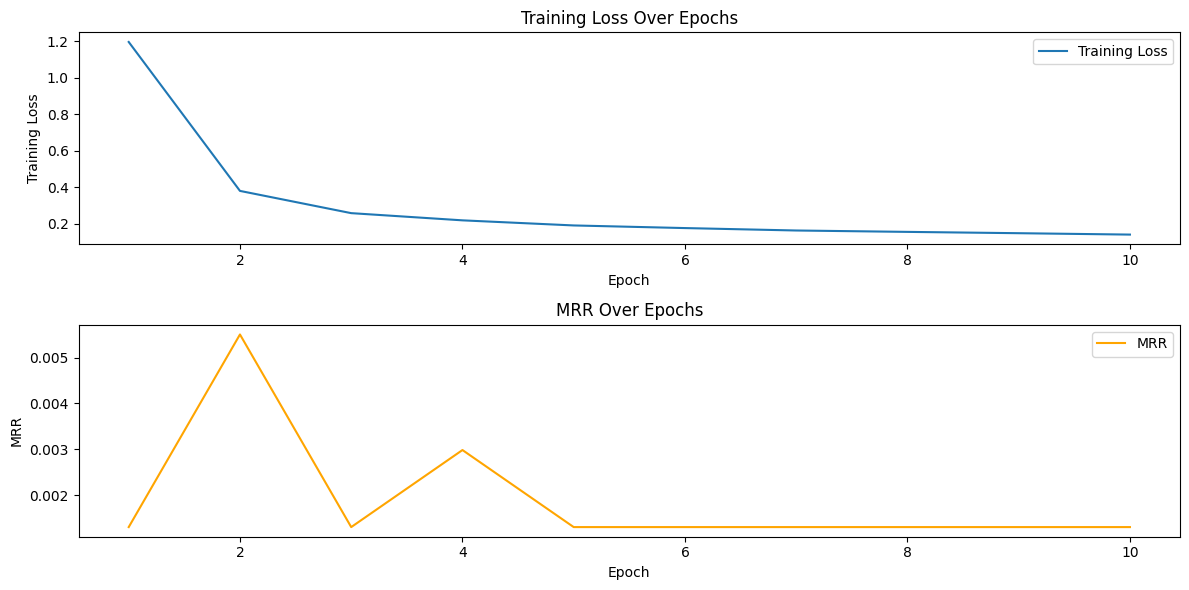

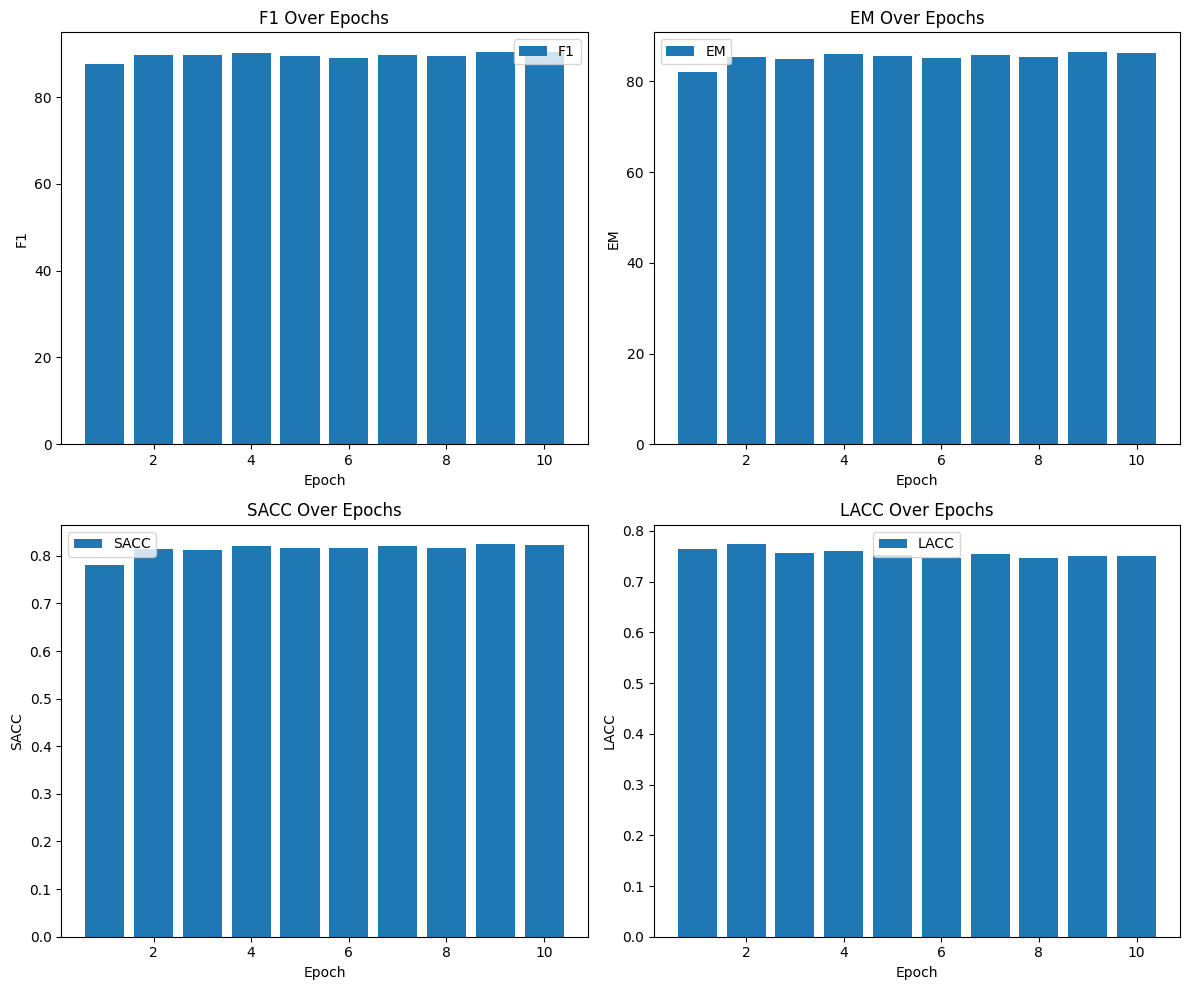

100%|██████████| 5450/5450 [12:04<00:00,  7.53it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:32,  8.57it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:07:03,  1.55s/it]

Epoch 0 Metrics:
Training Loss: 1.2529005114091645
EM: 82.20183486238533
F1: 87.80730393621134
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.7834862385321101


 20%|█▉        | 1089/5450 [02:14<08:30,  8.54it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:20<1:53:22,  1.56s/it]

Epoch 1 Metrics:
Training Loss: 0.36813169426259096
EM: 84.4954128440367
F1: 88.27271965524142
MRR: 0.005504587155963303
Lacc: 0.7605504587155963
Sacc: 0.8027522935779816


 30%|██▉       | 1634/5450 [03:24<07:30,  8.47it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.98it/s]


Epoch 2 Metrics:
Training Loss: 0.25438848553661153
EM: 86.3302752293578
F1: 90.04928795803849
MRR: 0.0012996941896024465
Lacc: 0.7568807339449541
Sacc: 0.8137614678899082


 40%|███▉      | 2179/5450 [04:35<06:31,  8.36it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:41<1:25:45,  1.57s/it]

Epoch 3 Metrics:
Training Loss: 0.21116885261657142
EM: 85.3211009174312
F1: 89.30902710228922
MRR: 0.0012996941896024465
Lacc: 0.7545871559633027
Sacc: 0.8018348623853211


 50%|████▉     | 2724/5450 [05:45<05:20,  8.51it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:11:55,  1.58s/it]

Epoch 4 Metrics:
Training Loss: 0.1867868096594391
EM: 86.23853211009174
F1: 89.44139556418206
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8146788990825689


 60%|█████▉    | 3269/5450 [06:56<04:15,  8.55it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.12it/s]


Epoch 5 Metrics:
Training Loss: 0.16973807124641016
EM: 84.86238532110092
F1: 88.61617022000976
MRR: 0.0012996941896024465
Lacc: 0.7412844036697248
Sacc: 0.7990825688073394


 70%|██████▉   | 3814/5450 [08:06<03:10,  8.59it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.97it/s]


Epoch 6 Metrics:
Training Loss: 0.1528813175994309
EM: 84.95412844036697
F1: 88.69800145766939
MRR: 0.0012996941896024465
Lacc: 0.7399082568807339
Sacc: 0.7972477064220184


 80%|███████▉  | 4359/5450 [09:16<02:09,  8.42it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:23<28:41,  1.58s/it]

Epoch 7 Metrics:
Training Loss: 0.14733628208392274
EM: 85.77981651376147
F1: 89.43419470317187
MRR: 0.0012996941896024465
Lacc: 0.7399082568807339
Sacc: 0.808256880733945


 90%|████████▉ | 4904/5450 [10:30<01:16,  7.10it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.36it/s]


Epoch 8 Metrics:
Training Loss: 0.13984572599404876
EM: 85.77981651376147
F1: 89.21788603732192
MRR: 0.0012996941896024465
Lacc: 0.7408256880733946
Sacc: 0.810091743119266


100%|█████████▉| 5449/5450 [11:57<00:00,  7.21it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.29it/s]


Epoch 9 Metrics:
Training Loss: 0.13533009710084057
EM: 85.68807339449542
F1: 89.22776606555057
MRR: 0.0012996941896024465
Lacc: 0.7412844036697248
Sacc: 0.810091743119266
EM - Highest: 86.3302752293578, Lowest: 82.20183486238533, Average: 85.16513761467891
F1 - Highest: 90.04928795803849, Lowest: 87.80730393621134, Average: 89.0073752699686
MRR - Highest: 0.005504587155963303, Lowest: 0.0012996941896024465, Average: 0.0017201834862385318
Lacc - Highest: 0.7605504587155963, Lowest: 0.7399082568807339, Average: 0.7472935779816514
Sacc - Highest: 0.8146788990825689, Lowest: 0.7834862385321101, Average: 0.8041284403669724


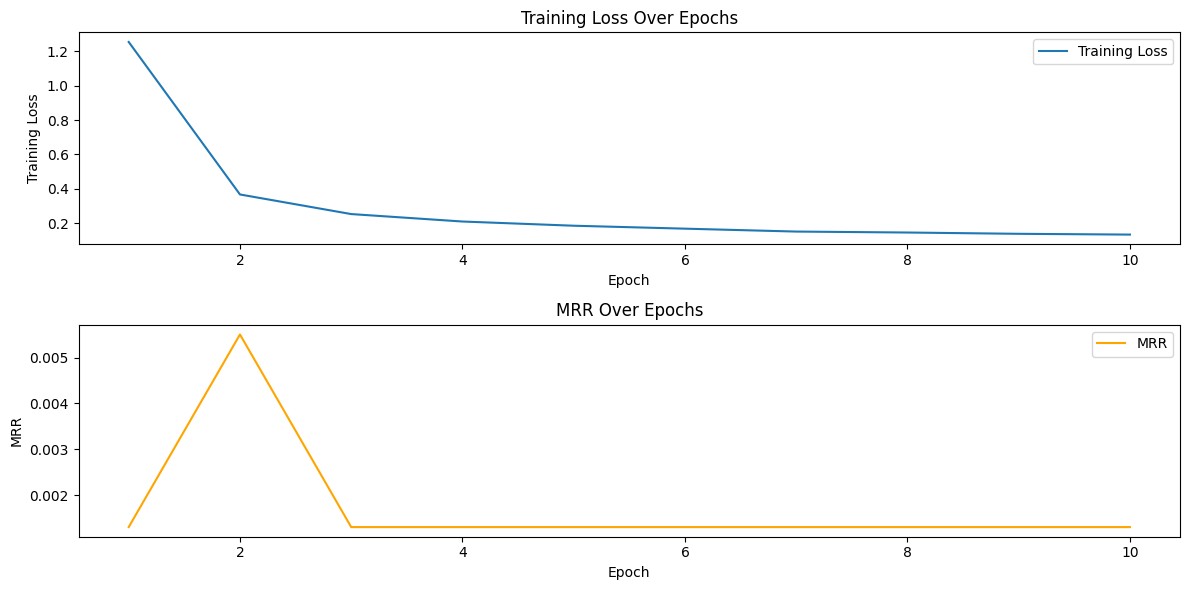

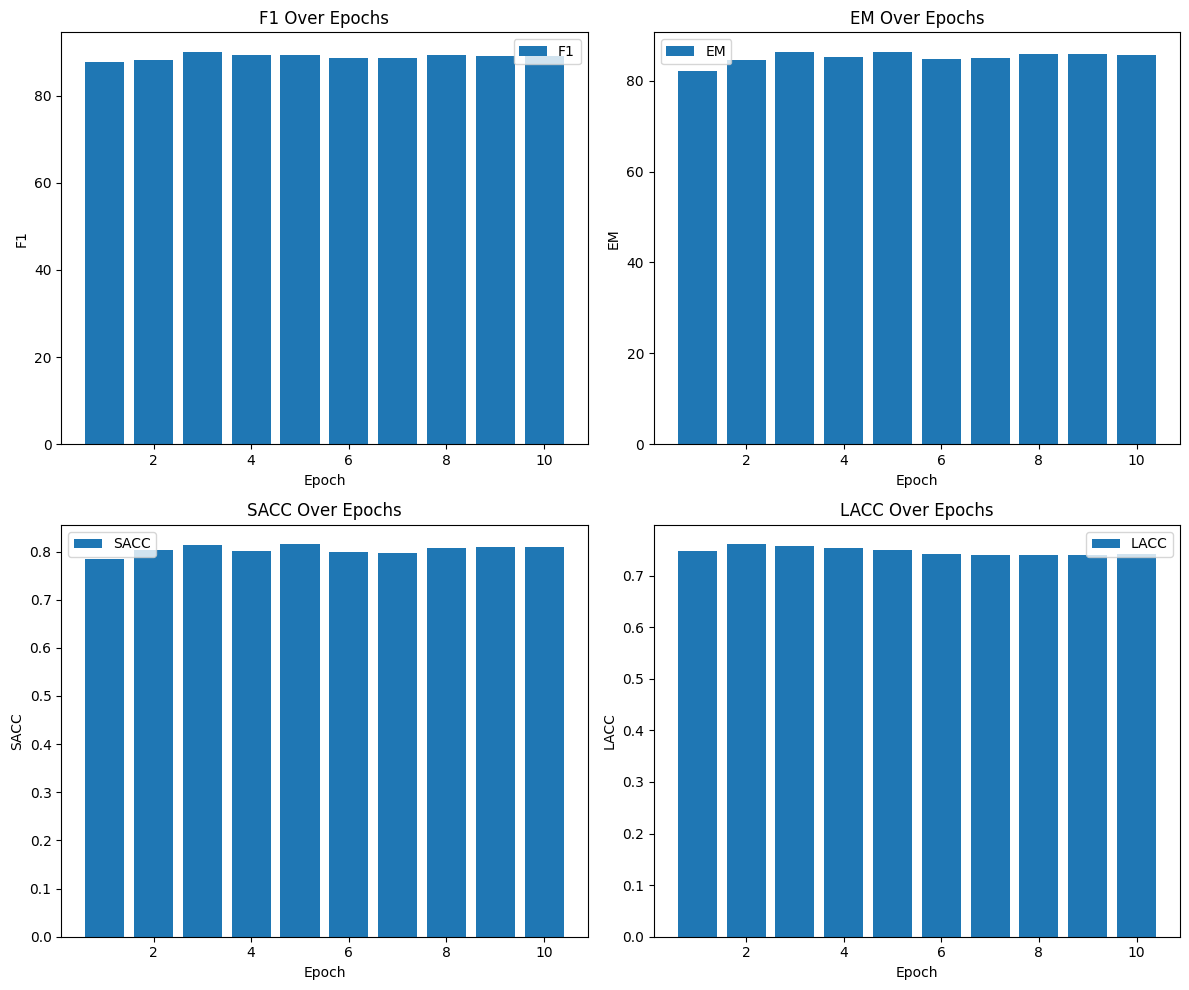

100%|██████████| 5450/5450 [12:10<00:00,  7.47it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:15<11:20,  7.20it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.20it/s]


Epoch 0 Metrics:
Training Loss: 1.2286768550036151
EM: 81.8348623853211
F1: 86.91407910194498
MRR: 0.0038226299694189606
Lacc: 0.7536697247706422
Sacc: 0.771559633027523


 20%|█▉        | 1089/5450 [02:42<09:58,  7.28it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.31it/s]


Epoch 1 Metrics:
Training Loss: 0.3830431149947807
EM: 86.60550458715596
F1: 89.97803065078593
MRR: 0.005504587155963303
Lacc: 0.7697247706422018
Sacc: 0.8238532110091743


 30%|██▉       | 1634/5450 [04:08<09:00,  7.06it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.02it/s]


Epoch 2 Metrics:
Training Loss: 0.2525818309447634
EM: 85.68807339449542
F1: 88.96449284463584
MRR: 0.004663608562691131
Lacc: 0.7596330275229358
Sacc: 0.818348623853211


 40%|███▉      | 2179/5450 [05:36<07:36,  7.17it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.17it/s]


Epoch 3 Metrics:
Training Loss: 0.21826358144256977
EM: 86.69724770642202
F1: 89.96598015217025
MRR: 0.0012996941896024465
Lacc: 0.7660550458715596
Sacc: 0.826605504587156


 50%|████▉     | 2724/5450 [07:05<06:28,  7.01it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.74it/s]


Epoch 4 Metrics:
Training Loss: 0.19318920777653506
EM: 86.5137614678899
F1: 89.49449842777719
MRR: 0.004663608562691131
Lacc: 0.7610091743119266
Sacc: 0.8238532110091743


 60%|█████▉    | 3269/5450 [08:31<04:56,  7.35it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.12it/s]


Epoch 5 Metrics:
Training Loss: 0.17653212604719565
EM: 85.87155963302752
F1: 89.04285541158734
MRR: 0.002981651376146789
Lacc: 0.7582568807339449
Sacc: 0.8165137614678899


 70%|██████▉   | 3814/5450 [09:57<03:49,  7.12it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.31it/s]


Epoch 6 Metrics:
Training Loss: 0.1609511665780409
EM: 86.5137614678899
F1: 89.7989556554102
MRR: 0.002981651376146789
Lacc: 0.7637614678899083
Sacc: 0.8247706422018348


 80%|███████▉  | 4359/5450 [11:24<02:36,  6.99it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.16it/s]


Epoch 7 Metrics:
Training Loss: 0.15269413109422328
EM: 87.06422018348624
F1: 89.92799779214258
MRR: 0.002981651376146789
Lacc: 0.7623853211009174
Sacc: 0.8302752293577982


 90%|████████▉ | 4904/5450 [12:53<01:17,  7.01it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.24it/s]


Epoch 8 Metrics:
Training Loss: 0.14602405566739776
EM: 87.43119266055047
F1: 90.19558189000189
MRR: 0.002981651376146789
Lacc: 0.7646788990825688
Sacc: 0.8339449541284404


100%|██████████| 5450/5450 [14:23<00:00,  7.61it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.02it/s]


Epoch 9 Metrics:
Training Loss: 0.13739562454695362
EM: 86.78899082568807
F1: 89.88882279492654
MRR: 0.002981651376146789
Lacc: 0.7610091743119266
Sacc: 0.8275229357798165
EM - Highest: 87.43119266055047, Lowest: 81.8348623853211, Average: 86.10091743119266
F1 - Highest: 90.19558189000189, Lowest: 86.91407910194498, Average: 89.41712947213827
MRR - Highest: 0.005504587155963303, Lowest: 0.0012996941896024465, Average: 0.003486238532110092
Lacc - Highest: 0.7697247706422018, Lowest: 0.7536697247706422, Average: 0.7620183486238531
Sacc - Highest: 0.8339449541284404, Lowest: 0.771559633027523, Average: 0.8197247706422018


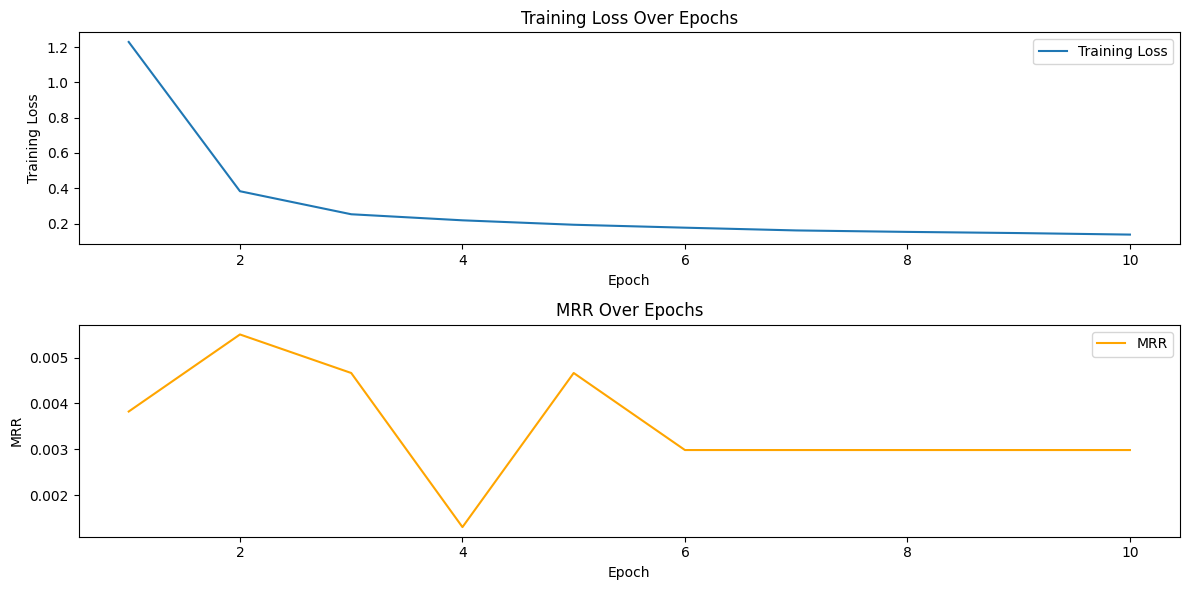

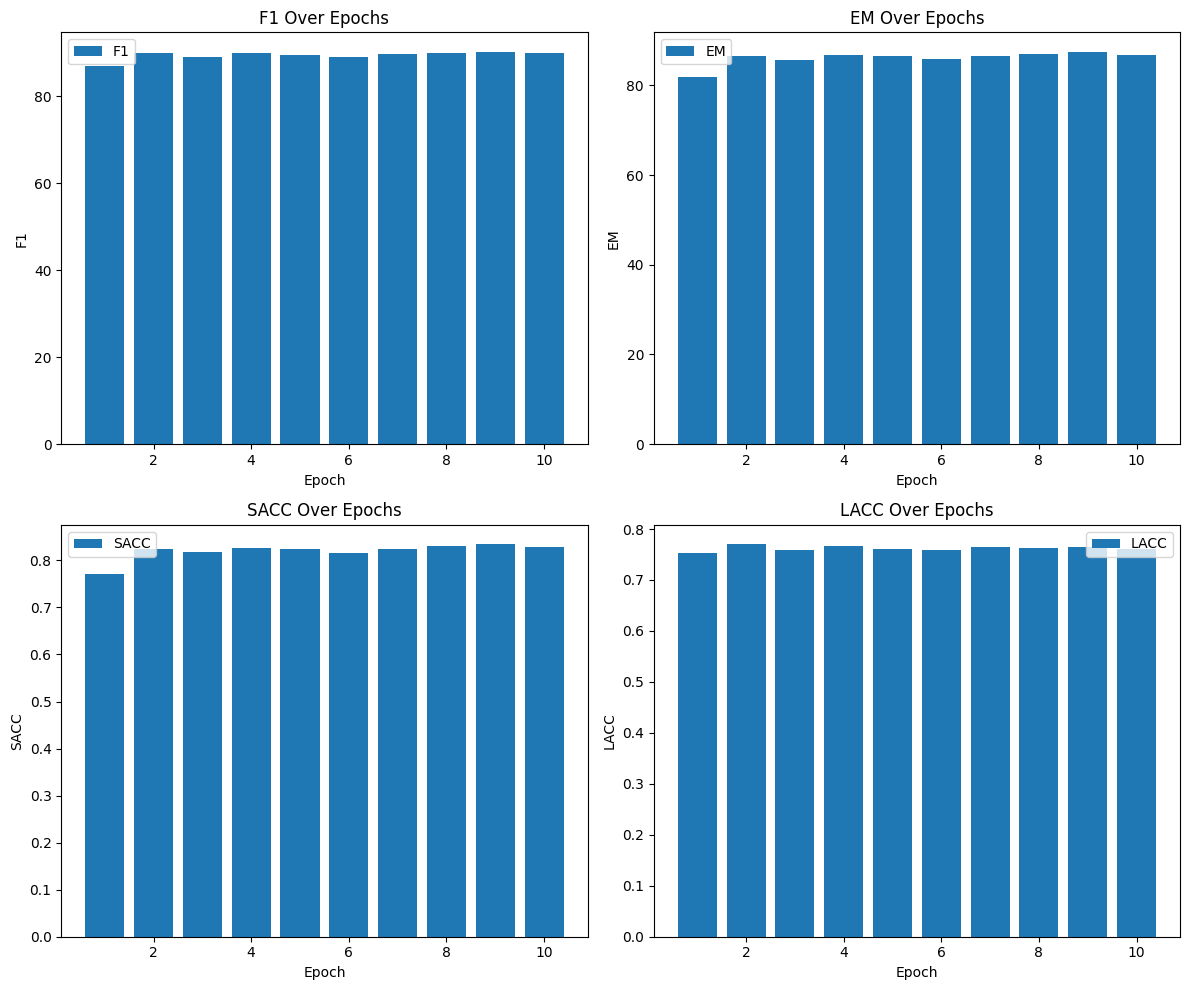

100%|██████████| 5450/5450 [14:37<00:00,  6.21it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:18<11:35,  7.06it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.82it/s]


Epoch 0 Metrics:
Training Loss: 1.180540384817014
EM: 81.55963302752293
F1: 87.33925811228461
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.7788990825688074


 20%|█▉        | 1089/5450 [02:48<10:35,  6.87it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.89it/s]


Epoch 1 Metrics:
Training Loss: 0.3733015521284227
EM: 83.4862385321101
F1: 88.41043470654763
MRR: 0.0012996941896024465
Lacc: 0.7527522935779817
Sacc: 0.8009174311926606


 30%|██▉       | 1634/5450 [04:16<08:49,  7.21it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.29it/s]


Epoch 2 Metrics:
Training Loss: 0.26443384197591846
EM: 85.77981651376147
F1: 90.01979422476762
MRR: 0.0012996941896024465
Lacc: 0.7591743119266054
Sacc: 0.8220183486238533


 40%|███▉      | 2179/5450 [05:41<07:22,  7.39it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.28it/s]


Epoch 3 Metrics:
Training Loss: 0.21065281180284678
EM: 85.96330275229357
F1: 90.3375756717761
MRR: 0.0012996941896024465
Lacc: 0.7614678899082569
Sacc: 0.8220183486238533


 50%|████▉     | 2724/5450 [07:06<06:08,  7.40it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.13it/s]


Epoch 4 Metrics:
Training Loss: 0.1942323806448925
EM: 86.23853211009174
F1: 90.42932592677515
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8247706422018348


 60%|█████▉    | 3269/5450 [08:31<05:00,  7.27it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.21it/s]


Epoch 5 Metrics:
Training Loss: 0.18652698941434812
EM: 86.60550458715596
F1: 90.50630372876503
MRR: 0.0012996941896024465
Lacc: 0.7568807339449541
Sacc: 0.828440366972477


 70%|██████▉   | 3814/5450 [09:56<03:42,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.28it/s]


Epoch 6 Metrics:
Training Loss: 0.16594772970308166
EM: 87.1559633027523
F1: 90.86596375728931
MRR: 0.0012996941896024465
Lacc: 0.7582568807339449
Sacc: 0.8321100917431192


 80%|███████▉  | 4359/5450 [11:21<02:28,  7.32it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.22it/s]


Epoch 7 Metrics:
Training Loss: 0.15695162358679893
EM: 86.97247706422019
F1: 90.82025926010073
MRR: 0.0012996941896024465
Lacc: 0.7573394495412844
Sacc: 0.828440366972477


 90%|████████▉ | 4904/5450 [12:46<01:13,  7.42it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.00it/s]


Epoch 8 Metrics:
Training Loss: 0.14809320834214337
EM: 86.78899082568807
F1: 90.58813644895245
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.826605504587156


100%|█████████▉| 5449/5450 [14:11<00:00,  7.40it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.44it/s]


Epoch 9 Metrics:
Training Loss: 0.14074544280504706
EM: 87.1559633027523
F1: 90.91355855419106
MRR: 0.0012996941896024465
Lacc: 0.7564220183486239
Sacc: 0.8302752293577982
EM - Highest: 87.1559633027523, Lowest: 81.55963302752293, Average: 85.77064220183487
F1 - Highest: 90.91355855419106, Lowest: 87.33925811228461, Average: 90.02306103914496
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7614678899082569, Lowest: 0.75, Average: 0.7556422018348623
Sacc - Highest: 0.8321100917431192, Lowest: 0.7788990825688074, Average: 0.8194495412844036


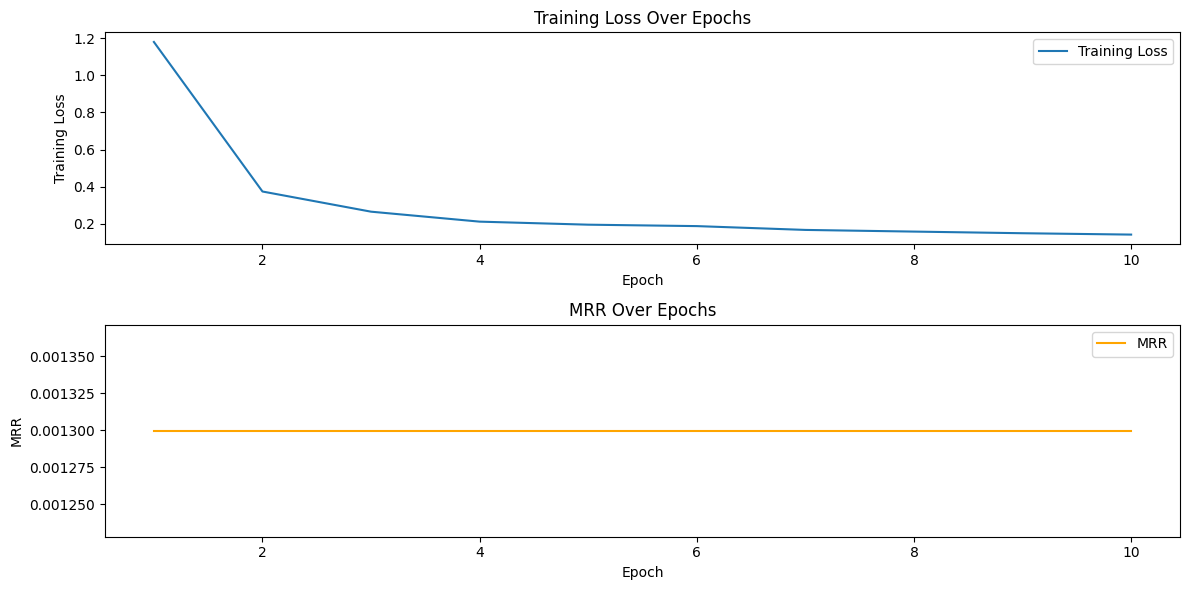

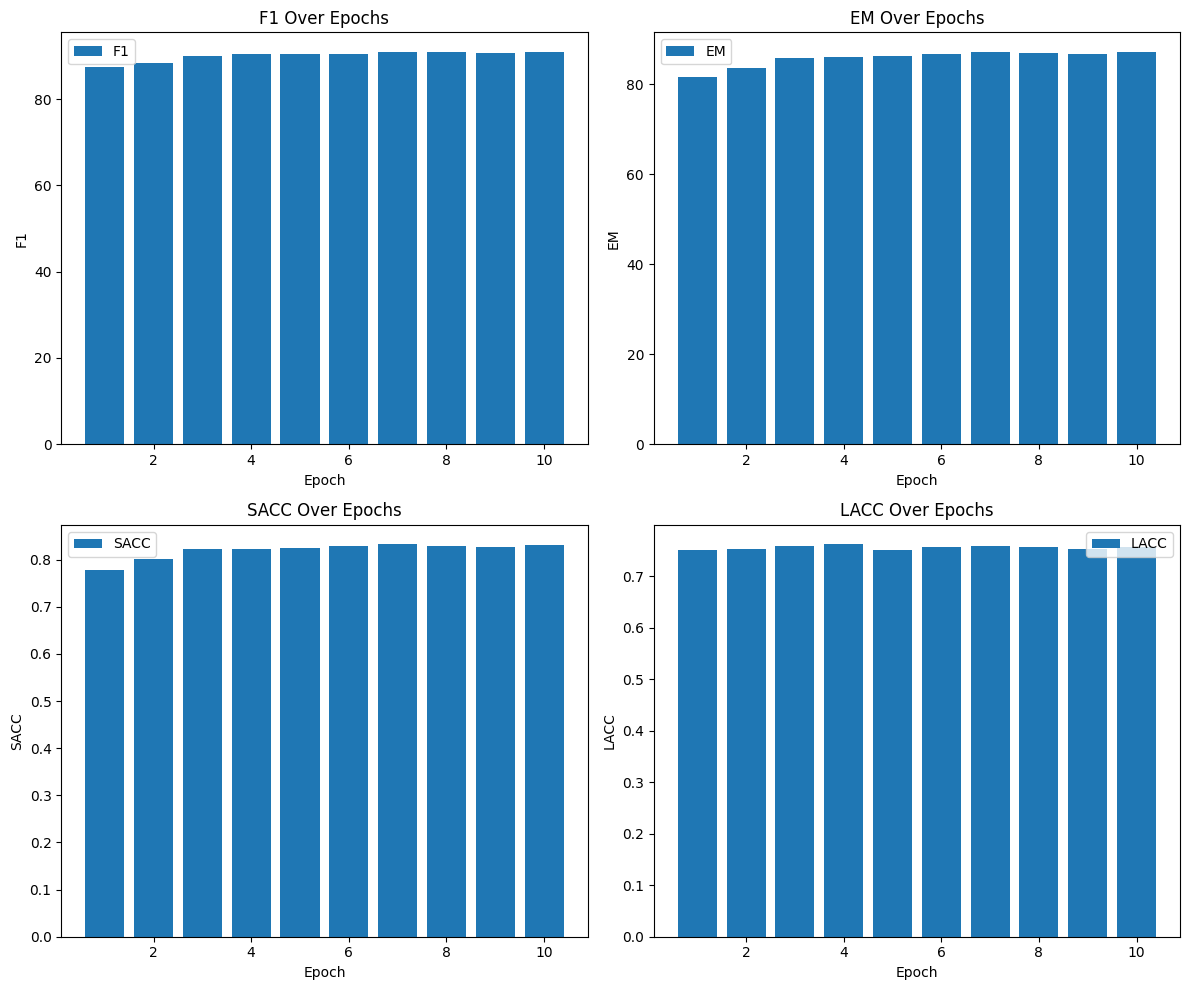

100%|██████████| 5450/5450 [14:24<00:00,  6.31it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:14<11:05,  7.38it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.03it/s]


Epoch 0 Metrics:
Training Loss: 1.2473089512608466
EM: 80.73394495412845
F1: 86.17845403169895
MRR: 0.0012996941896024465
Lacc: 0.7321100917431193
Sacc: 0.7660550458715596


 20%|█▉        | 1089/5450 [02:39<09:51,  7.37it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.35it/s]


Epoch 1 Metrics:
Training Loss: 0.3739657187014135
EM: 86.23853211009174
F1: 90.06480119554777
MRR: 0.0012996941896024465
Lacc: 0.7582568807339449
Sacc: 0.8229357798165138


 30%|██▉       | 1634/5450 [04:04<08:36,  7.39it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.98it/s]


Epoch 2 Metrics:
Training Loss: 0.2523648011737392
EM: 83.4862385321101
F1: 88.26347594893315
MRR: 0.002981651376146789
Lacc: 0.7440366972477064
Sacc: 0.7926605504587156


 40%|███▉      | 2179/5450 [05:29<07:24,  7.35it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.30it/s]


Epoch 3 Metrics:
Training Loss: 0.2094580633441892
EM: 85.3211009174312
F1: 89.08177284201068
MRR: 0.0012996941896024465
Lacc: 0.7495412844036697
Sacc: 0.8155963302752294


 50%|████▉     | 2724/5450 [06:54<06:09,  7.39it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.50it/s]


Epoch 4 Metrics:
Training Loss: 0.18453403902539145
EM: 84.40366972477064
F1: 88.38403988410221
MRR: 0.0012996941896024465
Lacc: 0.7440366972477064
Sacc: 0.8018348623853211


 60%|█████▉    | 3269/5450 [08:19<05:00,  7.25it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.22it/s]


Epoch 5 Metrics:
Training Loss: 0.1692174295137568
EM: 85.3211009174312
F1: 89.39516028899372
MRR: 0.0021406727828746173
Lacc: 0.748165137614679
Sacc: 0.8110091743119267


 70%|██████▉   | 3814/5450 [09:44<03:42,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.32it/s]


Epoch 6 Metrics:
Training Loss: 0.15210830727004693
EM: 85.59633027522936
F1: 89.25490187668714
MRR: 0.0012996941896024465
Lacc: 0.744954128440367
Sacc: 0.8137614678899082


 80%|███████▉  | 4359/5450 [11:09<02:27,  7.41it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.27it/s]


Epoch 7 Metrics:
Training Loss: 0.1466445511329808
EM: 85.87155963302752
F1: 89.56602287777038
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8155963302752294


 90%|████████▉ | 4904/5450 [12:34<01:14,  7.36it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.21it/s]


Epoch 8 Metrics:
Training Loss: 0.13741728106359824
EM: 85.87155963302752
F1: 89.46969260254102
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8174311926605504


100%|█████████▉| 5449/5450 [13:58<00:00,  7.37it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.23it/s]


Epoch 9 Metrics:
Training Loss: 0.13206629844231813
EM: 85.87155963302752
F1: 89.46909387600711
MRR: 0.0021406727828746173
Lacc: 0.7440366972477064
Sacc: 0.8174311926605504
EM - Highest: 86.23853211009174, Lowest: 80.73394495412845, Average: 84.87155963302753
F1 - Highest: 90.06480119554777, Lowest: 86.17845403169895, Average: 88.91274154242922
MRR - Highest: 0.002981651376146789, Lowest: 0.0012996941896024465, Average: 0.0016360856269113148
Lacc - Highest: 0.7582568807339449, Lowest: 0.7321100917431193, Average: 0.7458256880733944
Sacc - Highest: 0.8229357798165138, Lowest: 0.7660550458715596, Average: 0.8074311926605505


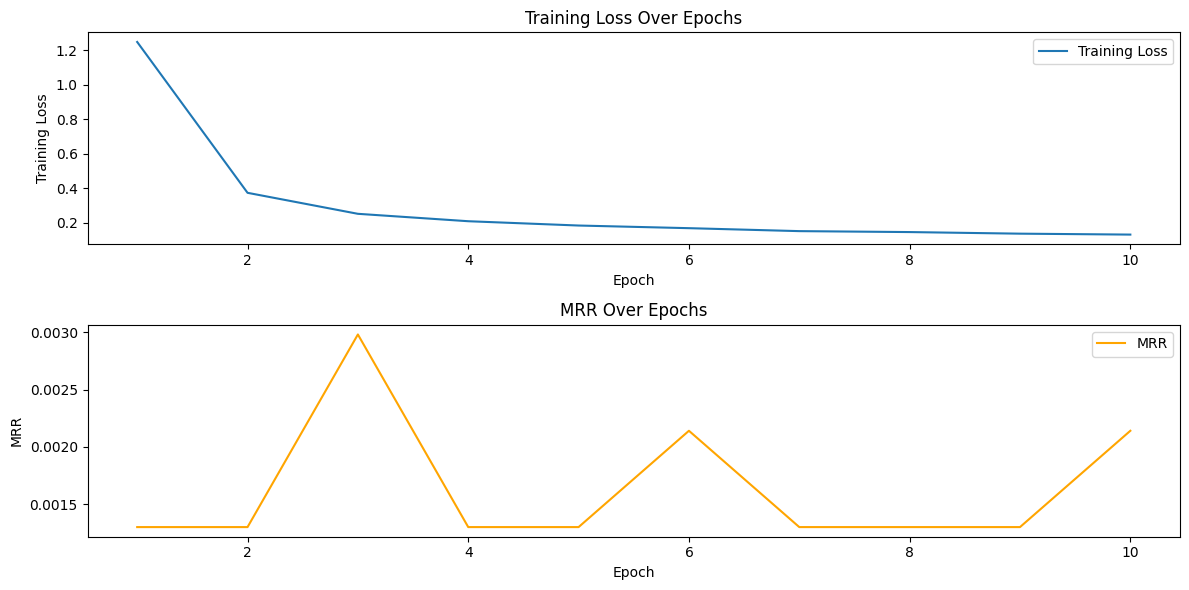

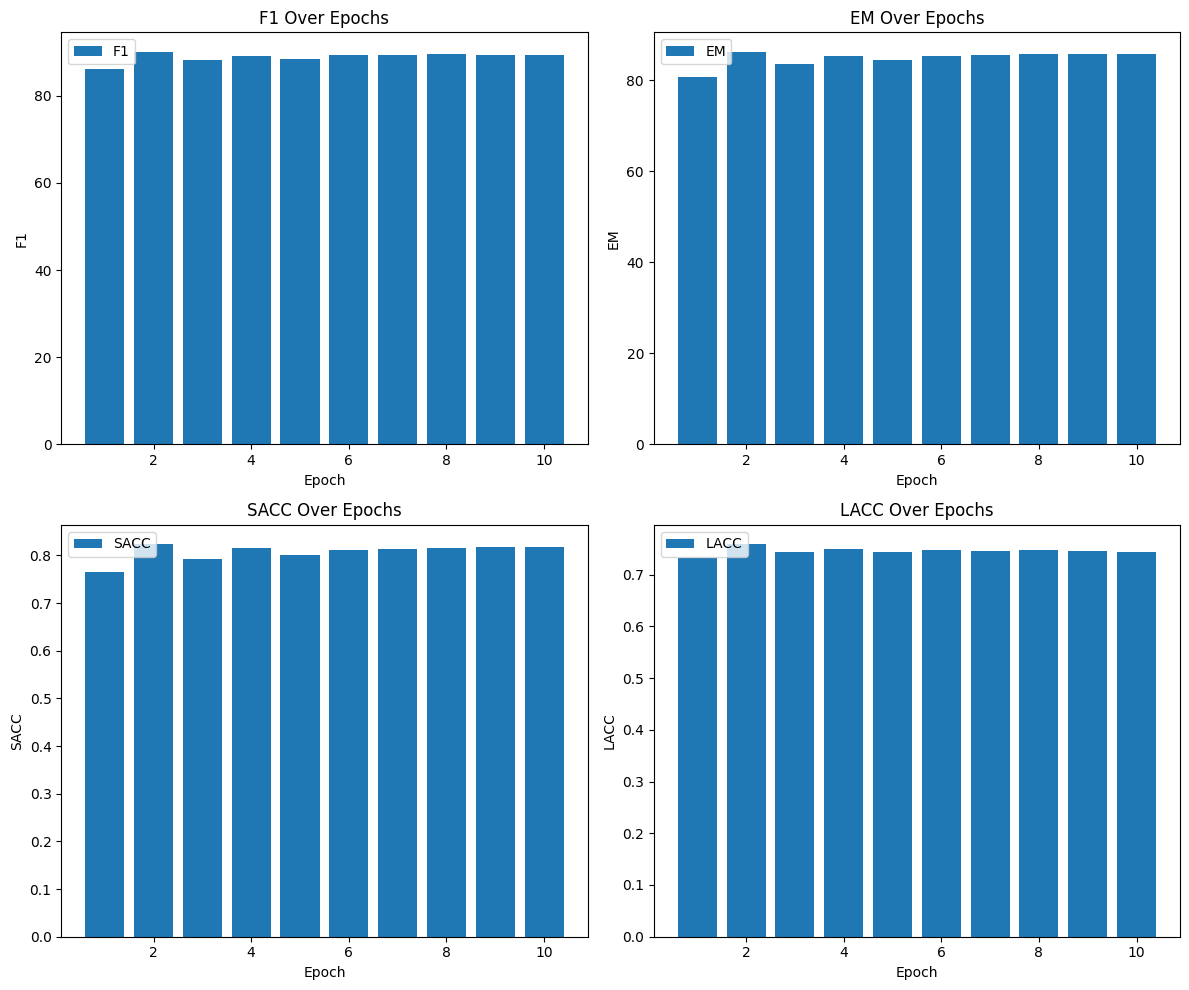

100%|██████████| 5450/5450 [14:11<00:00,  6.40it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:14<11:13,  7.29it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.23it/s]


Epoch 0 Metrics:
Training Loss: 1.1919809016886107
EM: 83.30275229357798
F1: 88.20553858372173
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.7889908256880734


 20%|█▉        | 1089/5450 [02:39<09:52,  7.36it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.30it/s]


Epoch 1 Metrics:
Training Loss: 0.36300391587642356
EM: 85.22935779816514
F1: 89.04392078554883
MRR: 0.004663608562691131
Lacc: 0.7559633027522936
Sacc: 0.8110091743119267


 30%|██▉       | 1634/5450 [04:04<09:09,  6.94it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.36it/s]


Epoch 2 Metrics:
Training Loss: 0.25370925641191455
EM: 85.13761467889908
F1: 88.90565039851244
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.810091743119266


 40%|███▉      | 2179/5450 [05:29<07:26,  7.32it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.30it/s]


Epoch 3 Metrics:
Training Loss: 0.214671132716974
EM: 86.5137614678899
F1: 90.25126401018112
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8201834862385321


 50%|████▉     | 2724/5450 [06:54<06:12,  7.31it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.39it/s]


Epoch 4 Metrics:
Training Loss: 0.18646579306613262
EM: 87.1559633027523
F1: 90.34639337292771
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8256880733944955


 60%|█████▉    | 3269/5450 [08:20<04:55,  7.38it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.22it/s]


Epoch 5 Metrics:
Training Loss: 0.17082768223214245
EM: 86.23853211009174
F1: 89.71142214819604
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.818348623853211


 70%|██████▉   | 3814/5450 [09:45<03:42,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.30it/s]


Epoch 6 Metrics:
Training Loss: 0.16499727031754313
EM: 86.42201834862385
F1: 90.03295019021846
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8201834862385321


 80%|███████▉  | 4359/5450 [11:10<02:28,  7.37it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.21it/s]


Epoch 7 Metrics:
Training Loss: 0.15075760135542465
EM: 86.78899082568807
F1: 90.10323937896422
MRR: 0.0021406727828746173
Lacc: 0.7472477064220183
Sacc: 0.8220183486238533


 90%|████████▉ | 4904/5450 [12:34<01:14,  7.35it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.27it/s]


Epoch 8 Metrics:
Training Loss: 0.13856504984187185
EM: 86.5137614678899
F1: 89.68703937102107
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8192660550458716


100%|█████████▉| 5449/5450 [13:59<00:00,  7.38it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.21it/s]


Epoch 9 Metrics:
Training Loss: 0.13678056194149
EM: 86.97247706422019
F1: 90.0012595545073
MRR: 0.0021406727828746173
Lacc: 0.7490825688073395
Sacc: 0.8238532110091743
EM - Highest: 87.1559633027523, Lowest: 83.30275229357798, Average: 86.02752293577983
F1 - Highest: 90.34639337292771, Lowest: 88.20553858372173, Average: 89.6288677793799
MRR - Highest: 0.004663608562691131, Lowest: 0.0012996941896024465, Average: 0.0018042813455657488
Lacc - Highest: 0.7559633027522936, Lowest: 0.7458715596330275, Average: 0.7486238532110092
Sacc - Highest: 0.8256880733944955, Lowest: 0.7889908256880734, Average: 0.8159633027522937


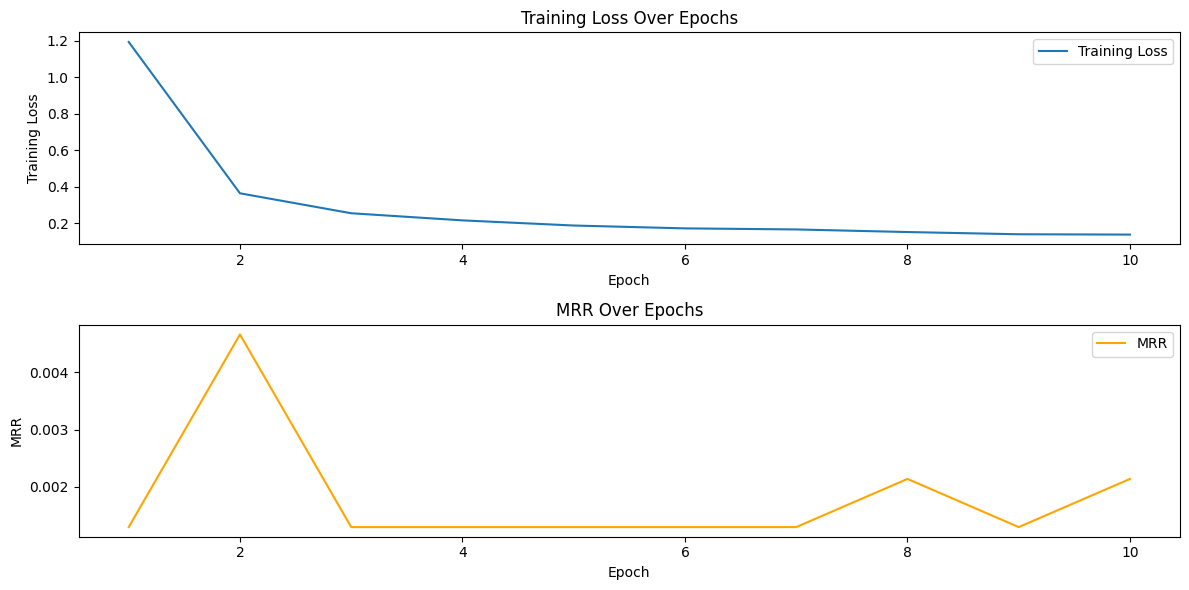

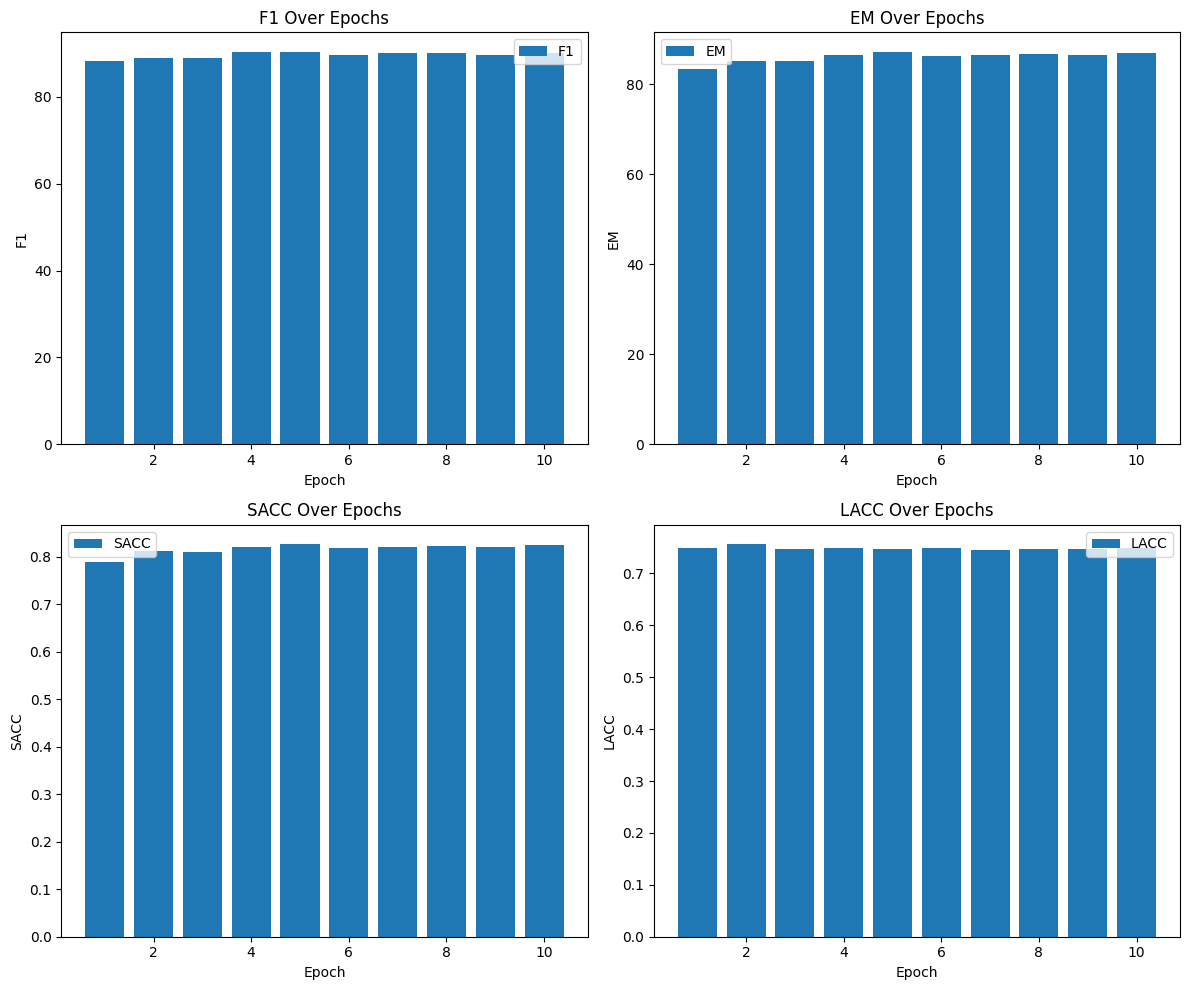

100%|██████████| 5450/5450 [14:12<00:00,  6.39it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:14<11:15,  7.27it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.32it/s]


Epoch 0 Metrics:
Training Loss: 1.21304792629196
EM: 81.8348623853211
F1: 87.99428649967604
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.7697247706422018


 20%|█▉        | 1089/5450 [02:39<09:56,  7.31it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.30it/s]


Epoch 1 Metrics:
Training Loss: 0.37608725277177235
EM: 84.58715596330275
F1: 89.04266791544731
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.7990825688073394


 30%|██▉       | 1634/5450 [04:05<08:51,  7.18it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.15it/s]


Epoch 2 Metrics:
Training Loss: 0.2551233230098877
EM: 86.3302752293578
F1: 90.47083242497135
MRR: 0.0021406727828746173
Lacc: 0.7477064220183486
Sacc: 0.8128440366972477


 40%|███▉      | 2179/5450 [05:30<07:34,  7.20it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.27it/s]


Epoch 3 Metrics:
Training Loss: 0.20111076573546496
EM: 85.96330275229357
F1: 89.78606801576298
MRR: 0.0012996941896024465
Lacc: 0.7399082568807339
Sacc: 0.8110091743119267


 50%|████▉     | 2724/5450 [06:55<06:10,  7.35it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.49it/s]


Epoch 4 Metrics:
Training Loss: 0.1810332942956956
EM: 86.42201834862385
F1: 90.17048427109631
MRR: 0.0021406727828746173
Lacc: 0.7472477064220183
Sacc: 0.8165137614678899


 60%|█████▉    | 3269/5450 [08:22<04:57,  7.32it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.25it/s]


Epoch 5 Metrics:
Training Loss: 0.16550191937883837
EM: 86.23853211009174
F1: 89.91021389532393
MRR: 0.0012996941896024465
Lacc: 0.7444954128440368
Sacc: 0.8174311926605504


 70%|██████▉   | 3814/5450 [09:48<03:50,  7.11it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.47it/s]


Epoch 6 Metrics:
Training Loss: 0.15483939596579982
EM: 86.3302752293578
F1: 90.20995425643858
MRR: 0.0021406727828746173
Lacc: 0.744954128440367
Sacc: 0.8192660550458716


 80%|███████▉  | 4359/5450 [11:14<02:29,  7.29it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.49it/s]


Epoch 7 Metrics:
Training Loss: 0.14297164720435063
EM: 86.14678899082568
F1: 89.75069854474356
MRR: 0.0021406727828746173
Lacc: 0.7389908256880734
Sacc: 0.8146788990825689


 90%|████████▉ | 4904/5450 [12:41<01:19,  6.87it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.80it/s]


Epoch 8 Metrics:
Training Loss: 0.13347355660778437
EM: 86.5137614678899
F1: 90.28074068994749
MRR: 0.0012996941896024465
Lacc: 0.7399082568807339
Sacc: 0.8174311926605504


100%|█████████▉| 5449/5450 [14:10<00:00,  7.02it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.13it/s]


Epoch 9 Metrics:
Training Loss: 0.12878761249049694
EM: 85.77981651376147
F1: 89.7071476163544
MRR: 0.0012996941896024465
Lacc: 0.7380733944954129
Sacc: 0.810091743119266
EM - Highest: 86.5137614678899, Lowest: 81.8348623853211, Average: 85.61467889908258
F1 - Highest: 90.47083242497135, Lowest: 87.99428649967604, Average: 89.7323094129762
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0016360856269113148
Lacc - Highest: 0.7559633027522936, Lowest: 0.7380733944954129, Average: 0.7450458715596332
Sacc - Highest: 0.8192660550458716, Lowest: 0.7697247706422018, Average: 0.8088073394495414


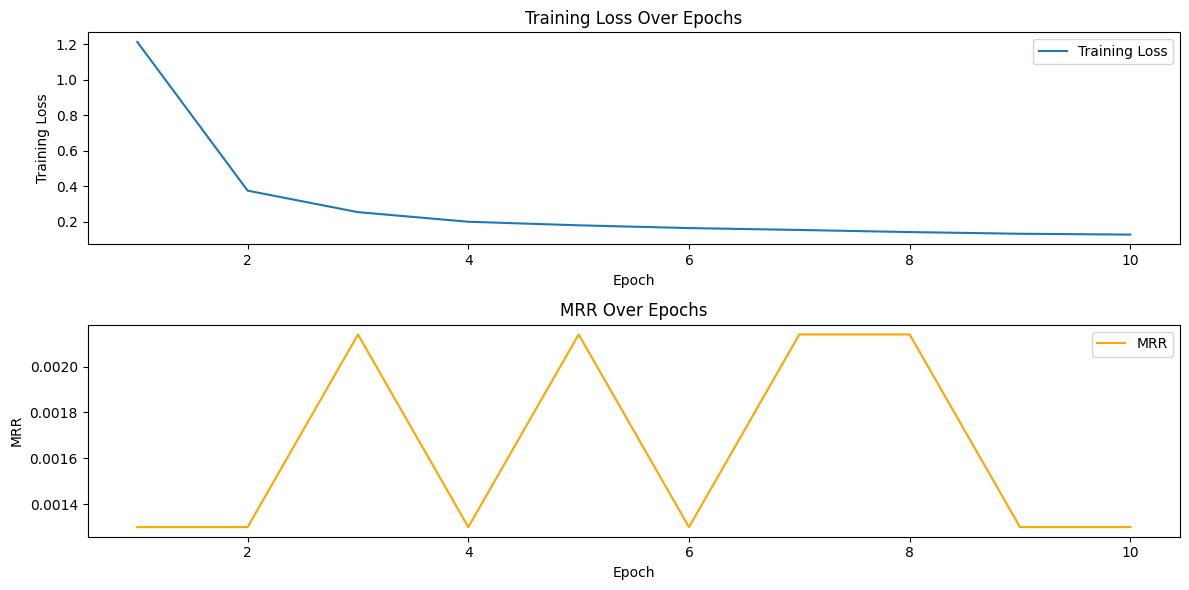

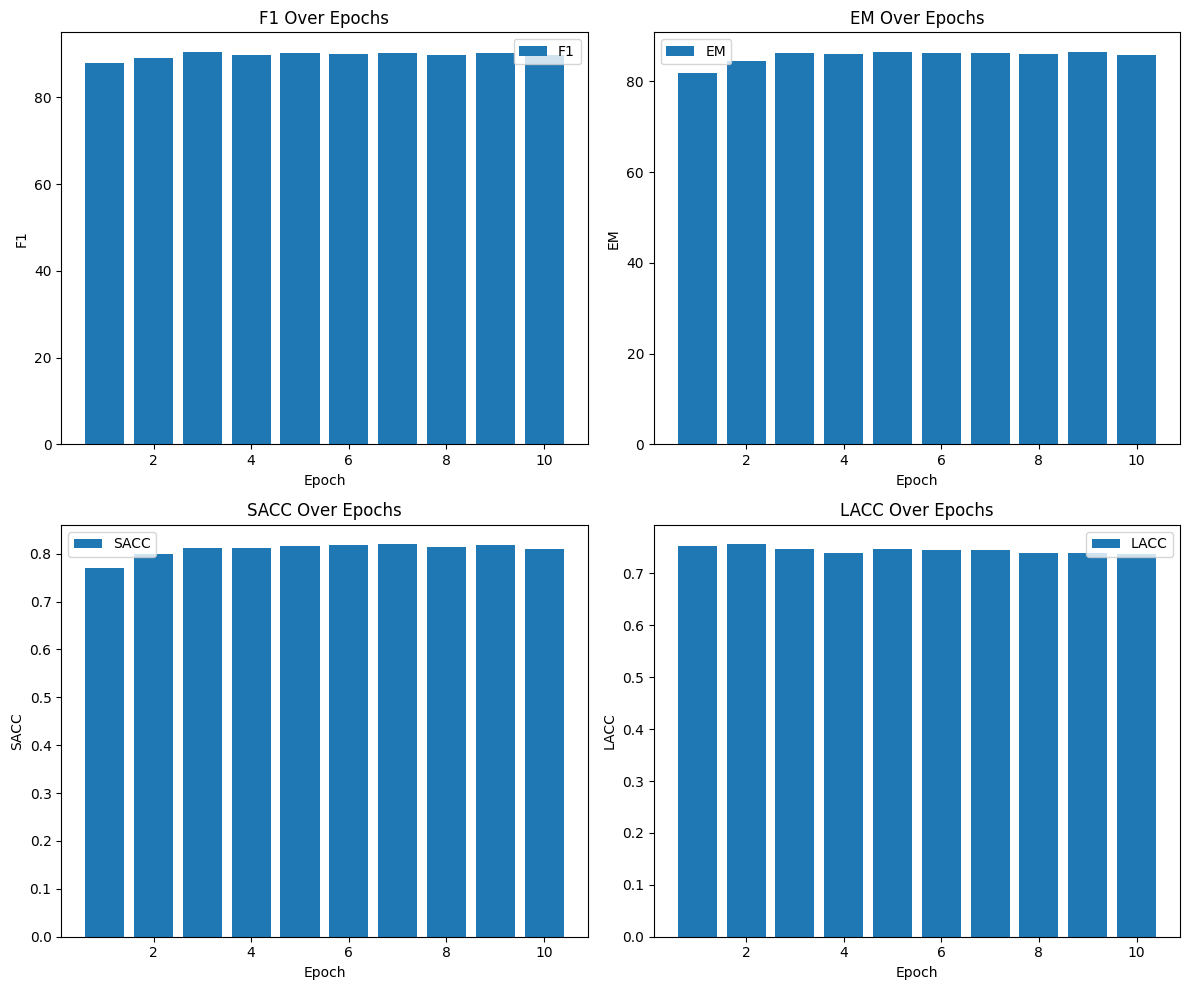

100%|██████████| 5450/5450 [14:24<00:00,  6.30it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:18<11:19,  7.22it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.79it/s]


Epoch 0 Metrics:
Training Loss: 1.2229572220816525
EM: 81.92660550458716
F1: 86.29095308685547
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.7770642201834862


 20%|█▉        | 1089/5450 [02:47<10:29,  6.92it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.84it/s]


Epoch 1 Metrics:
Training Loss: 0.3660467490673475
EM: 83.4862385321101
F1: 88.23168087754667
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.791743119266055


 30%|██▉       | 1634/5450 [04:17<08:44,  7.27it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.88it/s]


Epoch 2 Metrics:
Training Loss: 0.2513878914933447
EM: 84.86238532110092
F1: 88.96633040917057
MRR: 0.0021406727828746177
Lacc: 0.7486238532110092
Sacc: 0.808256880733945


 40%|███▉      | 2179/5450 [05:43<07:20,  7.42it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.38it/s]


Epoch 3 Metrics:
Training Loss: 0.20676483367932874
EM: 85.04587155963303
F1: 88.8572304370283
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8091743119266055


 50%|████▉     | 2724/5450 [07:08<06:09,  7.37it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.32it/s]


Epoch 4 Metrics:
Training Loss: 0.18186329199554432
EM: 86.05504587155963
F1: 89.33408770759848
MRR: 0.0021406727828746173
Lacc: 0.7440366972477064
Sacc: 0.818348623853211


 60%|█████▉    | 3269/5450 [08:33<04:54,  7.40it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.15it/s]


Epoch 5 Metrics:
Training Loss: 0.17490183350281926
EM: 85.96330275229357
F1: 89.29731540153313
MRR: 0.0021406727828746173
Lacc: 0.744954128440367
Sacc: 0.8174311926605504


 70%|██████▉   | 3814/5450 [09:58<03:40,  7.41it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.33it/s]


Epoch 6 Metrics:
Training Loss: 0.15751422132940007
EM: 85.77981651376147
F1: 89.59354139176882
MRR: 0.0021406727828746173
Lacc: 0.7417431192660551
Sacc: 0.8165137614678899


 80%|███████▉  | 4359/5450 [11:23<02:28,  7.34it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.40it/s]


Epoch 7 Metrics:
Training Loss: 0.14849750143983145
EM: 86.05504587155963
F1: 89.33119119174998
MRR: 0.0021406727828746173
Lacc: 0.7371559633027523
Sacc: 0.818348623853211


 90%|████████▉ | 4904/5450 [12:47<01:14,  7.31it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.35it/s]


Epoch 8 Metrics:
Training Loss: 0.1424155478986779
EM: 86.5137614678899
F1: 89.69033968851316
MRR: 0.0021406727828746173
Lacc: 0.7408256880733946
Sacc: 0.8220183486238533


100%|█████████▉| 5449/5450 [14:12<00:00,  7.29it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.36it/s]


Epoch 9 Metrics:
Training Loss: 0.13348084028255955
EM: 86.3302752293578
F1: 89.66463705271877
MRR: 0.0021406727828746173
Lacc: 0.7417431192660551
Sacc: 0.8211009174311926
EM - Highest: 86.5137614678899, Lowest: 81.92660550458716, Average: 85.20183486238531
F1 - Highest: 89.69033968851316, Lowest: 86.29095308685547, Average: 88.92573072444834
MRR - Highest: 0.0021406727828746177, Lowest: 0.0012996941896024465, Average: 0.0018883792048929662
Lacc - Highest: 0.7486238532110092, Lowest: 0.7371559633027523, Average: 0.7442201834862386
Sacc - Highest: 0.8220183486238533, Lowest: 0.7770642201834862, Average: 0.8099999999999999


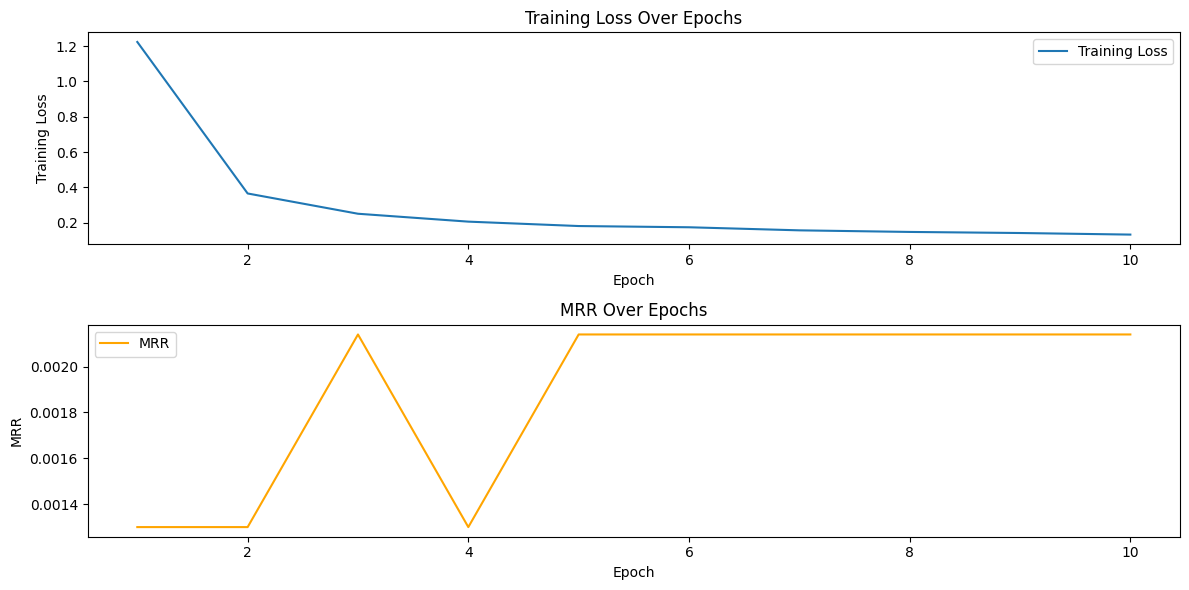

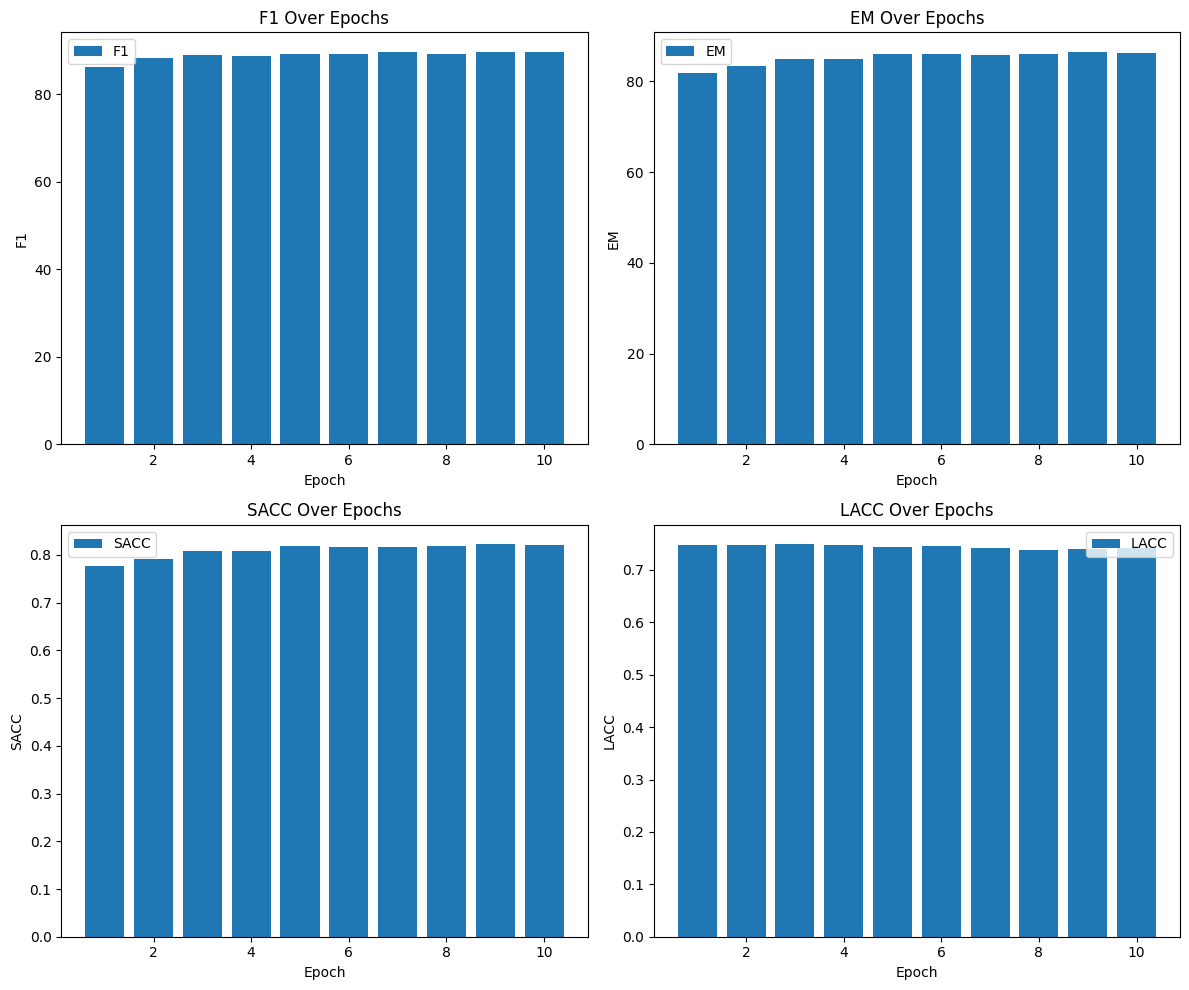

100%|██████████| 5450/5450 [14:26<00:00,  6.29it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:14<11:14,  7.28it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.27it/s]


Epoch 0 Metrics:
Training Loss: 1.1478794456690276
EM: 82.20183486238533
F1: 87.92995477246322
MRR: 0.0012996941896024465
Lacc: 0.7513761467889908
Sacc: 0.7880733944954128


 20%|█▉        | 1089/5450 [02:39<09:57,  7.30it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.50it/s]


Epoch 1 Metrics:
Training Loss: 0.35773888373397156
EM: 84.31192660550458
F1: 88.59817481170323
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8036697247706422


 30%|██▉       | 1634/5450 [04:03<08:35,  7.40it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.36it/s]


Epoch 2 Metrics:
Training Loss: 0.24757435806010158
EM: 86.05504587155963
F1: 89.88227489342876
MRR: 0.0012996941896024465
Lacc: 0.7577981651376147
Sacc: 0.8146788990825689


 40%|███▉      | 2179/5450 [05:28<07:24,  7.37it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.18it/s]


Epoch 3 Metrics:
Training Loss: 0.20820819013388914
EM: 86.05504587155963
F1: 89.52413843443168
MRR: 0.0012996941896024465
Lacc: 0.751834862385321
Sacc: 0.8128440366972477


 50%|████▉     | 2724/5450 [06:53<06:08,  7.40it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.23it/s]


Epoch 4 Metrics:
Training Loss: 0.19066294291080188
EM: 86.3302752293578
F1: 89.958867587516
MRR: 0.0012996941896024465
Lacc: 0.7555045871559632
Sacc: 0.8165137614678899


 60%|█████▉    | 3269/5450 [08:18<04:56,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 28.90it/s]


Epoch 5 Metrics:
Training Loss: 0.17587462399494536
EM: 86.69724770642202
F1: 90.27583411348554
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8211009174311926


 70%|██████▉   | 3814/5450 [09:43<03:42,  7.35it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.23it/s]


Epoch 6 Metrics:
Training Loss: 0.16094952143468133
EM: 87.33944954128441
F1: 91.00536946390592
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.8238532110091743


 80%|███████▉  | 4359/5450 [11:08<02:28,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.53it/s]


Epoch 7 Metrics:
Training Loss: 0.1524647416406495
EM: 86.69724770642202
F1: 90.47265200408437
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8220183486238533


 90%|████████▉ | 4904/5450 [12:33<01:13,  7.41it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.32it/s]


Epoch 8 Metrics:
Training Loss: 0.1471048016211663
EM: 87.43119266055047
F1: 90.76303599849709
MRR: 0.0012996941896024465
Lacc: 0.7522935779816514
Sacc: 0.826605504587156


100%|█████████▉| 5449/5450 [13:58<00:00,  7.36it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.51it/s]


Epoch 9 Metrics:
Training Loss: 0.13630076091260748
EM: 87.5229357798165
F1: 90.80189731667632
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.826605504587156
EM - Highest: 87.5229357798165, Lowest: 82.20183486238533, Average: 86.06422018348624
F1 - Highest: 91.00536946390592, Lowest: 87.92995477246322, Average: 89.9212199396192
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7577981651376147, Lowest: 0.7509174311926605, Average: 0.7537155963302753
Sacc - Highest: 0.826605504587156, Lowest: 0.7880733944954128, Average: 0.8155963302752294


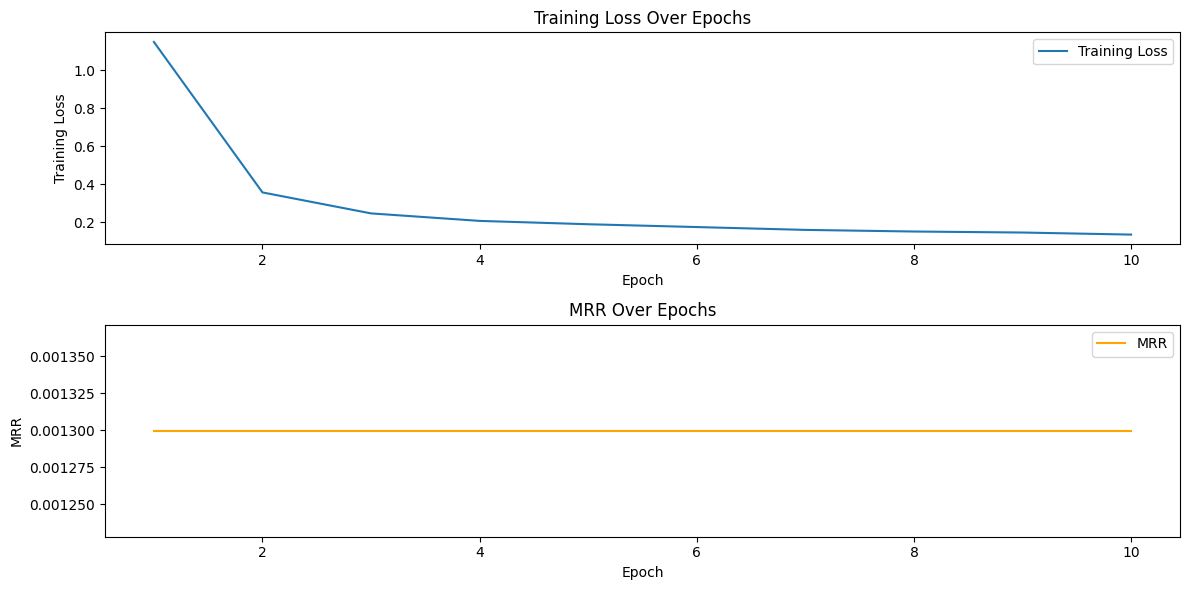

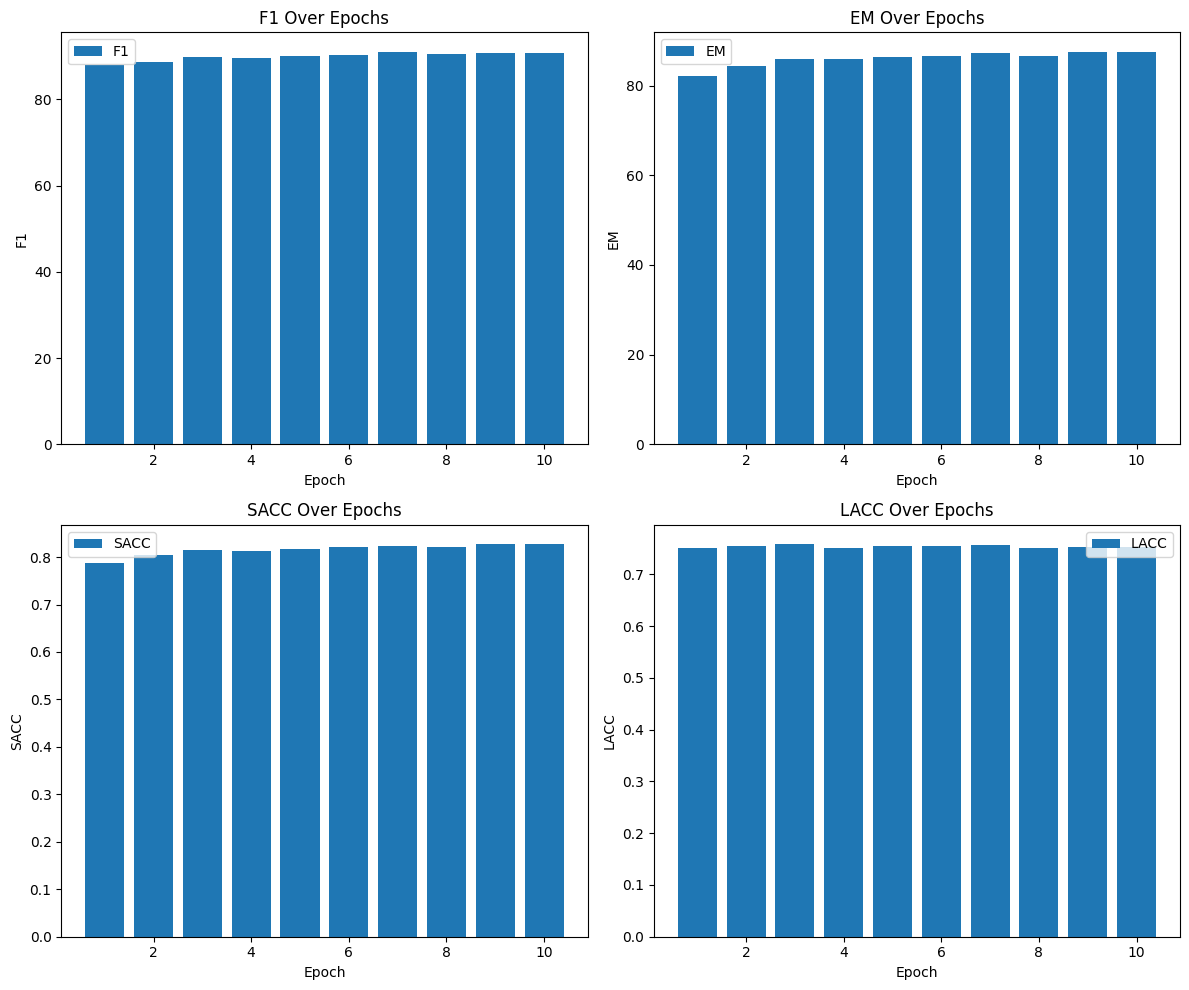

100%|██████████| 5450/5450 [14:11<00:00,  6.40it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:14<11:02,  7.41it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.39it/s]


Epoch 0 Metrics:
Training Loss: 1.1746718262963065
EM: 82.75229357798165
F1: 87.26217498815829
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.7834862385321101


 20%|█▉        | 1089/5450 [02:39<09:48,  7.41it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.32it/s]


Epoch 1 Metrics:
Training Loss: 0.3598896874268667
EM: 83.6697247706422
F1: 88.08653154023233
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.7889908256880734


 30%|██▉       | 1634/5450 [04:04<08:37,  7.38it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.07it/s]


Epoch 2 Metrics:
Training Loss: 0.25265596903168486
EM: 84.6788990825688
F1: 88.71264331202539
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.7972477064220184


 40%|███▉      | 2179/5450 [05:29<07:27,  7.31it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.06it/s]


Epoch 3 Metrics:
Training Loss: 0.20828937274818266
EM: 84.77064220183486
F1: 88.65637336625751
MRR: 0.0012996941896024465
Lacc: 0.7408256880733946
Sacc: 0.7990825688073394


 50%|████▉     | 2724/5450 [06:53<06:06,  7.43it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.36it/s]


Epoch 4 Metrics:
Training Loss: 0.1895111604657776
EM: 85.3211009174312
F1: 89.14002258736103
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8018348623853211


 60%|█████▉    | 3269/5450 [08:18<04:56,  7.36it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.12it/s]


Epoch 5 Metrics:
Training Loss: 0.174885544381553
EM: 84.6788990825688
F1: 89.00407357221184
MRR: 0.0012996941896024465
Lacc: 0.7385321100917431
Sacc: 0.7972477064220184


 70%|██████▉   | 3814/5450 [09:43<03:41,  7.38it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.31it/s]


Epoch 6 Metrics:
Training Loss: 0.16213715423364192
EM: 85.22935779816514
F1: 89.09514672111254
MRR: 0.0012996941896024465
Lacc: 0.7422018348623853
Sacc: 0.8


 80%|███████▉  | 4359/5450 [11:08<02:27,  7.37it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.15it/s]


Epoch 7 Metrics:
Training Loss: 0.15560097045450977
EM: 85.41284403669725
F1: 89.26937717974668
MRR: 0.0012996941896024465
Lacc: 0.7408256880733946
Sacc: 0.8055045871559633


 90%|████████▉ | 4904/5450 [12:33<01:13,  7.43it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.57it/s]


Epoch 8 Metrics:
Training Loss: 0.14272321726247847
EM: 85.3211009174312
F1: 89.12724532647074
MRR: 0.0012996941896024465
Lacc: 0.7380733944954129
Sacc: 0.8045871559633028


100%|█████████▉| 5449/5450 [13:57<00:00,  7.15it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.09it/s]


Epoch 9 Metrics:
Training Loss: 0.14048385843698688
EM: 85.77981651376147
F1: 89.40165545193321
MRR: 0.0012996941896024465
Lacc: 0.7394495412844037
Sacc: 0.8073394495412844
EM - Highest: 85.77981651376147, Lowest: 82.75229357798165, Average: 84.76146788990826
F1 - Highest: 89.40165545193321, Lowest: 87.26217498815829, Average: 88.77552440455096
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7532110091743119, Lowest: 0.7380733944954129, Average: 0.7443577981651377
Sacc - Highest: 0.8073394495412844, Lowest: 0.7834862385321101, Average: 0.7985321100917432


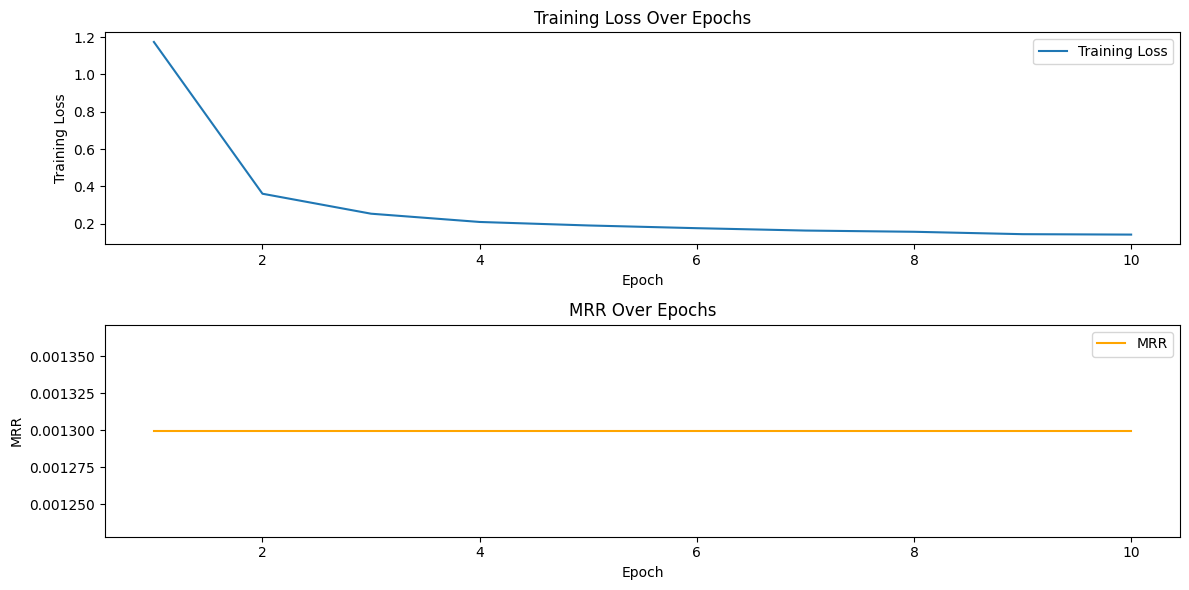

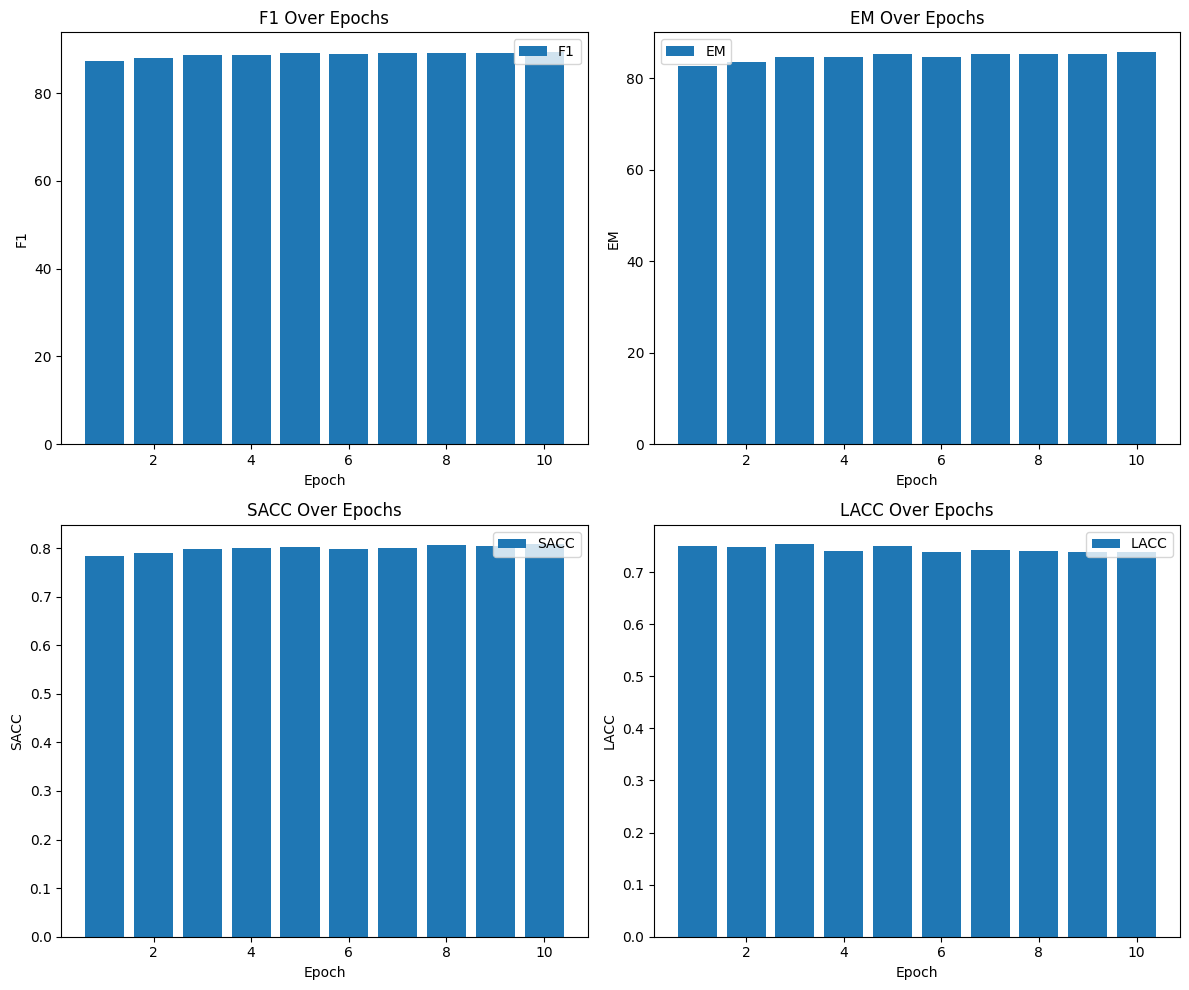

100%|██████████| 5450/5450 [14:11<00:00,  6.40it/s]


In [32]:
# Directory to save models
# 5
save_dir = "biobert_ner_bag_finetuned"
os.makedirs(save_dir, exist_ok=True)

# Number of epochs for training
num_train_epochs = 10

# Train and save models
# bootstrap_samples = bootstrap_sampling(train_dataset, n_samples=10)
for i, train_data in enumerate(bootstrap_samples):
    train_and_save_model(train_data, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, i, num_train_epochs)

In [33]:
class EnsembleModel(PreTrainedModel):
    def __init__(self, config, model_paths):
        super().__init__(config)
        self.models = [AutoModelForQuestionAnswering.from_pretrained(path) for path in model_paths]

    def forward(self, **inputs):
        start_logits_list = []
        end_logits_list = []

        for model in self.models:
            outputs = model(**inputs)
            start_logits_list.append(outputs.start_logits)
            end_logits_list.append(outputs.end_logits)

        start_logits_stack = torch.stack(start_logits_list, dim=0)
        end_logits_stack = torch.stack(end_logits_list, dim=0)

        # Apply majority voting
        start_logits = torch.mode(start_logits_stack, dim=0).values
        end_logits = torch.mode(end_logits_stack, dim=0).values

        return QuestionAnsweringModelOutput(
            start_logits=start_logits,
            end_logits=end_logits,
        )

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        config = AutoConfig.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)
        model_paths = kwargs.pop("model_paths", None)
        model = cls(config, model_paths)
        return model

In [34]:
# Save paths of the individual models
model_paths = [os.path.join(save_dir, f"model_{i}") for i in range(10)]

# Save paths to a JSON file for later use
with open(os.path.join(save_dir, "model_paths.json"), "w") as f:
    json.dump(model_paths, f)

# Load ensemble model
ensemble_model = EnsembleModel.from_pretrained(model_checkpoint, model_paths=model_paths)
ensemble_tokenizer = AutoTokenizer.from_pretrained(save_dir)

In [35]:
def evaluate_ensemble(model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    start_logits_list = []
    end_logits_list = []

    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            start_logits_list.append(outputs.start_logits.cpu().numpy())
            end_logits_list.append(outputs.end_logits.cpu().numpy())

    start_logits = np.concatenate(start_logits_list)[:len(validation_dataset)]
    end_logits = np.concatenate(end_logits_list)[:len(validation_dataset)]

    metrics = compute_metrics(start_logits, end_logits, validation_dataset, raw_val_dataset)

    print("Ensemble Model Metrics:")
    print(f"EM: {metrics['exact_match']}")
    print(f"F1: {metrics['f1']}")
    print(f"MRR: {metrics['mrr']}")
    print(f"Lacc: {metrics['lacc']}")
    print(f"Sacc: {metrics['sacc']}")

    return metrics

# Evaluate ensemble
ensemble_metrics = evaluate_ensemble(ensemble_model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset)


Ensemble Model Metrics:
EM: 85.87155963302752
F1: 89.88594961914737
MRR: 0.0012996941896024465
Lacc: 0.7417431192660551
Sacc: 0.8146788990825689


In [36]:
# # Save ensemble model
# ensemble_model.save_pretrained(save_dir)
# ensemble_tokenizer.save_pretrained(save_dir)

In [37]:
# # from transformers import pipeline

# # model load path customizing --->

# # Load your saved model checkpoint
# # biobert_qa_finetuned = "/content/drive/MyDrive/Colab Notebooks/499/Models 2/biobert_qa_finetuned"


# # Create the question answering pipeline
# question_answerer = pipeline("question-answering", model=ensemble_model, tokenizer=ensemble_tokenizer)

# # People with diabetes experience blurry vision because of what?
# # What are the symptoms of blurry vision for diabetes people?
# # Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications.
# question = "What are the symptoms of blurry vision for diabetes people?"
# context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."


# # Perform question answering
# answer = question_answerer(question=question, context=context)
# print(answer)

# ner_re_bag

In [38]:
# 6
def visualize_performance(metrics, train_losses, mrr_scores, num_train_epochs, save_path='performance_graph'):
    epochs = range(1, num_train_epochs + 1)

    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # Line graphs for training loss and MRR
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, mrr_scores, label='MRR', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('MRR')
    plt.title('MRR Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_loss_mrr.png'), dpi=300)
    plt.show()

    # Bar charts for F1, EM, SACC, LACC
    metric_names = ['F1', 'EM', 'SACC', 'LACC']
    metrics_scores = [metrics['f1'], metrics['exact_match'], metrics['sacc'], metrics['lacc']]

    plt.figure(figsize=(12, 10))
    for i, (metric, scores) in enumerate(zip(metric_names, metrics_scores)):
        plt.subplot(2, 2, i + 1)
        plt.bar(epochs, scores, label=metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} Over Epochs')
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'metrics_over_epochs.png'), dpi=300)
    plt.show()

In [39]:
def train_and_save_model(train_dataset, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, model_idx, num_train_epochs):
    model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
    # 7
    ner_model = BertForQuestionAnswering.from_pretrained('biobert_model_ner')
    model.bert = ner_model.bert
    # 8
    re_model = BertForQuestionAnswering.from_pretrained('biobert_model_re')
    model.bert = re_model.bert
    # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    train_dataset = set_format(train_dataset, "torch")
    train_dataset = CustomDataset(train_dataset)
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=custom_collate_fn,
        batch_size=8,
    )

    validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
    validation_set.set_format("torch")

    eval_dataloader = DataLoader(
        validation_set, collate_fn=custom_collate_fn, batch_size=8
    )

    optimizer = AdamW(model.parameters(), lr=2e-5)
    accelerator = Accelerator()
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_train_epochs * num_update_steps_per_epoch

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Assuming these lists exist to hold metrics for each epoch
    train_losses = []
    em_scores = []
    f1_scores = []
    mrr_scores = []
    lacc_scores = []
    sacc_scores = []

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_train_epochs):
        # Training
        model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        average_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        # Evaluation
        model.eval()
        start_logits = []
        end_logits = []
        total_val_loss = 0
        accelerator.print("Evaluation!")
        for batch in tqdm(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)

            start_logits.append(accelerator.gather(outputs.start_logits).cpu().numpy())
            end_logits.append(accelerator.gather(outputs.end_logits).cpu().numpy())

        start_logits = np.concatenate(start_logits)
        end_logits = np.concatenate(end_logits)
        start_logits = start_logits[: len(validation_dataset)]
        end_logits = end_logits[: len(validation_dataset)]

        metrics = compute_metrics(
            start_logits, end_logits, validation_dataset, raw_val_dataset
        )

        em_scores.append(metrics['exact_match'])
        f1_scores.append(metrics['f1'])
        mrr_scores.append(metrics['mrr'])
        lacc_scores.append(metrics['lacc'])
        sacc_scores.append(metrics['sacc'])

        print(f"Epoch {epoch} Metrics:")
        print(f"Training Loss: {average_train_loss}")
        print(f"EM: {metrics['exact_match']}")
        print(f"F1: {metrics['f1']}")
        print(f"MRR: {metrics['mrr']}")
        print(f"Lacc: {metrics['lacc']}")
        print(f"Sacc: {metrics['sacc']}")

    metrics_statistics = {
        'EM': compute_statistics(em_scores),
        'F1': compute_statistics(f1_scores),
        'MRR': compute_statistics(mrr_scores),
        'Lacc': compute_statistics(lacc_scores),
        'Sacc': compute_statistics(sacc_scores),
    }

    for metric, stats in metrics_statistics.items():
        print(f"{metric} - Highest: {stats['highest']}, Lowest: {stats['lowest']}, Average: {stats['average']}")

    visualize_performance({
        'exact_match': em_scores,
        'f1': f1_scores,
        'mrr': mrr_scores,
        'lacc': lacc_scores,
        'sacc': sacc_scores
    }, train_losses, mrr_scores, num_train_epochs)

    model_save_path = os.path.join(save_dir, f"model_{model_idx}")
    model.save_pretrained(model_save_path)
    if model_idx == 0:  # Save the tokenizer only once
        tokenizer.save_pretrained(save_dir)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yeara\AppData\Local\Temp\ipykernel_31960\3448799005.py:6: UserWarning: To copy construct from a tensor, it is reco

Evaluation!


 10%|█         | 546/5450 [01:10<2:06:36,  1.55s/it]

Epoch 0 Metrics:
Training Loss: 1.1634956825900515
EM: 82.8440366972477
F1: 88.25546758094816
MRR: 0.004663608562691131
Lacc: 0.7573394495412844
Sacc: 0.7880733944954128


 20%|█▉        | 1089/5450 [02:14<08:26,  8.60it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:20<1:52:47,  1.55s/it]

Epoch 1 Metrics:
Training Loss: 0.3676251955159487
EM: 84.77064220183486
F1: 89.09132403886841
MRR: 0.0012996941896024465
Lacc: 0.7637614678899083
Sacc: 0.8128440366972477


 30%|██▉       | 1634/5450 [03:24<07:28,  8.50it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:01,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.24751896437197718
EM: 85.3211009174312
F1: 89.88766050620936
MRR: 0.004663608562691132
Lacc: 0.7490825688073395
Sacc: 0.8165137614678899


 40%|███▉      | 2179/5450 [04:34<06:27,  8.43it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.15it/s]


Epoch 3 Metrics:
Training Loss: 0.2009115041402348
EM: 85.68807339449542
F1: 89.5911720484162
MRR: 0.0012996941896024465
Lacc: 0.7495412844036697
Sacc: 0.8192660550458716


 50%|████▉     | 2724/5450 [05:44<05:19,  8.54it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.24it/s]


Epoch 4 Metrics:
Training Loss: 0.17445426603155467
EM: 85.59633027522936
F1: 89.57385308771394
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8137614678899082


 60%|█████▉    | 3269/5450 [06:55<04:17,  8.46it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:01<56:37,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16145259332592138
EM: 85.77981651376147
F1: 89.49028371447054
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8220183486238533


 70%|██████▉   | 3814/5450 [08:05<03:10,  8.59it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:11<42:13,  1.55s/it]

Epoch 6 Metrics:
Training Loss: 0.14929904417768164
EM: 85.87155963302752
F1: 89.51585767938892
MRR: 0.0012996941896024465
Lacc: 0.7435779816513761
Sacc: 0.818348623853211


 80%|███████▉  | 4359/5450 [09:15<02:07,  8.54it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:21<28:11,  1.55s/it]

Epoch 7 Metrics:
Training Loss: 0.1456957918435331
EM: 86.05504587155963
F1: 89.86965578659698
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8201834862385321


 90%|████████▉ | 4904/5450 [10:25<01:04,  8.46it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:31<14:08,  1.56s/it]

Epoch 8 Metrics:
Training Loss: 0.13455972445689765
EM: 85.87155963302752
F1: 89.64171700135981
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8211009174311926


100%|█████████▉| 5449/5450 [11:35<00:00,  8.56it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.21it/s]


Epoch 9 Metrics:
Training Loss: 0.12970312439252882
EM: 85.96330275229357
F1: 89.66207009672641
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8220183486238533
EM - Highest: 86.05504587155963, Lowest: 82.8440366972477, Average: 85.37614678899082
F1 - Highest: 89.88766050620936, Lowest: 88.25546758094816, Average: 89.45790615406987
MRR - Highest: 0.004663608562691132, Lowest: 0.0012996941896024465, Average: 0.0019724770642201832
Lacc - Highest: 0.7637614678899083, Lowest: 0.7435779816513761, Average: 0.7504128440366972
Sacc - Highest: 0.8220183486238533, Lowest: 0.7880733944954128, Average: 0.8154128440366971


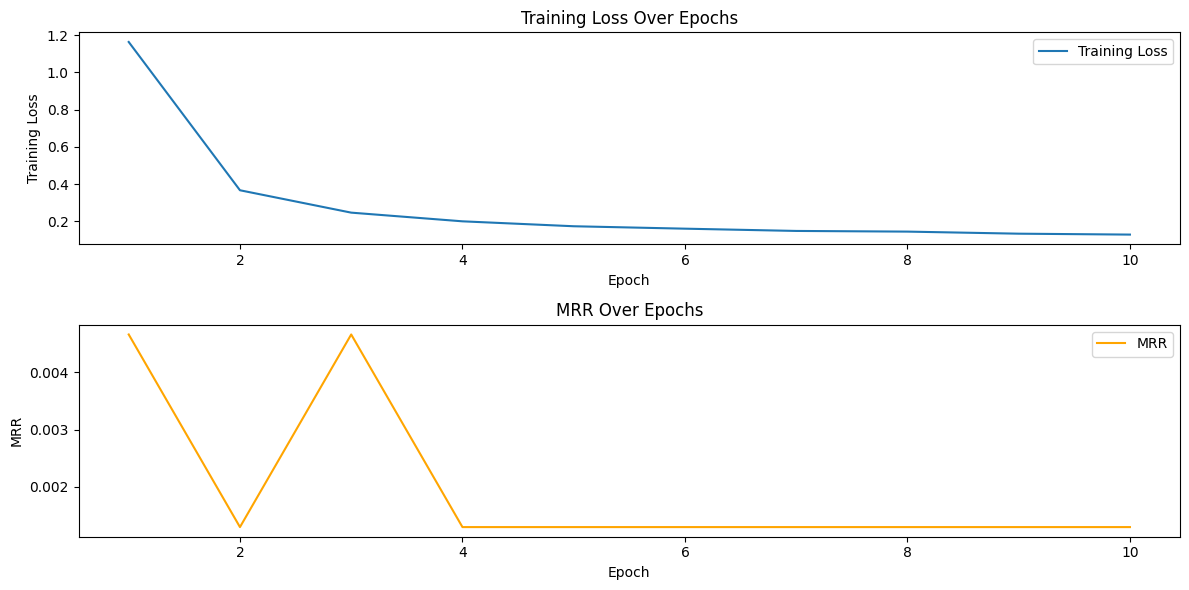

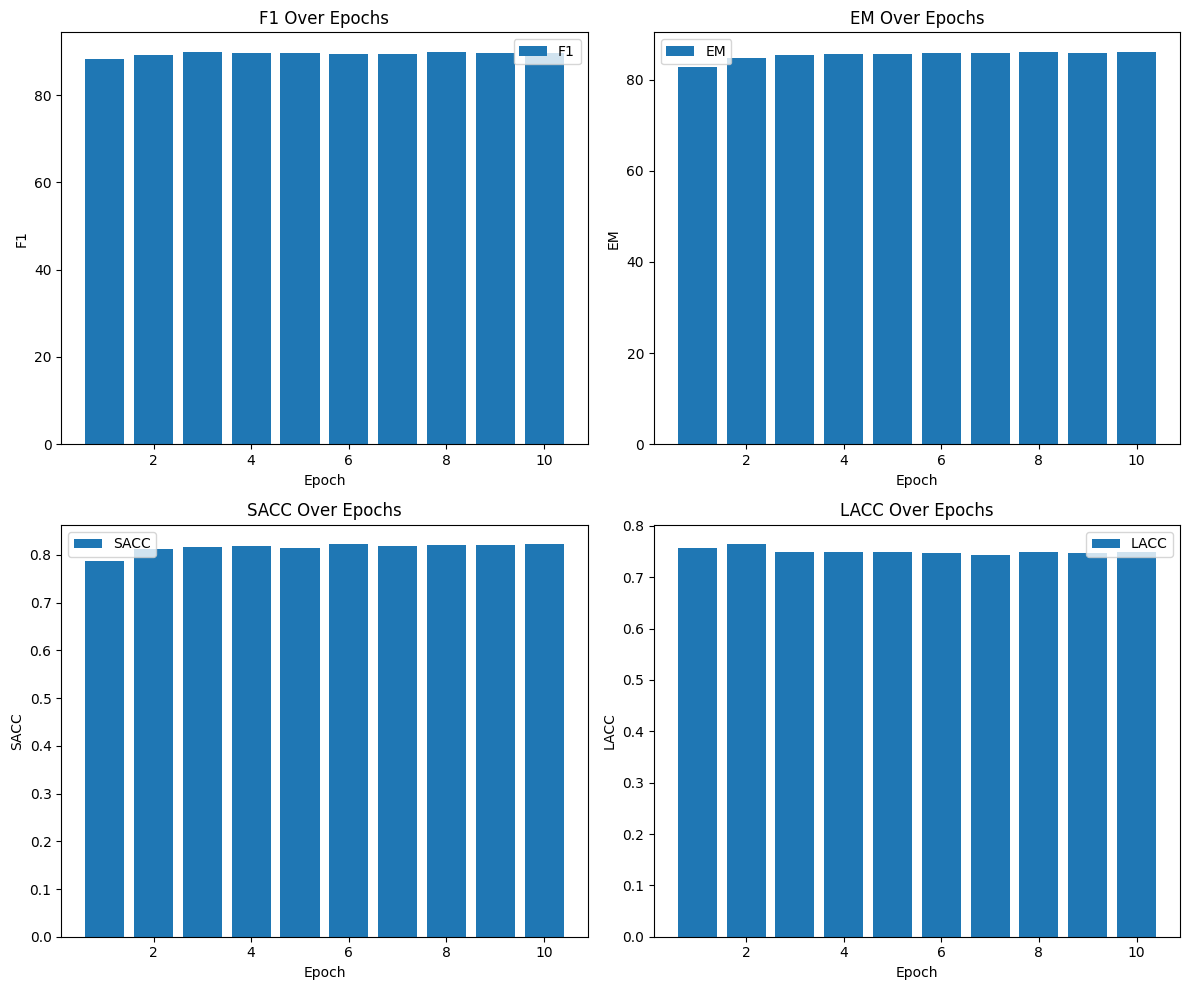

100%|██████████| 5450/5450 [11:42<00:00,  7.75it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:49,  8.32it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:07:36,  1.56s/it]

Epoch 0 Metrics:
Training Loss: 1.1422688885976415
EM: 83.11926605504587
F1: 88.10488731878344
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.7926605504587156


 20%|█▉        | 1089/5450 [02:14<08:26,  8.60it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.14it/s]


Epoch 1 Metrics:
Training Loss: 0.3567501703448115
EM: 84.77064220183486
F1: 88.97961099410072
MRR: 0.0021406727828746173
Lacc: 0.7587155963302752
Sacc: 0.8018348623853211


 30%|██▉       | 1634/5450 [03:25<07:28,  8.50it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:03,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.24812167578573346
EM: 85.59633027522936
F1: 89.03358672408366
MRR: 0.0012996941896024465
Lacc: 0.755045871559633
Sacc: 0.8110091743119267


 40%|███▉      | 2179/5450 [04:35<06:27,  8.44it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:41<1:25:00,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.20613238267288672
EM: 86.05504587155963
F1: 89.94096105440993
MRR: 0.0021406727828746173
Lacc: 0.7596330275229358
Sacc: 0.8165137614678899


 50%|████▉     | 2724/5450 [05:45<05:18,  8.55it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:51<1:10:37,  1.56s/it]

Epoch 4 Metrics:
Training Loss: 0.18048289358143807
EM: 86.05504587155963
F1: 89.68177284894684
MRR: 0.0012996941896024465
Lacc: 0.755045871559633
Sacc: 0.8165137614678899


 60%|█████▉    | 3269/5450 [06:55<04:23,  8.28it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<56:46,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16780950014037294
EM: 85.3211009174312
F1: 89.03037630195796
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.808256880733945


 70%|██████▉   | 3814/5450 [08:06<03:09,  8.61it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:12<42:32,  1.56s/it]

Epoch 6 Metrics:
Training Loss: 0.14985395876301982
EM: 85.04587155963303
F1: 88.54846110029426
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.8064220183486238


 80%|███████▉  | 4359/5450 [09:16<02:08,  8.50it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:22<28:13,  1.56s/it]

Epoch 7 Metrics:
Training Loss: 0.1480826807941829
EM: 84.95412844036697
F1: 88.50742862486632
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8073394495412844


 90%|████████▉ | 4904/5450 [10:26<01:03,  8.62it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:32<14:05,  1.55s/it]

Epoch 8 Metrics:
Training Loss: 0.137212054899396
EM: 85.5045871559633
F1: 89.00157889899646
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.8119266055045872


100%|█████████▉| 5449/5450 [11:37<00:00,  8.40it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.94it/s]


Epoch 9 Metrics:
Training Loss: 0.13099379896230615
EM: 85.41284403669725
F1: 88.87380333723604
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.810091743119266
EM - Highest: 86.05504587155963, Lowest: 83.11926605504587, Average: 85.18348623853213
F1 - Highest: 89.94096105440993, Lowest: 88.10488731878344, Average: 88.97024672036757
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0014678899082568807
Lacc - Highest: 0.7596330275229358, Lowest: 0.7454128440366973, Average: 0.7522477064220183
Sacc - Highest: 0.8165137614678899, Lowest: 0.7926605504587156, Average: 0.8082568807339451


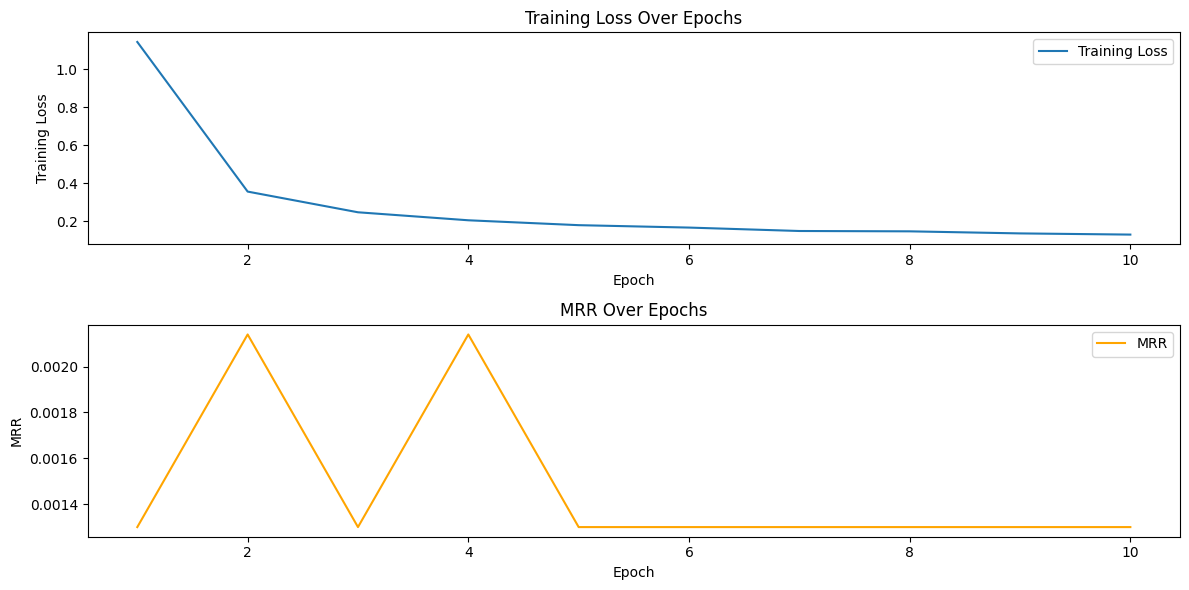

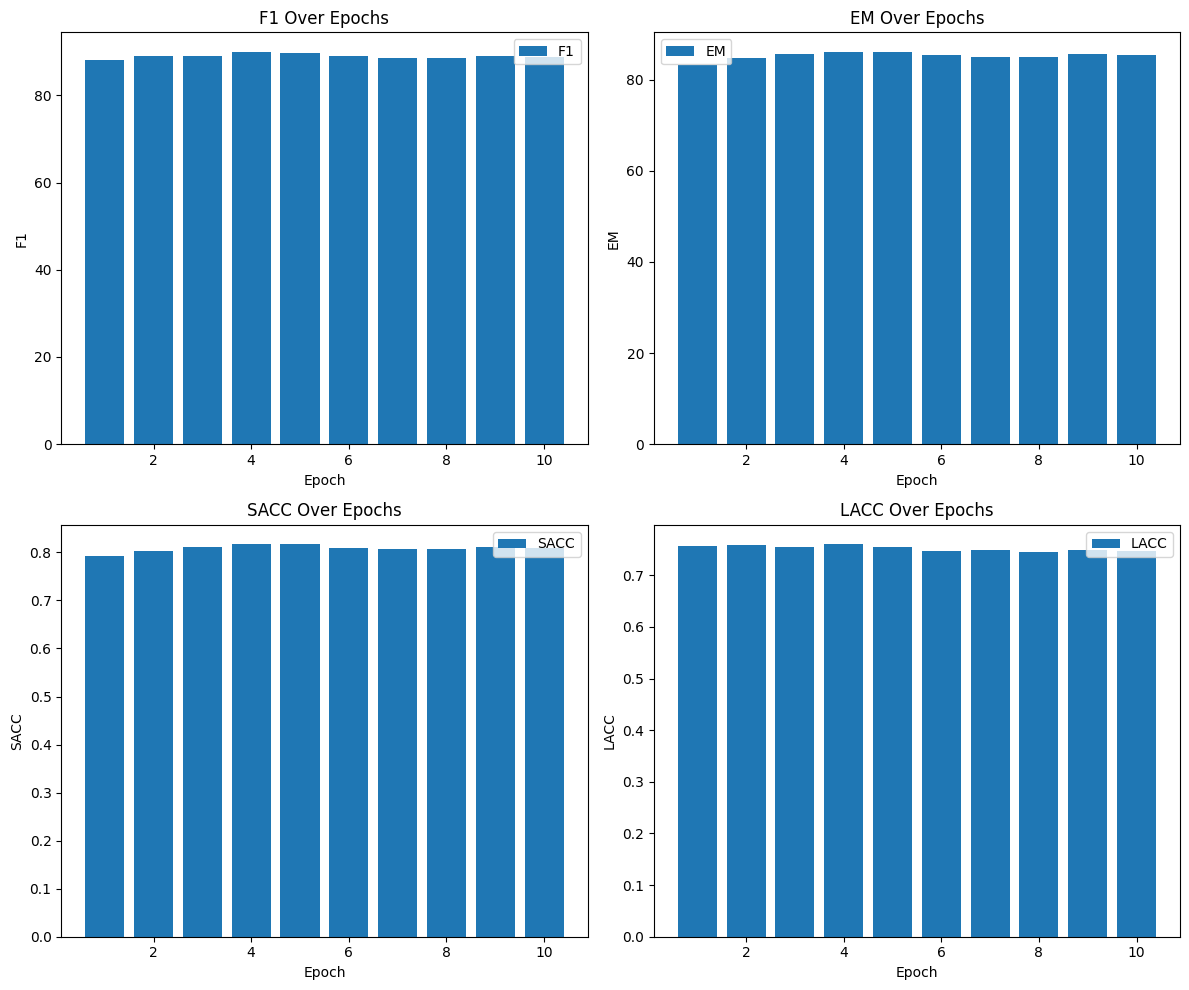

100%|██████████| 5450/5450 [11:44<00:00,  7.73it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:05<09:40,  8.45it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.97it/s]


Epoch 0 Metrics:
Training Loss: 1.1646046790644664
EM: 83.11926605504587
F1: 88.5749437104904
MRR: 0.0012996941896024465
Lacc: 0.7605504587155963
Sacc: 0.789908256880734


 20%|█▉        | 1089/5450 [02:16<08:30,  8.54it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:22<1:54:02,  1.57s/it]

Epoch 1 Metrics:
Training Loss: 0.3659962207830827
EM: 84.77064220183486
F1: 89.2852357493038
MRR: 0.0021406727828746173
Lacc: 0.7688073394495413
Sacc: 0.808256880733945


 30%|██▉       | 1634/5450 [03:26<07:30,  8.47it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 2 Metrics:
Training Loss: 0.24968911744120165
EM: 87.79816513761467
F1: 91.10618233455155
MRR: 0.0021406727828746173
Lacc: 0.7660550458715596
Sacc: 0.8385321100917431


 40%|███▉      | 2179/5450 [04:36<06:24,  8.50it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:43<1:25:58,  1.58s/it]

Epoch 3 Metrics:
Training Loss: 0.20646675887726965
EM: 88.34862385321101
F1: 91.68785064415036
MRR: 0.0038226299694189606
Lacc: 0.7770642201834862
Sacc: 0.8440366972477065


 50%|████▉     | 2724/5450 [05:47<05:23,  8.42it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:53<1:11:04,  1.57s/it]

Epoch 4 Metrics:
Training Loss: 0.18316439693674036
EM: 87.1559633027523
F1: 90.92802721180998
MRR: 0.0021406727828746173
Lacc: 0.7568807339449541
Sacc: 0.8330275229357799


 60%|█████▉    | 3269/5450 [06:57<04:16,  8.50it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.98it/s]


Epoch 5 Metrics:
Training Loss: 0.165896106957898
EM: 87.43119266055047
F1: 91.05475741007581
MRR: 0.002981651376146789
Lacc: 0.7614678899082569
Sacc: 0.8348623853211009


 70%|██████▉   | 3814/5450 [08:08<03:11,  8.56it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.06it/s]


Epoch 6 Metrics:
Training Loss: 0.15823919151577492
EM: 87.06422018348624
F1: 90.91185927076359
MRR: 0.0021406727828746173
Lacc: 0.7568807339449541
Sacc: 0.8330275229357799


 80%|███████▉  | 4359/5450 [09:19<02:07,  8.56it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:25<28:26,  1.57s/it]

Epoch 7 Metrics:
Training Loss: 0.14765551062525087
EM: 87.61467889908256
F1: 90.99872344718229
MRR: 0.002981651376146789
Lacc: 0.7665137614678899
Sacc: 0.8357798165137614


 90%|████████▉ | 4904/5450 [10:29<01:03,  8.58it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:36<14:08,  1.56s/it]

Epoch 8 Metrics:
Training Loss: 0.14103218775863094
EM: 87.5229357798165
F1: 91.05922813446728
MRR: 0.002981651376146789
Lacc: 0.7651376146788991
Sacc: 0.8357798165137614


100%|█████████▉| 5449/5450 [11:40<00:00,  8.59it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.00it/s]


Epoch 9 Metrics:
Training Loss: 0.1354904272247249
EM: 87.33944954128441
F1: 90.8111842819043
MRR: 0.002981651376146789
Lacc: 0.7605504587155963
Sacc: 0.8339449541284404
EM - Highest: 88.34862385321101, Lowest: 83.11926605504587, Average: 86.8165137614679
F1 - Highest: 91.68785064415036, Lowest: 88.5749437104904, Average: 90.64179921946995
MRR - Highest: 0.0038226299694189606, Lowest: 0.0012996941896024465, Average: 0.0025611620795107032
Lacc - Highest: 0.7770642201834862, Lowest: 0.7568807339449541, Average: 0.7639908256880734
Sacc - Highest: 0.8440366972477065, Lowest: 0.789908256880734, Average: 0.8287155963302751


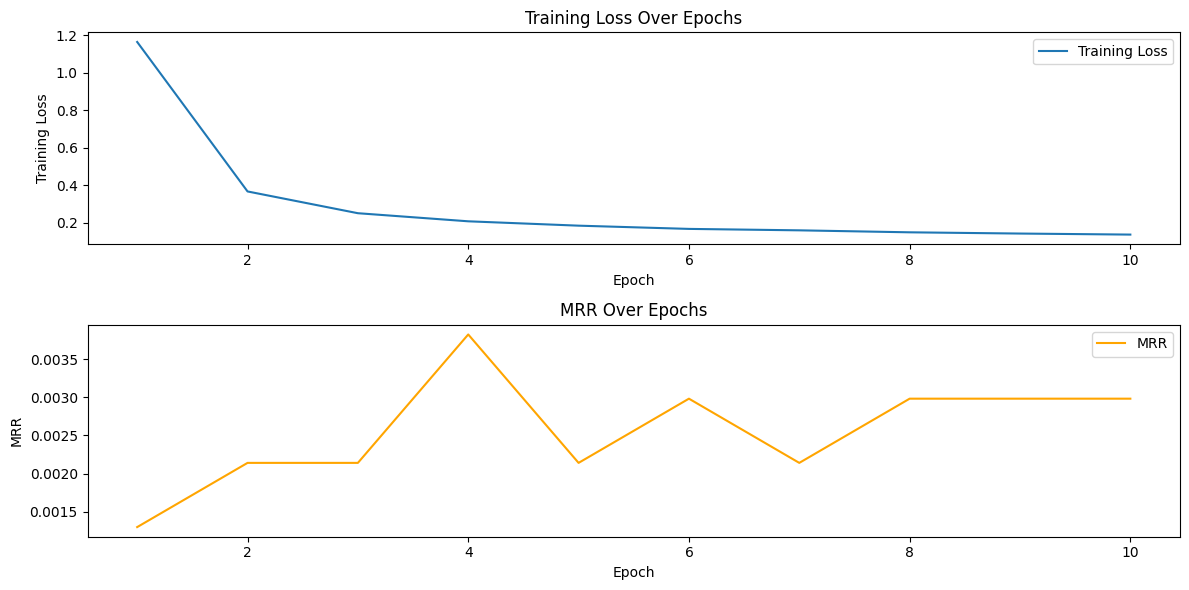

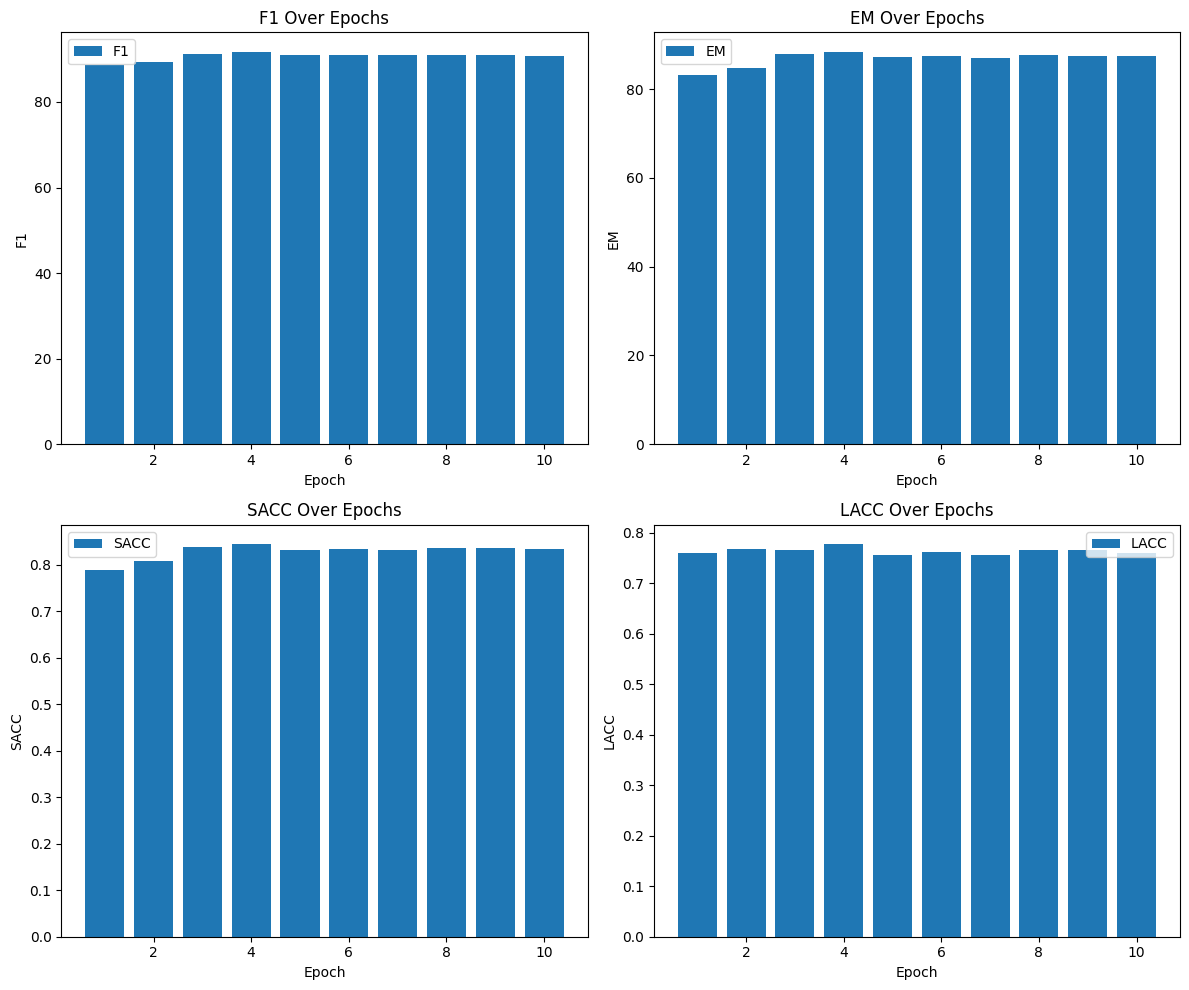

100%|██████████| 5450/5450 [11:47<00:00,  7.70it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:40,  8.46it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 0 Metrics:
Training Loss: 1.1572175370033728
EM: 81.74311926605505
F1: 87.73017269644912
MRR: 0.0012996941896024465
Lacc: 0.7568807339449541
Sacc: 0.7779816513761468


 20%|█▉        | 1089/5450 [02:15<08:30,  8.54it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 1 Metrics:
Training Loss: 0.3586082954087867
EM: 85.59633027522936
F1: 89.91330153143913
MRR: 0.0012996941896024465
Lacc: 0.7605504587155963
Sacc: 0.8155963302752294


 30%|██▉       | 1634/5450 [03:25<07:27,  8.53it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:40:08,  1.58s/it]

Epoch 2 Metrics:
Training Loss: 0.2599765904217856
EM: 86.23853211009174
F1: 90.70688925033075
MRR: 0.002981651376146789
Lacc: 0.7559633027522936
Sacc: 0.8229357798165138


 40%|███▉      | 2179/5450 [04:35<06:19,  8.62it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.08it/s]


Epoch 3 Metrics:
Training Loss: 0.2157045398204408
EM: 86.5137614678899
F1: 90.01517580760188
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8201834862385321


 50%|████▉     | 2724/5450 [05:46<05:19,  8.53it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:11:07,  1.57s/it]

Epoch 4 Metrics:
Training Loss: 0.19794377770217203
EM: 87.1559633027523
F1: 90.33125912875522
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.828440366972477


 60%|█████▉    | 3269/5450 [06:57<04:17,  8.46it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:03<56:57,  1.57s/it]

Epoch 5 Metrics:
Training Loss: 0.1785339587408656
EM: 86.14678899082568
F1: 90.08243030832688
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8211009174311926


 70%|██████▉   | 3814/5450 [08:07<03:11,  8.55it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:14<42:40,  1.57s/it]

Epoch 6 Metrics:
Training Loss: 0.1599237338961807
EM: 86.97247706422019
F1: 90.6913186969126
MRR: 0.0012996941896024465
Lacc: 0.7573394495412844
Sacc: 0.8293577981651377


 80%|███████▉  | 4359/5450 [09:18<02:07,  8.57it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:24<29:01,  1.60s/it]

Epoch 7 Metrics:
Training Loss: 0.15223420984656422
EM: 87.24770642201835
F1: 90.67464358093903
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8302752293577982


 90%|████████▉ | 4904/5450 [10:28<01:03,  8.57it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:35<14:06,  1.56s/it]

Epoch 8 Metrics:
Training Loss: 0.14265823720750365
EM: 87.88990825688073
F1: 91.06870212178657
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8366972477064221


100%|█████████▉| 5449/5450 [11:39<00:00,  8.52it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.05it/s]


Epoch 9 Metrics:
Training Loss: 0.13960262502360996
EM: 87.33944954128441
F1: 90.52799512236398
MRR: 0.0012996941896024465
Lacc: 0.7527522935779817
Sacc: 0.8330275229357799
EM - Highest: 87.88990825688073, Lowest: 81.74311926605505, Average: 86.28440366972477
F1 - Highest: 91.06870212178657, Lowest: 87.73017269644912, Average: 90.17418882449053
MRR - Highest: 0.002981651376146789, Lowest: 0.0012996941896024465, Average: 0.0014678899082568807
Lacc - Highest: 0.7605504587155963, Lowest: 0.7477064220183486, Average: 0.7536238532110092
Sacc - Highest: 0.8366972477064221, Lowest: 0.7779816513761468, Average: 0.8215596330275229


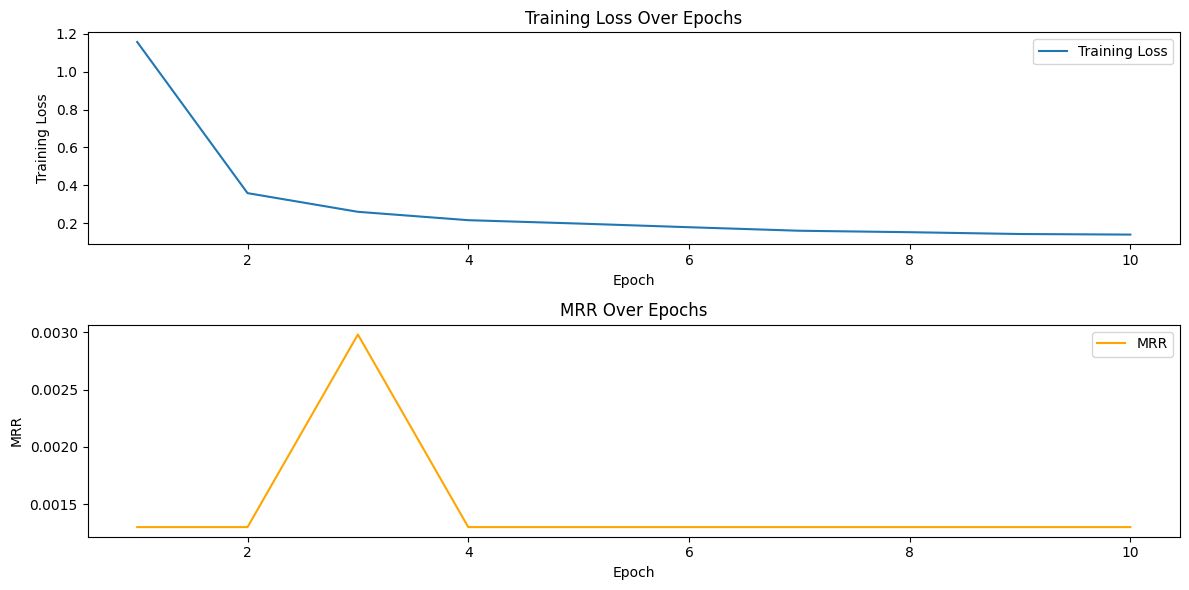

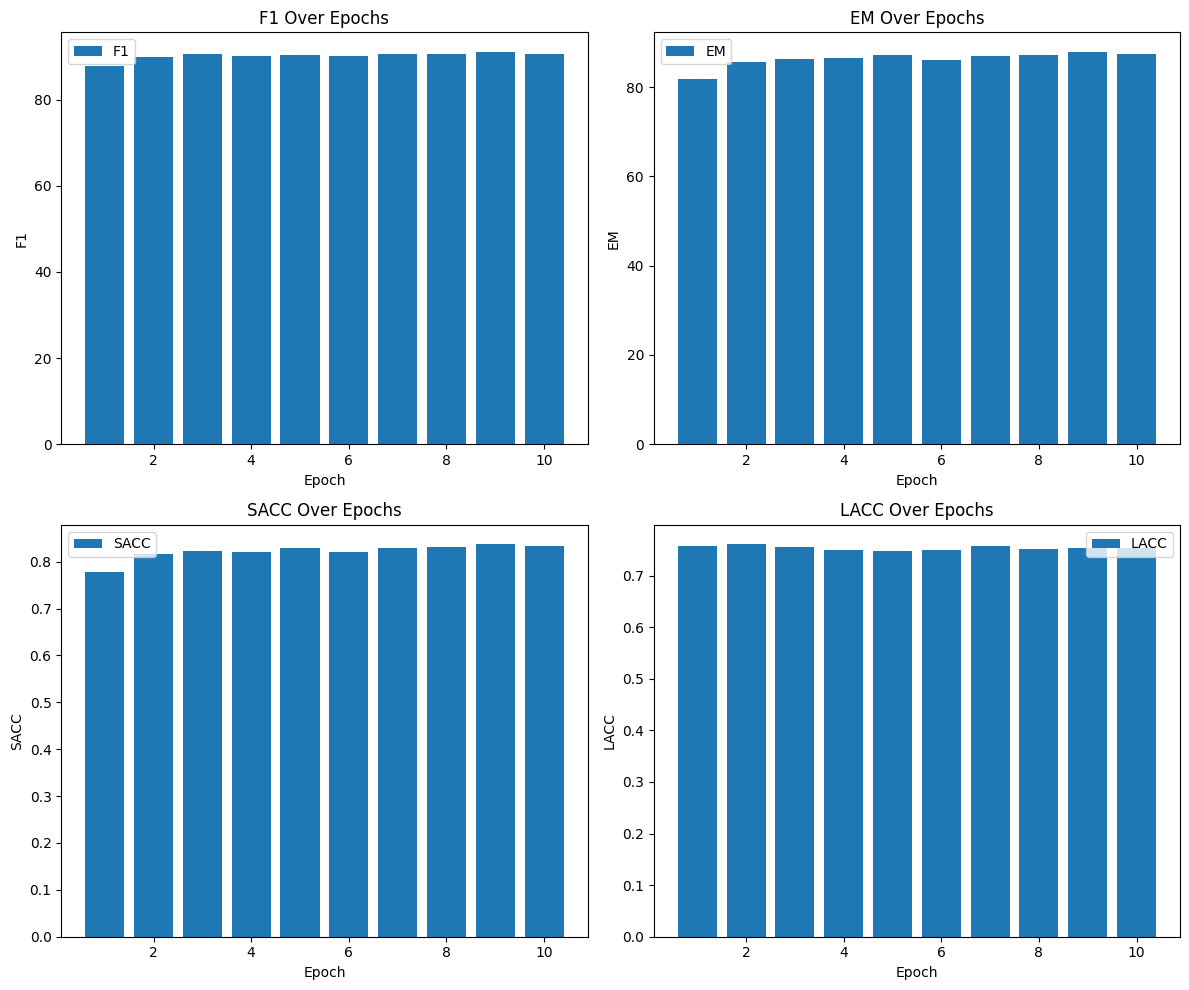

100%|██████████| 5450/5450 [11:46<00:00,  7.71it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:38,  8.48it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:08:30,  1.57s/it]

Epoch 0 Metrics:
Training Loss: 1.172010178617928
EM: 84.12844036697248
F1: 88.80922278103789
MRR: 0.0012996941896024465
Lacc: 0.7651376146788991
Sacc: 0.8


 20%|█▉        | 1089/5450 [02:14<08:33,  8.49it/s] 

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.03it/s]


Epoch 1 Metrics:
Training Loss: 0.3491390214053863
EM: 85.41284403669725
F1: 89.86109203778825
MRR: 0.0012996941896024465
Lacc: 0.771559633027523
Sacc: 0.8146788990825689


 30%|██▉       | 1634/5450 [03:25<07:32,  8.44it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:23,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.24618238532625208
EM: 87.06422018348624
F1: 90.91318182792732
MRR: 0.0012996941896024465
Lacc: 0.7555045871559632
Sacc: 0.8220183486238533


 40%|███▉      | 2179/5450 [04:35<06:22,  8.56it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:42<1:26:13,  1.58s/it]

Epoch 3 Metrics:
Training Loss: 0.20151691016081055
EM: 87.43119266055047
F1: 90.56477216730549
MRR: 0.002981651376146789
Lacc: 0.7591743119266054
Sacc: 0.8293577981651377


 50%|████▉     | 2724/5450 [05:45<05:25,  8.38it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:11:13,  1.57s/it]

Epoch 4 Metrics:
Training Loss: 0.18291301889347186
EM: 86.42201834862385
F1: 90.07020563960633
MRR: 0.002981651376146789
Lacc: 0.7504587155963303
Sacc: 0.8201834862385321


 60%|█████▉    | 3269/5450 [06:56<04:14,  8.58it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<56:35,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16472001341299727
EM: 87.24770642201835
F1: 90.57125078792332
MRR: 0.0021406727828746173
Lacc: 0.7490825688073395
Sacc: 0.8247706422018348


 70%|██████▉   | 3814/5450 [08:07<03:13,  8.46it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:13<42:47,  1.57s/it]

Epoch 6 Metrics:
Training Loss: 0.15508333286270498
EM: 86.42201834862385
F1: 89.7747581040957
MRR: 0.002981651376146789
Lacc: 0.7490825688073395
Sacc: 0.8165137614678899


 80%|███████▉  | 4359/5450 [09:17<02:08,  8.50it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.01it/s]


Epoch 7 Metrics:
Training Loss: 0.14896022961063762
EM: 86.42201834862385
F1: 89.97438147626717
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.8174311926605504


 90%|████████▉ | 4904/5450 [10:27<01:03,  8.54it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:34<14:17,  1.58s/it]

Epoch 8 Metrics:
Training Loss: 0.14054349902493948
EM: 86.5137614678899
F1: 89.97370700721994
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8220183486238533


100%|█████████▉| 5449/5450 [11:38<00:00,  8.44it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.03it/s]


Epoch 9 Metrics:
Training Loss: 0.13184708898930828
EM: 86.97247706422019
F1: 90.38436668393469
MRR: 0.0021406727828746173
Lacc: 0.7509174311926605
Sacc: 0.826605504587156
EM - Highest: 87.43119266055047, Lowest: 84.12844036697248, Average: 86.40366972477065
F1 - Highest: 90.91318182792732, Lowest: 88.80922278103789, Average: 90.0896938513106
MRR - Highest: 0.002981651376146789, Lowest: 0.0012996941896024465, Average: 0.0019724770642201837
Lacc - Highest: 0.771559633027523, Lowest: 0.7472477064220183, Average: 0.7549082568807339
Sacc - Highest: 0.8293577981651377, Lowest: 0.8, Average: 0.8193577981651377


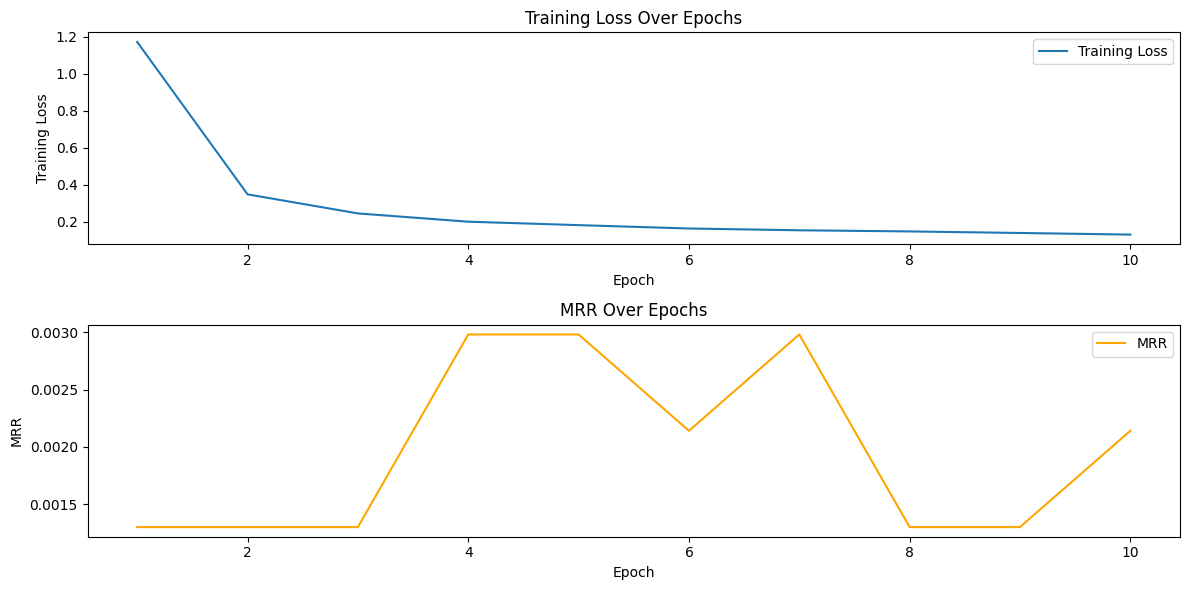

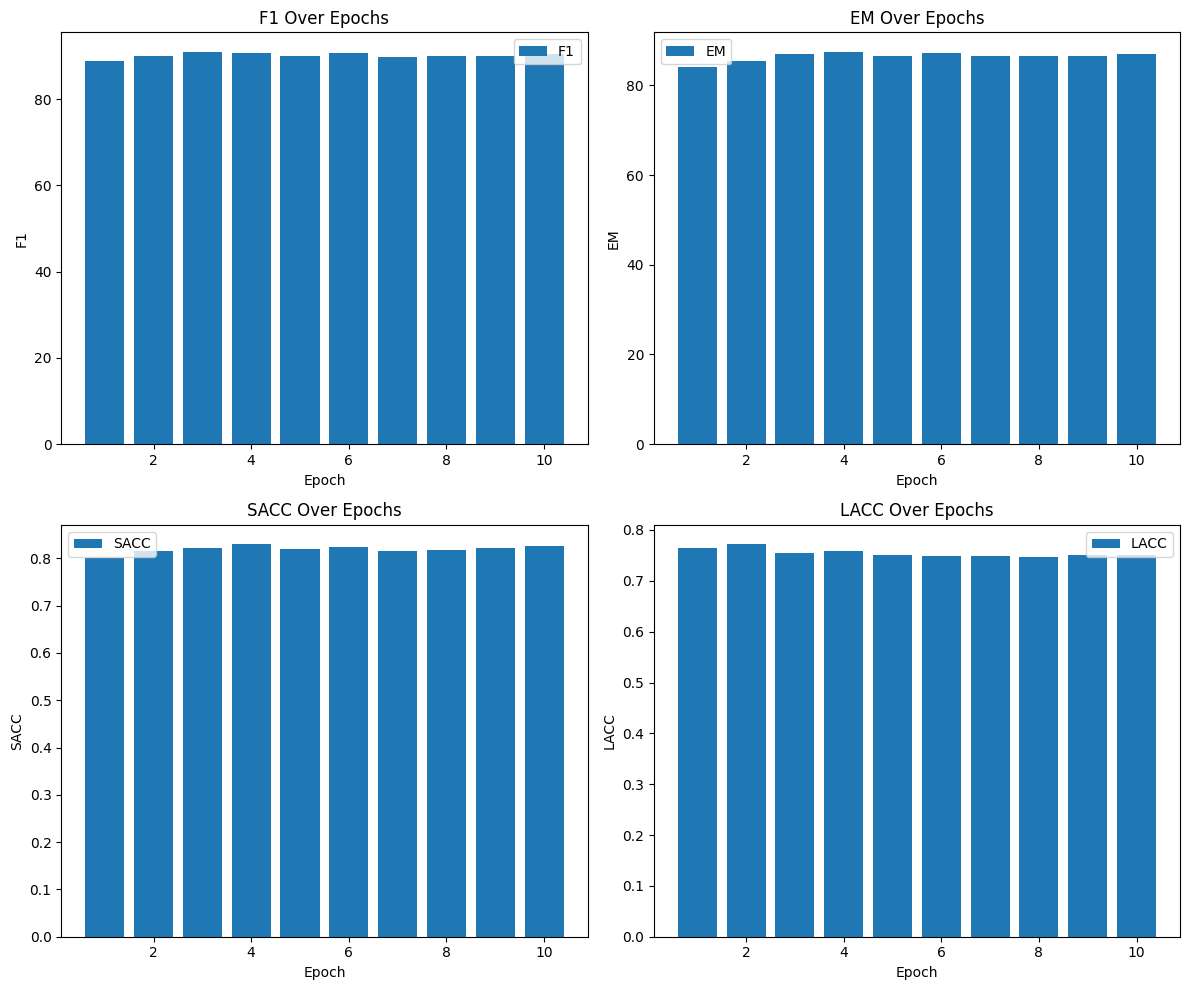

100%|██████████| 5450/5450 [11:45<00:00,  7.72it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:45,  8.37it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:07:41,  1.56s/it]

Epoch 0 Metrics:
Training Loss: 1.1917698238284216
EM: 82.4770642201835
F1: 87.85696835071803
MRR: 0.0012996941896024465
Lacc: 0.7582568807339449
Sacc: 0.7844036697247706


 20%|█▉        | 1089/5450 [02:14<08:37,  8.43it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:21<1:53:37,  1.56s/it]

Epoch 1 Metrics:
Training Loss: 0.3549468291086068
EM: 85.22935779816514
F1: 89.48298587157178
MRR: 0.0012996941896024465
Lacc: 0.7568807339449541
Sacc: 0.8073394495412844


 30%|██▉       | 1634/5450 [03:25<07:30,  8.46it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:19,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.2518888877892713
EM: 85.13761467889908
F1: 89.32846655866068
MRR: 0.0012996941896024465
Lacc: 0.755045871559633
Sacc: 0.808256880733945


 40%|███▉      | 2179/5450 [04:35<06:25,  8.49it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:41<1:24:56,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.2121341407269137
EM: 85.68807339449542
F1: 89.80221121359799
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8119266055045872


 50%|████▉     | 2724/5450 [05:45<05:22,  8.44it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:11:40,  1.58s/it]

Epoch 4 Metrics:
Training Loss: 0.18903060929300777
EM: 86.5137614678899
F1: 90.02395126696953
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8165137614678899


 60%|█████▉    | 3269/5450 [06:56<04:19,  8.39it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<56:39,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16679871794255025
EM: 85.77981651376147
F1: 89.2193633311648
MRR: 0.0012996941896024465
Lacc: 0.7440366972477064
Sacc: 0.8091743119266055


 70%|██████▉   | 3814/5450 [08:06<03:12,  8.49it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:13<42:24,  1.56s/it]

Epoch 6 Metrics:
Training Loss: 0.15860835296174494
EM: 86.78899082568807
F1: 90.22782069499182
MRR: 0.0012996941896024465
Lacc: 0.7444954128440368
Sacc: 0.8201834862385321


 80%|███████▉  | 4359/5450 [09:17<02:06,  8.59it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:23<28:31,  1.57s/it]

Epoch 7 Metrics:
Training Loss: 0.1457238594215596
EM: 85.68807339449542
F1: 89.60425280947318
MRR: 0.0012996941896024465
Lacc: 0.7385321100917431
Sacc: 0.8119266055045872


 90%|████████▉ | 4904/5450 [10:27<01:05,  8.33it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:33<14:09,  1.56s/it]

Epoch 8 Metrics:
Training Loss: 0.14259486952364026
EM: 86.42201834862385
F1: 90.15213545201028
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.8155963302752294


100%|█████████▉| 5449/5450 [11:37<00:00,  8.52it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.04it/s]


Epoch 9 Metrics:
Training Loss: 0.13293045817221805
EM: 86.14678899082568
F1: 89.85943121435191
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8137614678899082
EM - Highest: 86.78899082568807, Lowest: 82.4770642201835, Average: 85.58715596330275
F1 - Highest: 90.22782069499182, Lowest: 87.85696835071803, Average: 89.555758676351
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7582568807339449, Lowest: 0.7385321100917431, Average: 0.7493577981651376
Sacc - Highest: 0.8201834862385321, Lowest: 0.7844036697247706, Average: 0.809908256880734


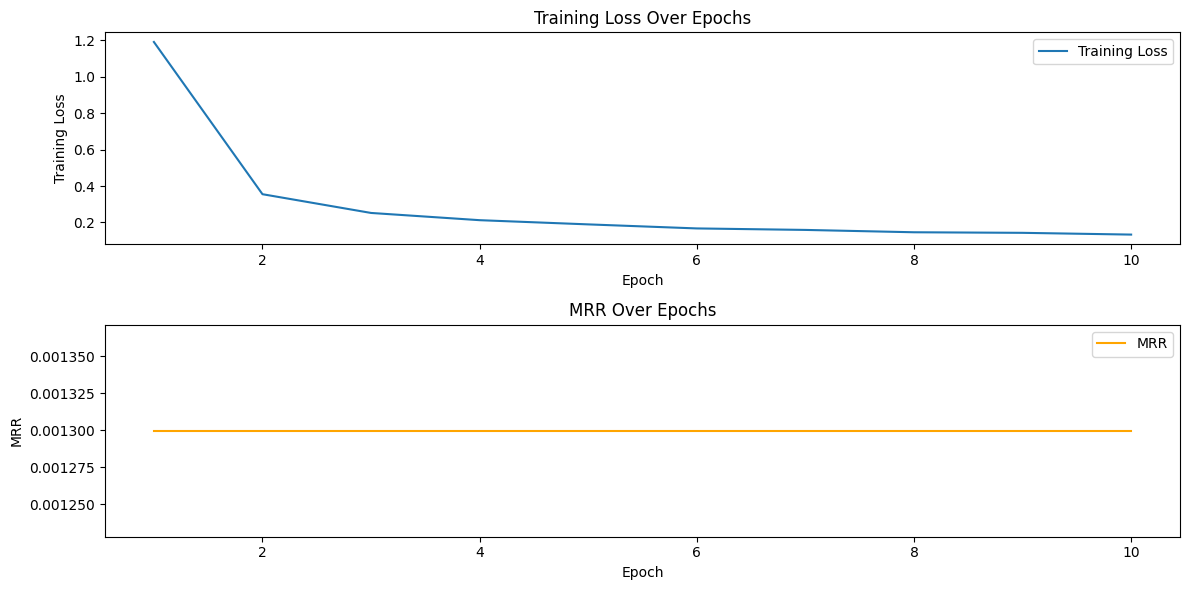

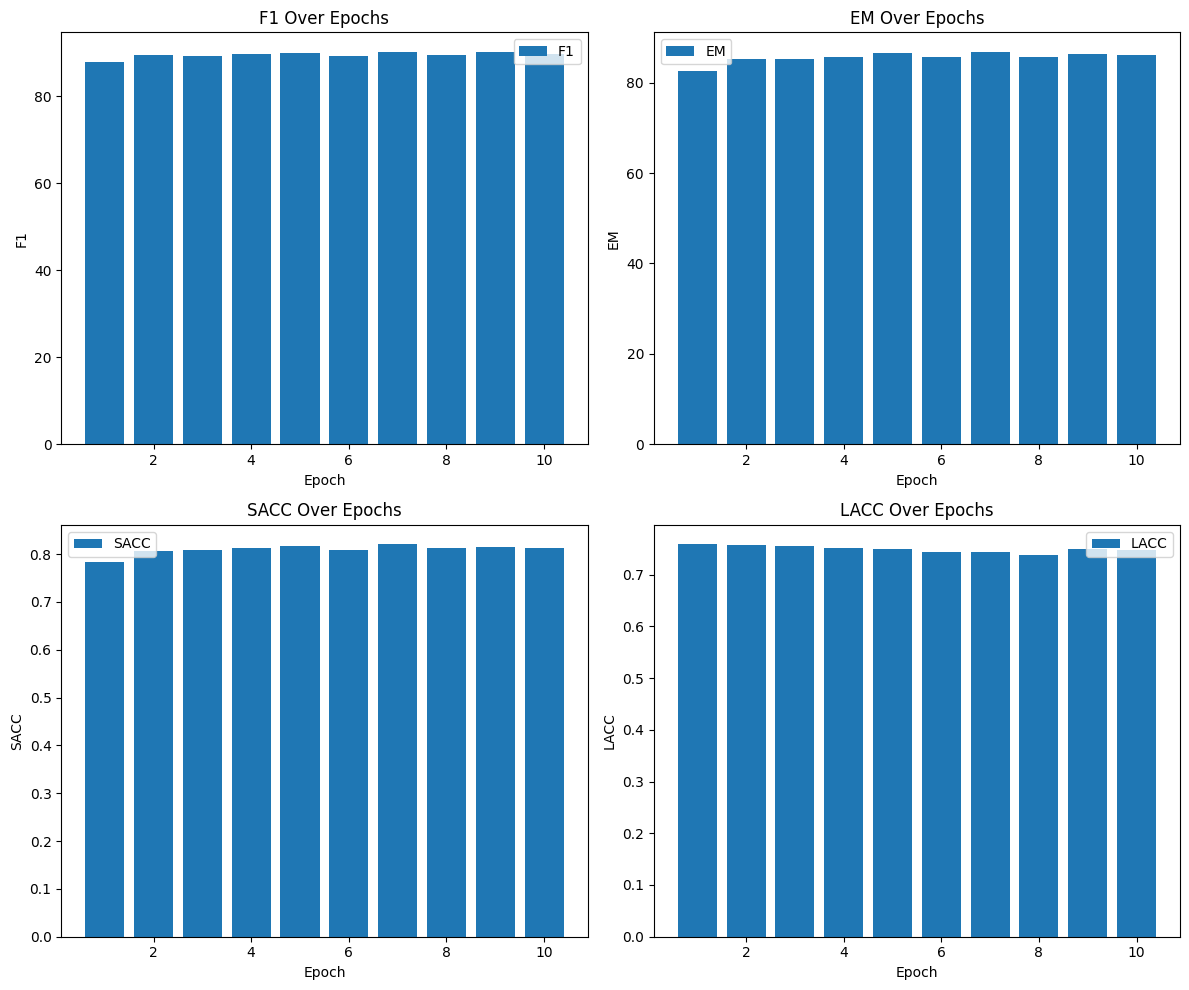

100%|██████████| 5450/5450 [11:45<00:00,  7.73it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:36,  8.51it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:08:28,  1.57s/it]

Epoch 0 Metrics:
Training Loss: 1.1836424669267935
EM: 81.55963302752293
F1: 87.49199809431835
MRR: 0.0012996941896024465
Lacc: 0.7555045871559632
Sacc: 0.7770642201834862


 20%|█▉        | 1089/5450 [02:15<08:33,  8.49it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:21<1:55:09,  1.59s/it]

Epoch 1 Metrics:
Training Loss: 0.3539564474148317
EM: 85.3211009174312
F1: 89.76782272230679
MRR: 0.0012996941896024465
Lacc: 0.7660550458715596
Sacc: 0.8091743119266055


 30%|██▉       | 1634/5450 [03:25<07:25,  8.57it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.12it/s]


Epoch 2 Metrics:
Training Loss: 0.252421453642582
EM: 84.6788990825688
F1: 89.1675649603019
MRR: 0.0012996941896024465
Lacc: 0.7513761467889908
Sacc: 0.8018348623853211


 40%|███▉      | 2179/5450 [04:36<06:30,  8.37it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:42<1:25:03,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.20059241667804265
EM: 85.77981651376147
F1: 89.95794244613214
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.8091743119266055


 50%|████▉     | 2724/5450 [05:46<05:18,  8.55it/s]  

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 4 Metrics:
Training Loss: 0.17856963005049342
EM: 86.42201834862385
F1: 90.33518836385295
MRR: 0.0012996941896024465
Lacc: 0.7440366972477064
Sacc: 0.8174311926605504


 60%|█████▉    | 3269/5450 [06:56<04:20,  8.37it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:03<56:46,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16119865630230004
EM: 86.69724770642202
F1: 90.53071620013962
MRR: 0.0021406727828746173
Lacc: 0.7444954128440368
Sacc: 0.8229357798165138


 70%|██████▉   | 3814/5450 [08:07<03:14,  8.43it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:13<42:34,  1.56s/it]

Epoch 6 Metrics:
Training Loss: 0.1499046358848076
EM: 86.42201834862385
F1: 90.18236158060311
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8192660550458716


 80%|███████▉  | 4359/5450 [09:17<02:07,  8.58it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:24<28:20,  1.56s/it]

Epoch 7 Metrics:
Training Loss: 0.1400656133261349
EM: 85.96330275229357
F1: 89.91773114597808
MRR: 0.0021406727828746173
Lacc: 0.7454128440366973
Sacc: 0.8128440366972477


 90%|████████▉ | 4904/5450 [10:27<01:05,  8.29it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.03it/s]


Epoch 8 Metrics:
Training Loss: 0.12944676288280213
EM: 86.23853211009174
F1: 90.08476044093462
MRR: 0.0021406727828746173
Lacc: 0.7454128440366973
Sacc: 0.8155963302752294


100%|█████████▉| 5449/5450 [11:37<00:00,  8.50it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.04it/s]


Epoch 9 Metrics:
Training Loss: 0.12604396401139814
EM: 85.59633027522936
F1: 89.64620427122568
MRR: 0.0021406727828746173
Lacc: 0.7412844036697248
Sacc: 0.810091743119266
EM - Highest: 86.69724770642202, Lowest: 81.55963302752293, Average: 85.46788990825686
F1 - Highest: 90.53071620013962, Lowest: 87.49199809431835, Average: 89.70822902257932
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0016360856269113148
Lacc - Highest: 0.7660550458715596, Lowest: 0.7412844036697248, Average: 0.7486238532110091
Sacc - Highest: 0.8229357798165138, Lowest: 0.7770642201834862, Average: 0.8095412844036698


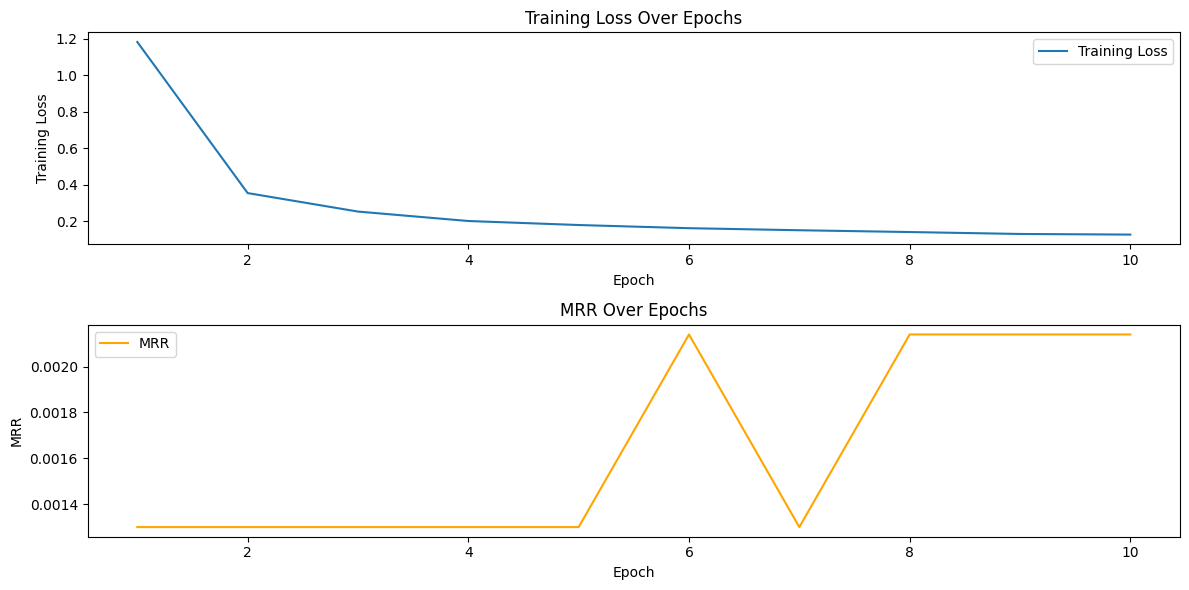

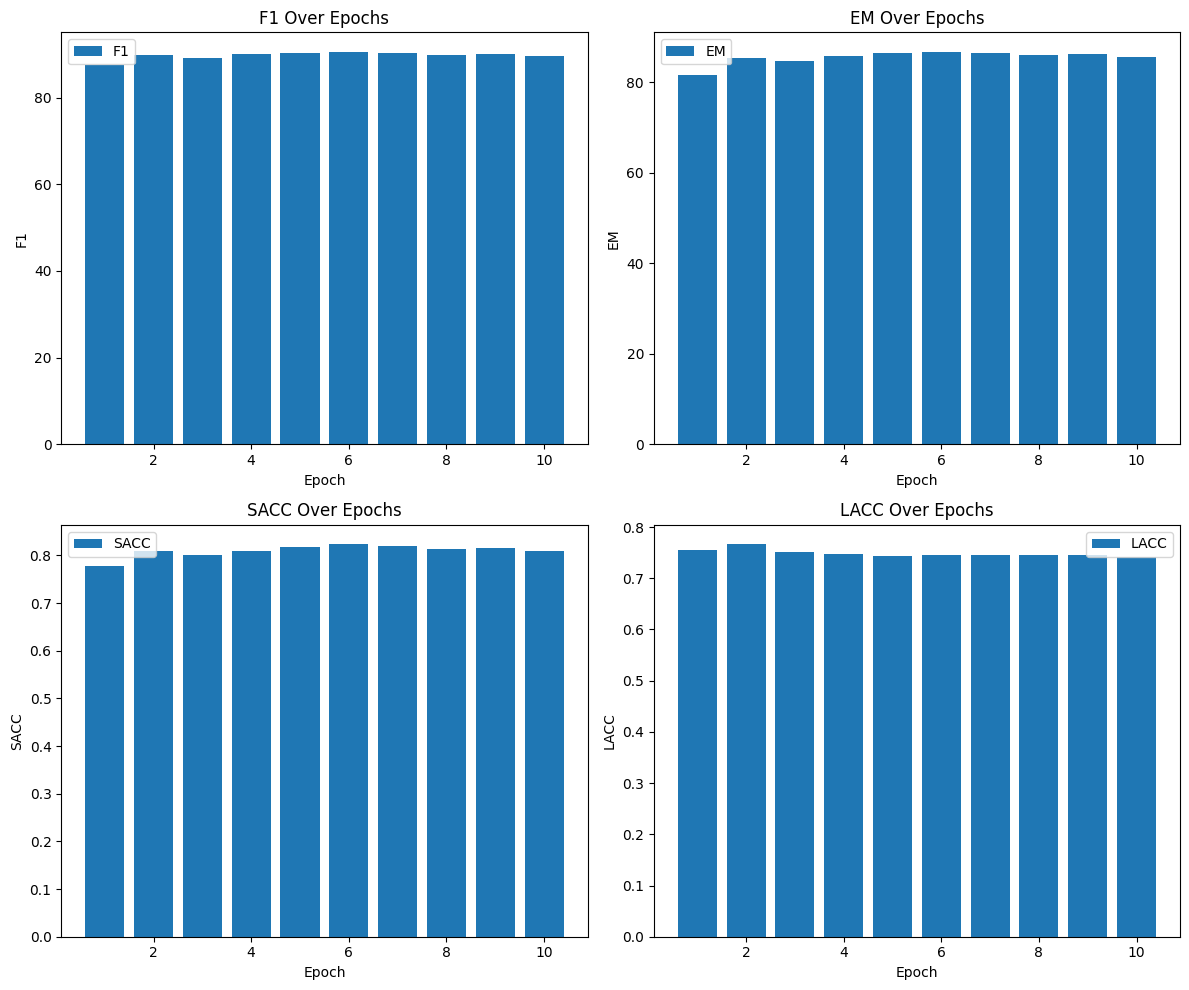

100%|██████████| 5450/5450 [11:45<00:00,  7.72it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:33,  8.56it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.06it/s]


Epoch 0 Metrics:
Training Loss: 1.166815642014556
EM: 82.01834862385321
F1: 87.98688640031975
MRR: 0.0038226299694189597
Lacc: 0.7440366972477064
Sacc: 0.7761467889908257


 20%|█▉        | 1089/5450 [02:14<08:30,  8.54it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:21<1:53:27,  1.56s/it]

Epoch 1 Metrics:
Training Loss: 0.3538528790338597
EM: 84.77064220183486
F1: 89.43636998573726
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.8064220183486238


 30%|██▉       | 1634/5450 [03:25<07:26,  8.55it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:13,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.23559245278059138
EM: 87.70642201834862
F1: 90.87510135322202
MRR: 0.0038226299694189597
Lacc: 0.763302752293578
Sacc: 0.8293577981651377


 40%|███▉      | 2179/5450 [04:35<06:22,  8.54it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:41<1:25:02,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.20012365366896154
EM: 86.23853211009174
F1: 89.89560463127503
MRR: 0.0012996941896024465
Lacc: 0.7463302752293578
Sacc: 0.8174311926605504


 50%|████▉     | 2724/5450 [05:45<05:17,  8.59it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:10:47,  1.56s/it]

Epoch 4 Metrics:
Training Loss: 0.17861046562496777
EM: 86.60550458715596
F1: 90.15302095973055
MRR: 0.0012996941896024465
Lacc: 0.7431192660550459
Sacc: 0.8220183486238533


 60%|█████▉    | 3269/5450 [06:55<04:20,  8.36it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<58:19,  1.61s/it]

Epoch 5 Metrics:
Training Loss: 0.1621481854576455
EM: 86.14678899082568
F1: 89.63139425090169
MRR: 0.0012996941896024465
Lacc: 0.7435779816513761
Sacc: 0.8165137614678899


 70%|██████▉   | 3814/5450 [08:06<03:12,  8.52it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 6 Metrics:
Training Loss: 0.152758834804216
EM: 86.97247706422019
F1: 90.15971149940242
MRR: 0.0012996941896024465
Lacc: 0.7399082568807339
Sacc: 0.826605504587156


 80%|███████▉  | 4359/5450 [09:17<02:07,  8.57it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:24<28:13,  1.56s/it]

Epoch 7 Metrics:
Training Loss: 0.14389205106551153
EM: 85.87155963302752
F1: 89.22943229848102
MRR: 0.0012996941896024465
Lacc: 0.7321100917431193
Sacc: 0.8174311926605504


 90%|████████▉ | 4904/5450 [10:27<01:04,  8.50it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:34<14:06,  1.56s/it]

Epoch 8 Metrics:
Training Loss: 0.13694548267084003
EM: 86.5137614678899
F1: 89.94804701709576
MRR: 0.0012996941896024465
Lacc: 0.7385321100917431
Sacc: 0.8201834862385321


100%|█████████▉| 5449/5450 [11:38<00:00,  8.59it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.18it/s]


Epoch 9 Metrics:
Training Loss: 0.1316016532732505
EM: 86.3302752293578
F1: 89.81725426244977
MRR: 0.0021406727828746173
Lacc: 0.7376146788990826
Sacc: 0.8201834862385321
EM - Highest: 87.70642201834862, Lowest: 82.01834862385321, Average: 85.91743119266054
F1 - Highest: 90.87510135322202, Lowest: 87.98688640031975, Average: 89.71328226586152
MRR - Highest: 0.0038226299694189597, Lowest: 0.0012996941896024465, Average: 0.0018883792048929662
Lacc - Highest: 0.763302752293578, Lowest: 0.7321100917431193, Average: 0.7441743119266054
Sacc - Highest: 0.8293577981651377, Lowest: 0.7761467889908257, Average: 0.8152293577981652


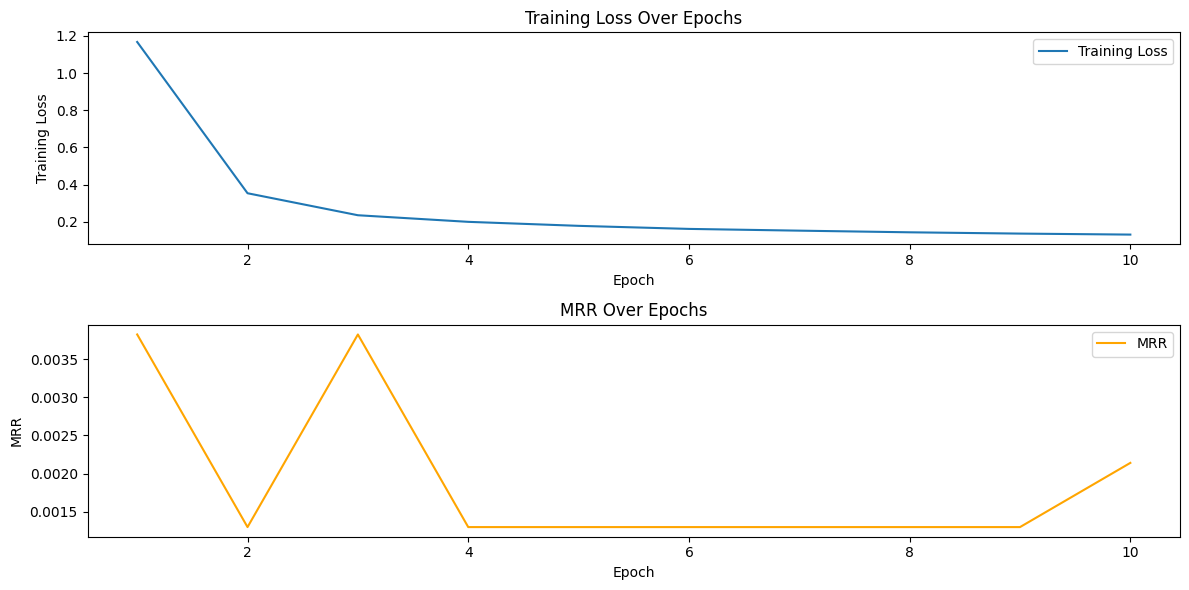

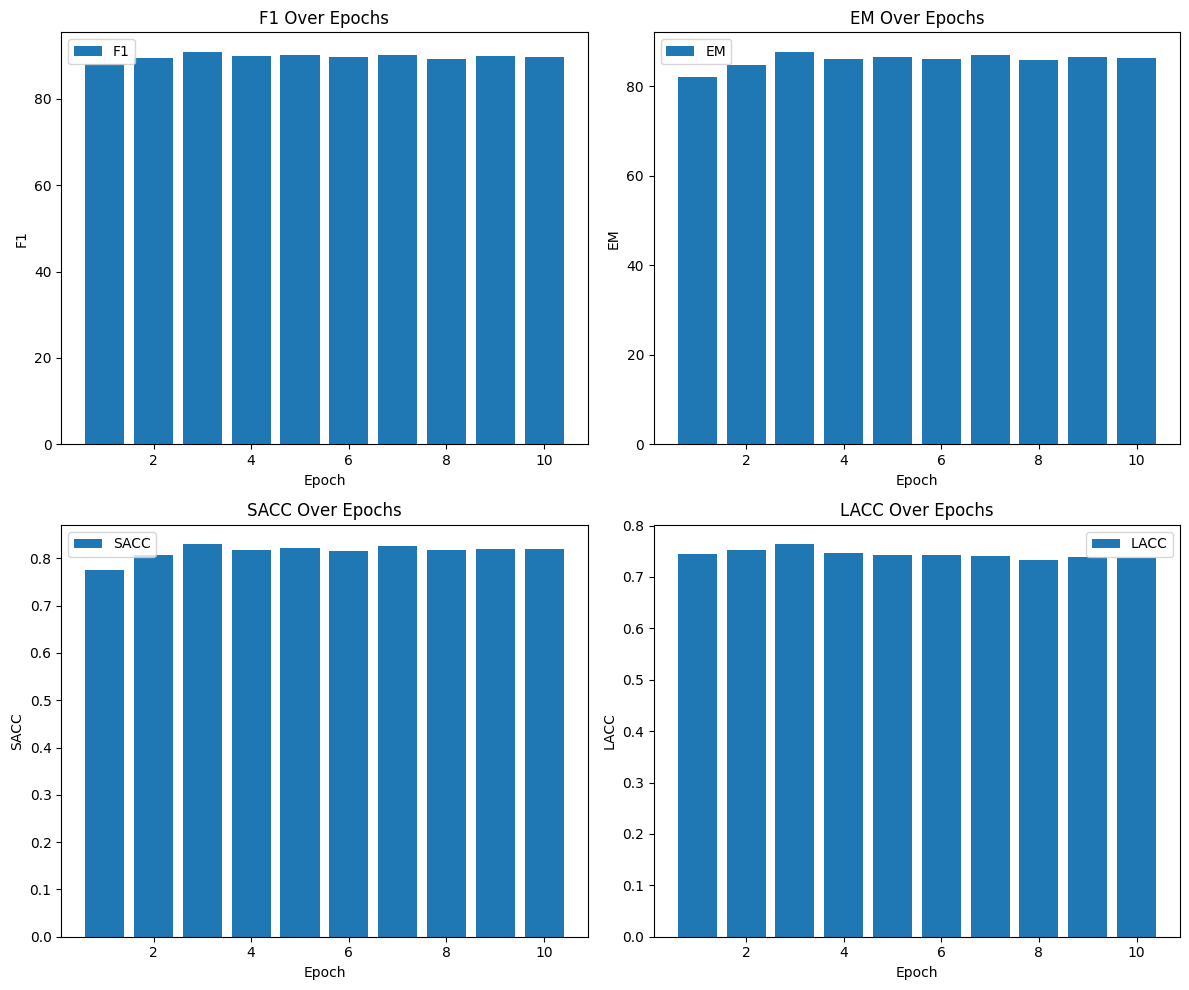

100%|██████████| 5450/5450 [11:45<00:00,  7.72it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:44,  8.40it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:08:05,  1.57s/it]

Epoch 0 Metrics:
Training Loss: 1.1348221288771805
EM: 82.38532110091744
F1: 87.86978985642601
MRR: 0.0012996941896024465
Lacc: 0.7522935779816514
Sacc: 0.7862385321100918


 20%|█▉        | 1089/5450 [02:15<08:35,  8.46it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:21<1:54:11,  1.57s/it]

Epoch 1 Metrics:
Training Loss: 0.35659725853848623
EM: 85.68807339449542
F1: 89.90507815059749
MRR: 0.0012996941896024465
Lacc: 0.7619266055045871
Sacc: 0.8128440366972477


 30%|██▉       | 1634/5450 [03:25<07:31,  8.46it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:32<1:39:40,  1.57s/it]

Epoch 2 Metrics:
Training Loss: 0.2583056072114941
EM: 85.5045871559633
F1: 89.35940654691187
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.810091743119266


 40%|███▉      | 2179/5450 [04:35<06:22,  8.54it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:42<1:25:14,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.21212876066907282
EM: 87.1559633027523
F1: 90.45154950111747
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8247706422018348


 50%|████▉     | 2724/5450 [05:45<05:17,  8.58it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:10:47,  1.56s/it]

Epoch 4 Metrics:
Training Loss: 0.18168721599600474
EM: 86.97247706422019
F1: 90.37259917199115
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8238532110091743


 60%|█████▉    | 3269/5450 [06:56<04:16,  8.52it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<56:48,  1.56s/it]

Epoch 5 Metrics:
Training Loss: 0.16559958793062698
EM: 86.97247706422019
F1: 90.08784584103964
MRR: 0.0012996941896024465
Lacc: 0.7522935779816514
Sacc: 0.8229357798165138


 70%|██████▉   | 3814/5450 [08:07<03:12,  8.49it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:13<42:33,  1.56s/it]

Epoch 6 Metrics:
Training Loss: 0.15873545861734642
EM: 86.42201834862385
F1: 89.99023216274414
MRR: 0.0012996941896024465
Lacc: 0.7504587155963303
Sacc: 0.8201834862385321


 80%|███████▉  | 4359/5450 [09:17<02:09,  8.39it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:24<28:38,  1.58s/it]

Epoch 7 Metrics:
Training Loss: 0.14458753959902715
EM: 86.14678899082568
F1: 89.81105062879125
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.818348623853211


 90%|████████▉ | 4904/5450 [10:28<01:05,  8.31it/s]

Evaluation!


 90%|█████████ | 4906/5450 [10:34<14:11,  1.57s/it]

Epoch 8 Metrics:
Training Loss: 0.13541124676468508
EM: 86.60550458715596
F1: 89.92971277254783
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8201834862385321


100%|█████████▉| 5449/5450 [11:38<00:00,  8.60it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.17it/s]


Epoch 9 Metrics:
Training Loss: 0.13191763621417446
EM: 86.3302752293578
F1: 89.64846143409197
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.818348623853211
EM - Highest: 87.1559633027523, Lowest: 82.38532110091744, Average: 86.01834862385321
F1 - Highest: 90.45154950111747, Lowest: 87.86978985642601, Average: 89.74257260662588
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7619266055045871, Lowest: 0.7454128440366973, Average: 0.7509633027522936
Sacc - Highest: 0.8247706422018348, Lowest: 0.7862385321100918, Average: 0.8157798165137615


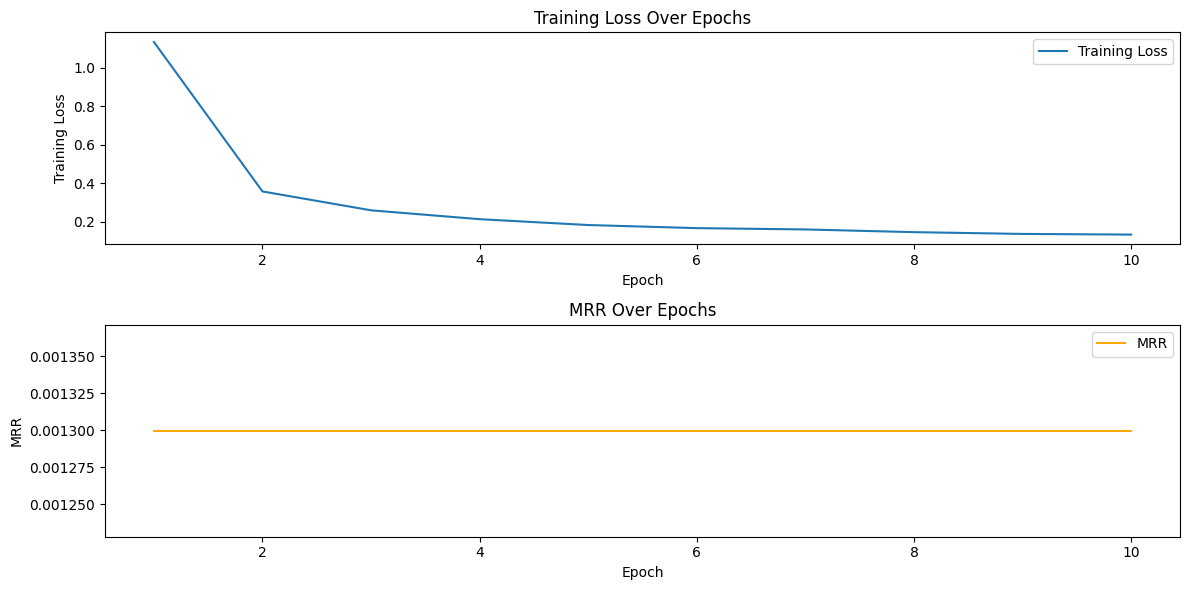

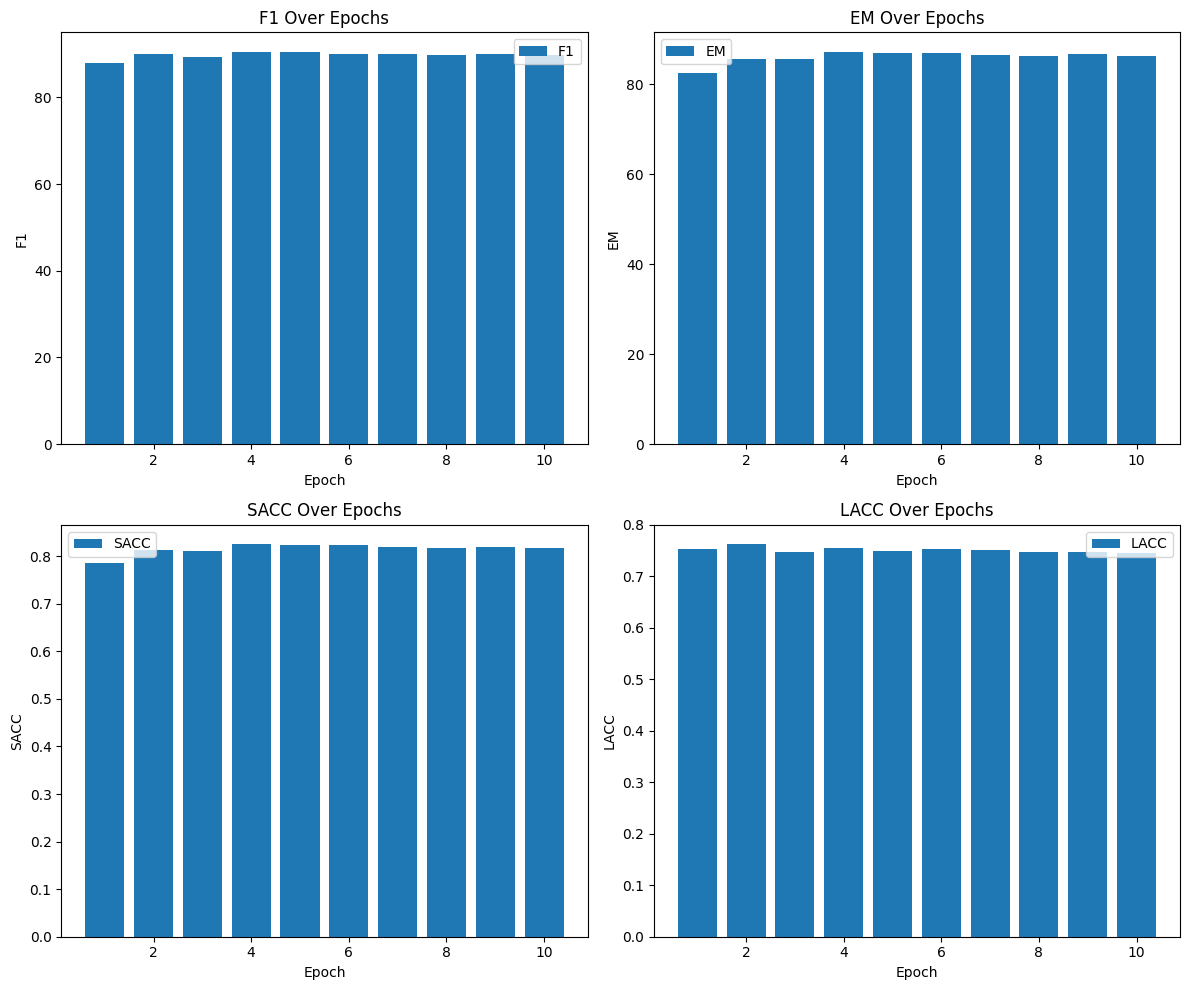

100%|██████████| 5450/5450 [11:46<00:00,  7.72it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|▉         | 544/5450 [01:04<09:34,  8.54it/s]

Evaluation!


 10%|█         | 546/5450 [01:10<2:07:31,  1.56s/it]

Epoch 0 Metrics:
Training Loss: 1.105479777734214
EM: 82.38532110091744
F1: 88.28003527778641
MRR: 0.0021406727828746173
Lacc: 0.7591743119266054
Sacc: 0.7770642201834862


 20%|█▉        | 1089/5450 [02:14<08:31,  8.52it/s] 

Evaluation!


 20%|██        | 1091/5450 [02:21<1:53:25,  1.56s/it]

Epoch 1 Metrics:
Training Loss: 0.3448726883909981
EM: 84.12844036697248
F1: 89.12978413876738
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.791743119266055


 30%|██▉       | 1634/5450 [03:25<07:31,  8.45it/s]  

Evaluation!


 30%|███       | 1636/5450 [03:31<1:39:23,  1.56s/it]

Epoch 2 Metrics:
Training Loss: 0.2477019342081194
EM: 85.3211009174312
F1: 89.27460993675874
MRR: 0.0012996941896024465
Lacc: 0.7536697247706422
Sacc: 0.8045871559633028


 40%|███▉      | 2179/5450 [04:35<06:22,  8.54it/s]  

Evaluation!


 40%|████      | 2181/5450 [04:42<1:25:08,  1.56s/it]

Epoch 3 Metrics:
Training Loss: 0.2043688175960555
EM: 85.41284403669725
F1: 89.17976565757363
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8036697247706422


 50%|████▉     | 2724/5450 [05:45<05:16,  8.60it/s]  

Evaluation!


 50%|█████     | 2726/5450 [05:52<1:10:52,  1.56s/it]

Epoch 4 Metrics:
Training Loss: 0.18068406448043764
EM: 86.23853211009174
F1: 89.74943133438262
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8128440366972477


 60%|█████▉    | 3269/5450 [06:56<04:13,  8.59it/s]  

Evaluation!


 60%|██████    | 3271/5450 [07:02<56:25,  1.55s/it]

Epoch 5 Metrics:
Training Loss: 0.16909794486896776
EM: 85.96330275229357
F1: 89.88308087166081
MRR: 0.0012996941896024465
Lacc: 0.7495412844036697
Sacc: 0.8091743119266055


 70%|██████▉   | 3814/5450 [08:06<03:10,  8.57it/s]

Evaluation!


 70%|███████   | 3816/5450 [08:12<42:25,  1.56s/it]

Epoch 6 Metrics:
Training Loss: 0.15667062942982637
EM: 86.23853211009174
F1: 89.57791326297432
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8128440366972477


 80%|███████▉  | 4359/5450 [09:17<02:11,  8.28it/s]

Evaluation!


 80%|████████  | 4361/5450 [09:23<28:21,  1.56s/it]

Epoch 7 Metrics:
Training Loss: 0.15001548811784782
EM: 86.78899082568807
F1: 90.025611920601
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.818348623853211


 90%|████████▉ | 4904/5450 [10:27<01:04,  8.47it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 29.94it/s]


Epoch 8 Metrics:
Training Loss: 0.1410149863198049
EM: 87.1559633027523
F1: 90.1426684115107
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8201834862385321


100%|█████████▉| 5449/5450 [11:37<00:00,  8.52it/s]

Evaluation!


100%|██████████| 137/137 [00:04<00:00, 30.02it/s]


Epoch 9 Metrics:
Training Loss: 0.13348237571040586
EM: 87.1559633027523
F1: 90.17987192874659
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.8211009174311926
EM - Highest: 87.1559633027523, Lowest: 82.38532110091744, Average: 85.6788990825688
F1 - Highest: 90.17987192874659, Lowest: 88.28003527778641, Average: 89.54227727407621
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0013837920489296637
Lacc - Highest: 0.7591743119266054, Lowest: 0.7458715596330275, Average: 0.7505504587155963
Sacc - Highest: 0.8211009174311926, Lowest: 0.7770642201834862, Average: 0.8071559633027523


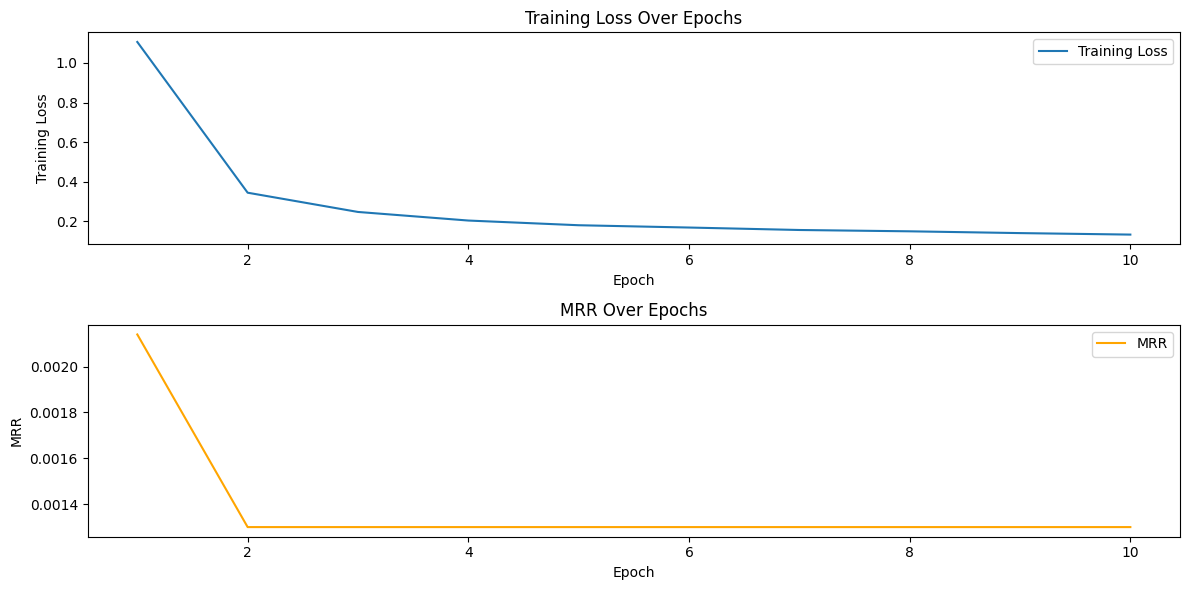

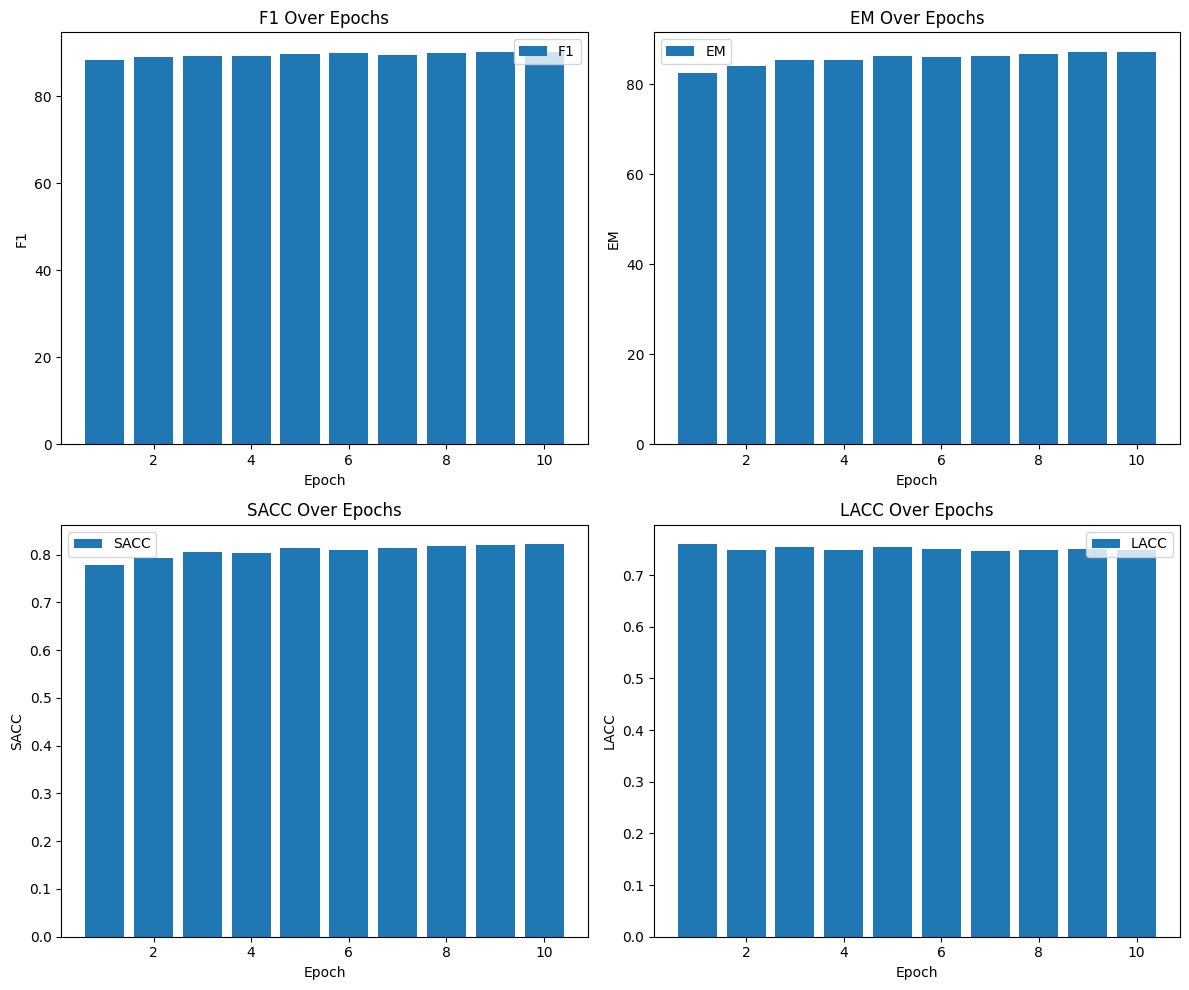

100%|██████████| 5450/5450 [11:45<00:00,  7.73it/s]


In [40]:
# Directory to save models
# 9
save_dir = "biobert_ner_re_bag_finetuned"
os.makedirs(save_dir, exist_ok=True)

# Number of epochs for training
num_train_epochs = 10

# Train and save models
# bootstrap_samples = bootstrap_sampling(train_dataset, n_samples=10)
for i, train_data in enumerate(bootstrap_samples):
    train_and_save_model(train_data, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, i, num_train_epochs)


In [41]:
class EnsembleModel(PreTrainedModel):
    def __init__(self, config, model_paths):
        super().__init__(config)
        self.models = [AutoModelForQuestionAnswering.from_pretrained(path) for path in model_paths]

    def forward(self, **inputs):
        start_logits_list = []
        end_logits_list = []

        for model in self.models:
            outputs = model(**inputs)
            start_logits_list.append(outputs.start_logits)
            end_logits_list.append(outputs.end_logits)

        start_logits_stack = torch.stack(start_logits_list, dim=0)
        end_logits_stack = torch.stack(end_logits_list, dim=0)

        # Apply majority voting
        start_logits = torch.mode(start_logits_stack, dim=0).values
        end_logits = torch.mode(end_logits_stack, dim=0).values

        return QuestionAnsweringModelOutput(
            start_logits=start_logits,
            end_logits=end_logits,
        )

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        config = AutoConfig.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)
        model_paths = kwargs.pop("model_paths", None)
        model = cls(config, model_paths)
        return model

In [42]:
# Save paths of the individual models
model_paths = [os.path.join(save_dir, f"model_{i}") for i in range(10)]

# Save paths to a JSON file for later use
with open(os.path.join(save_dir, "model_paths.json"), "w") as f:
    json.dump(model_paths, f)

# Load ensemble model
ensemble_model = EnsembleModel.from_pretrained(model_checkpoint, model_paths=model_paths)
ensemble_tokenizer = AutoTokenizer.from_pretrained(save_dir)

In [43]:
def evaluate_ensemble(model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    start_logits_list = []
    end_logits_list = []

    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            start_logits_list.append(outputs.start_logits.cpu().numpy())
            end_logits_list.append(outputs.end_logits.cpu().numpy())

    start_logits = np.concatenate(start_logits_list)[:len(validation_dataset)]
    end_logits = np.concatenate(end_logits_list)[:len(validation_dataset)]

    metrics = compute_metrics(start_logits, end_logits, validation_dataset, raw_val_dataset)

    print("Ensemble Model Metrics:")
    print(f"EM: {metrics['exact_match']}")
    print(f"F1: {metrics['f1']}")
    print(f"MRR: {metrics['mrr']}")
    print(f"Lacc: {metrics['lacc']}")
    print(f"Sacc: {metrics['sacc']}")

    return metrics

# Evaluate ensemble
ensemble_metrics = evaluate_ensemble(ensemble_model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset)

Ensemble Model Metrics:
EM: 85.96330275229357
F1: 90.01000570558313
MRR: 0.0012996941896024465
Lacc: 0.7435779816513761
Sacc: 0.8091743119266055


In [44]:
# from transformers import pipeline

In [45]:
# # model load path customizing --->

# # Load your saved model checkpoint
# # biobert_qa_finetuned = "/content/drive/MyDrive/Colab Notebooks/499/Models 2/biobert_qa_finetuned"


# # Create the question answering pipeline
# question_answerer = pipeline("question-answering", model=ensemble_model, tokenizer=ensemble_tokenizer)

# # People with diabetes experience blurry vision because of what?
# # What are the symptoms of blurry vision for diabetes people?
# # Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications.
# question = "What are the symptoms of blurry vision for diabetes people?"
# context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."


# # Perform question answering
# answer = question_answerer(question=question, context=context)
# print(answer)


# ner_re_bilstm_bag

In [46]:
# 10
def visualize_performance(metrics, train_losses, mrr_scores, num_train_epochs, save_path='performance_graph'):
    epochs = range(1, num_train_epochs + 1)

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, mrr_scores, label='MRR', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('MRR')
    plt.title('MRR Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'training_loss_mrr.png'), dpi=300)
    plt.show()

    metric_names = ['F1', 'EM', 'SACC', 'LACC']
    metrics_scores = [metrics['f1'], metrics['exact_match'], metrics['sacc'], metrics['lacc']]

    plt.figure(figsize=(12, 10))
    for i, (metric, scores) in enumerate(zip(metric_names, metrics_scores)):
        plt.subplot(2, 2, i + 1)
        plt.bar(epochs, scores, label=metric)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f'{metric} Over Epochs')
        plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'metrics_over_epochs.png'), dpi=300)
    plt.show()

In [47]:
class CustomBiLSTMModel(nn.Module):
    def __init__(self, model_checkpoint, hidden_size=768, lstm_hidden_size=512, num_layers=1):
        super(CustomBiLSTMModel, self).__init__()
        self.bert = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
        # 11
        self.ner_model = BertForQuestionAnswering.from_pretrained('biobert_model_ner')
        # 12
        self.re_model = BertForQuestionAnswering.from_pretrained('biobert_model_re')
        self.bert.bert = self.ner_model.bert
        self.bert.bert = self.re_model.bert

        self.bilstm = nn.LSTM(hidden_size, lstm_hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.qa_outputs = nn.Linear(lstm_hidden_size * 2, 2)  # For start and end logits

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.bilstm(sequence_output)
        logits = self.qa_outputs(lstm_output)

        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [48]:
def compute_statistics(scores):
    highest = max(scores)
    lowest = min(scores)
    average = sum(scores) / len(scores)
    return {'highest': highest, 'lowest': lowest, 'average': average}

In [49]:
def train_and_save_model(train_dataset, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, model_idx, num_train_epochs):
    model = CustomBiLSTMModel(model_checkpoint)
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    train_dataset = set_format(train_dataset, "torch")
    train_dataset = CustomDataset(train_dataset)
    train_dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        collate_fn=custom_collate_fn,
        batch_size=8,
    )

    validation_set = validation_dataset.remove_columns(["example_id", "offset_mapping"])
    validation_set.set_format("torch")

    eval_dataloader = DataLoader(
        validation_set, collate_fn=custom_collate_fn, batch_size=8
    )

    optimizer = AdamW(model.parameters(), lr=2e-5)
    accelerator = Accelerator()
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    num_update_steps_per_epoch = len(train_dataloader)
    num_training_steps = num_train_epochs * num_update_steps_per_epoch

    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    train_losses = []
    em_scores = []
    f1_scores = []
    mrr_scores = []
    lacc_scores = []
    sacc_scores = []

    progress_bar = tqdm(range(num_training_steps))

    for epoch in range(num_train_epochs):
        model.train()
        total_train_loss = 0
        for step, batch in enumerate(train_dataloader):
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch.get('token_type_ids'))
            start_logits, end_logits = outputs
            loss = nn.CrossEntropyLoss()(start_logits, batch['start_positions']) + nn.CrossEntropyLoss()(end_logits, batch['end_positions'])
            total_train_loss += loss.item()
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        average_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(average_train_loss)

        model.eval()
        start_logits = []
        end_logits = []
        total_val_loss = 0
        accelerator.print("Evaluation!")
        for batch in tqdm(eval_dataloader):
            with torch.no_grad():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch.get('token_type_ids'))
                start_logits_batch, end_logits_batch = outputs

            start_logits.append(accelerator.gather(start_logits_batch).cpu().numpy())
            end_logits.append(accelerator.gather(end_logits_batch).cpu().numpy())

        start_logits = np.concatenate(start_logits)
        end_logits = np.concatenate(end_logits)
        start_logits = start_logits[: len(validation_dataset)]
        end_logits = end_logits[: len(validation_dataset)]

        metrics = compute_metrics(
            start_logits, end_logits, validation_dataset, raw_val_dataset
        )

        em_scores.append(metrics['exact_match'])
        f1_scores.append(metrics['f1'])
        mrr_scores.append(metrics['mrr'])
        lacc_scores.append(metrics['lacc'])
        sacc_scores.append(metrics['sacc'])

        print(f"Epoch {epoch} Metrics:")
        print(f"Training Loss: {average_train_loss}")
        print(f"EM: {metrics['exact_match']}")
        print(f"F1: {metrics['f1']}")
        print(f"MRR: {metrics['mrr']}")
        print(f"Lacc: {metrics['lacc']}")
        print(f"Sacc: {metrics['sacc']}")

    metrics_statistics = {
        'EM': compute_statistics(em_scores),
        'F1': compute_statistics(f1_scores),
        'MRR': compute_statistics(mrr_scores),
        'Lacc': compute_statistics(lacc_scores),
        'Sacc': compute_statistics(sacc_scores),
    }

    for metric, stats in metrics_statistics.items():
        print(f"{metric} - Highest: {stats['highest']}, Lowest: {stats['lowest']}, Average: {stats['average']}")

    visualize_performance({
        'exact_match': em_scores,
        'f1': f1_scores,
        'mrr': mrr_scores,
        'lacc': lacc_scores,
        'sacc': sacc_scores
    }, train_losses, mrr_scores, num_train_epochs)

    model_save_path = os.path.join(save_dir, f"model_{model_idx}.pt")
    torch.save(model.state_dict(), model_save_path)
    if model_idx == 0:  # Save the tokenizer and BERT config only once
        tokenizer.save_pretrained(save_dir)
        model.bert.save_pretrained(save_dir)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yeara\AppData\Local\Temp\ipykernel_31960\3448799005.py:6: UserWarning: To copy construct from a tensor, it is reco

Evaluation!


 10%|█         | 546/5450 [01:31<3:32:02,  2.59s/it]

Epoch 0 Metrics:
Training Loss: 2.7741994059960775
EM: 79.72477064220183
F1: 87.28987354141127
MRR: 0.0012996941896024465
Lacc: 0.755045871559633
Sacc: 0.7605504587155963


 20%|██        | 1090/5450 [02:54<10:07,  7.18it/s] 

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.25it/s]


Epoch 1 Metrics:
Training Loss: 0.7488036889753757
EM: 84.40366972477064
F1: 88.71130419722161
MRR: 0.0021406727828746173
Lacc: 0.75
Sacc: 0.8119266055045872


 30%|███       | 1635/5450 [04:25<08:49,  7.21it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 2 Metrics:
Training Loss: 0.49491625224505
EM: 84.6788990825688
F1: 89.70947282439307
MRR: 0.0012996941896024465
Lacc: 0.7463302752293578
Sacc: 0.8091743119266055


 40%|████      | 2180/5450 [05:57<07:39,  7.12it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.22it/s]


Epoch 3 Metrics:
Training Loss: 0.39312522849409814
EM: 85.41284403669725
F1: 89.89460315928058
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8165137614678899


 50%|█████     | 2725/5450 [07:28<06:37,  6.85it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.12it/s]


Epoch 4 Metrics:
Training Loss: 0.34951169227736945
EM: 85.41284403669725
F1: 89.39900123688545
MRR: 0.0012996941896024465
Lacc: 0.7426605504587156
Sacc: 0.8155963302752294


 60%|██████    | 3270/5450 [09:00<05:04,  7.15it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:08<1:34:37,  2.61s/it]

Epoch 5 Metrics:
Training Loss: 0.31272110074796977
EM: 85.5045871559633
F1: 89.6407072882245
MRR: 0.0012996941896024465
Lacc: 0.7412844036697248
Sacc: 0.8128440366972477


 70%|███████   | 3815/5450 [10:31<03:47,  7.19it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:39<1:10:54,  2.60s/it]

Epoch 6 Metrics:
Training Loss: 0.29927297892869203
EM: 86.5137614678899
F1: 89.82782817348073
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8247706422018348


 80%|████████  | 4360/5450 [12:02<02:31,  7.22it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:10<47:15,  2.60s/it]

Epoch 7 Metrics:
Training Loss: 0.2881074292835173
EM: 85.96330275229357
F1: 89.54465851888634
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8192660550458716


 90%|█████████ | 4905/5450 [13:34<01:18,  6.96it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.13it/s]


Epoch 8 Metrics:
Training Loss: 0.2661730396528216
EM: 86.88073394495413
F1: 90.34752557148356
MRR: 0.0012996941896024465
Lacc: 0.7477064220183486
Sacc: 0.8293577981651377


100%|██████████| 5450/5450 [15:05<00:00,  7.18it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.32it/s]


Epoch 9 Metrics:
Training Loss: 0.2587410044688689
EM: 86.3302752293578
F1: 89.92092006689641
MRR: 0.0012996941896024465
Lacc: 0.7444954128440368
Sacc: 0.8229357798165138
EM - Highest: 86.88073394495413, Lowest: 79.72477064220183, Average: 85.08256880733946
F1 - Highest: 90.34752557148356, Lowest: 87.28987354141127, Average: 89.42858945781634
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0013837920489296637
Lacc - Highest: 0.755045871559633, Lowest: 0.7412844036697248, Average: 0.7470183486238531
Sacc - Highest: 0.8293577981651377, Lowest: 0.7605504587155963, Average: 0.8122935779816516


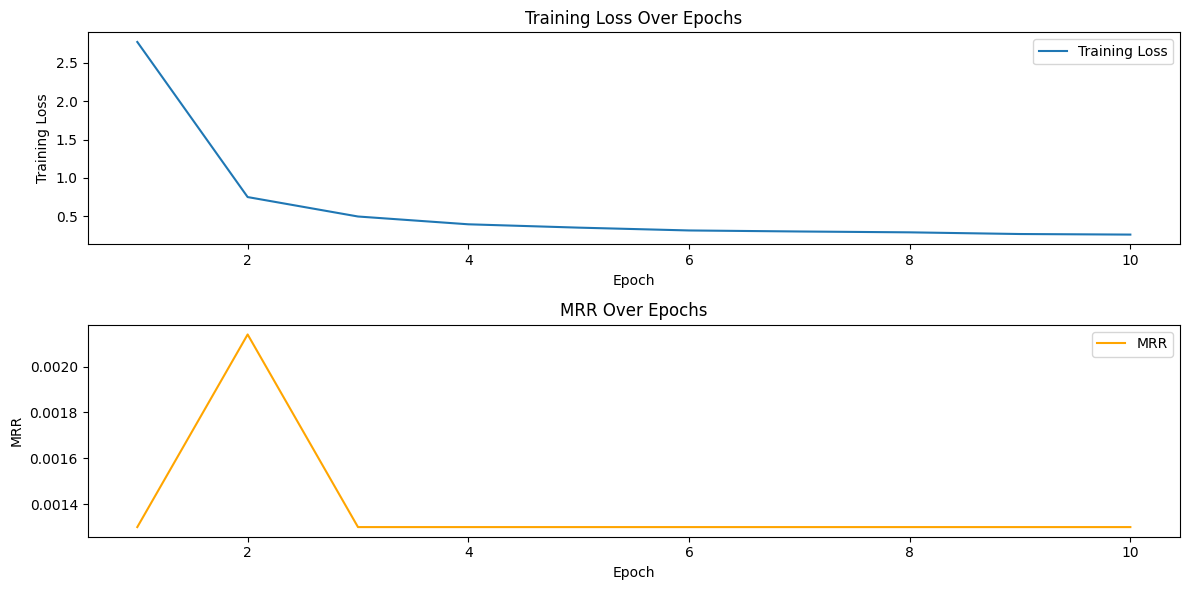

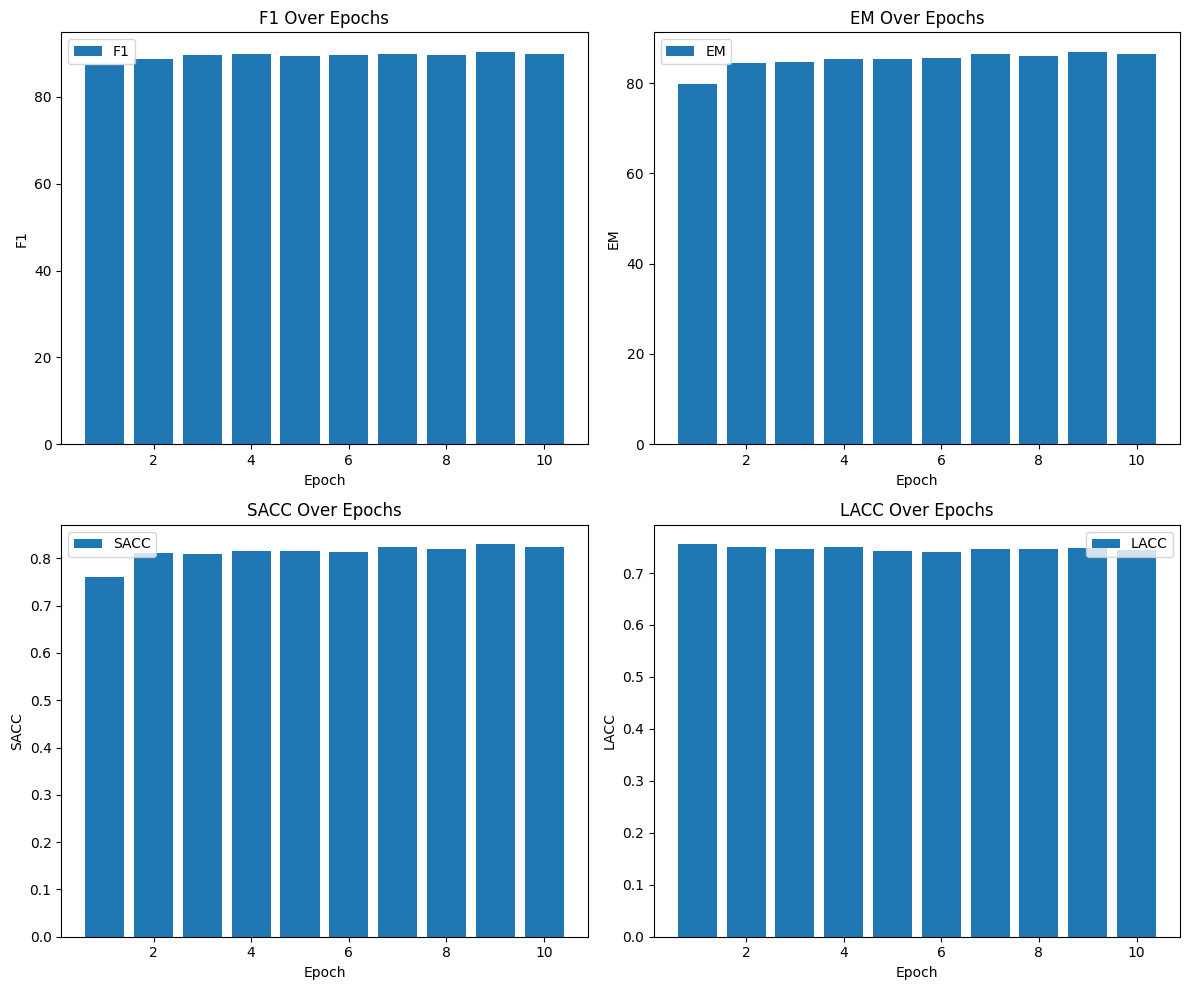

100%|██████████| 5450/5450 [15:15<00:00,  5.95it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:22<11:29,  7.11it/s]

Evaluation!


 10%|█         | 546/5450 [01:31<3:33:21,  2.61s/it]

Epoch 0 Metrics:
Training Loss: 2.7088070645791675
EM: 80.55045871559633
F1: 88.08189366225957
MRR: 0.0012996941896024465
Lacc: 0.7504587155963303
Sacc: 0.7614678899082569


 20%|██        | 1090/5450 [02:54<10:24,  6.99it/s] 

Evaluation!


 20%|██        | 1091/5450 [03:02<3:09:41,  2.61s/it]

Epoch 1 Metrics:
Training Loss: 0.7212287971596105
EM: 84.40366972477064
F1: 89.30510591635503
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.7963302752293578


 30%|███       | 1635/5450 [04:26<09:05,  6.99it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:34<2:47:15,  2.63s/it]

Epoch 2 Metrics:
Training Loss: 0.49143781018776633
EM: 86.69724770642202
F1: 90.58906178834586
MRR: 0.0012996941896024465
Lacc: 0.7600917431192661
Sacc: 0.8174311926605504


 40%|████      | 2180/5450 [05:57<07:32,  7.23it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:05<2:22:19,  2.61s/it]

Epoch 3 Metrics:
Training Loss: 0.4023188016565363
EM: 85.96330275229357
F1: 90.23362100040431
MRR: 0.0012996941896024465
Lacc: 0.7568807339449541
Sacc: 0.8091743119266055


 50%|█████     | 2725/5450 [07:28<06:20,  7.16it/s]  

Evaluation!


 50%|█████     | 2726/5450 [07:36<1:58:14,  2.60s/it]

Epoch 4 Metrics:
Training Loss: 0.3648464708195982
EM: 85.96330275229357
F1: 90.17445244490844
MRR: 0.0012996941896024465
Lacc: 0.7582568807339449
Sacc: 0.8119266055045872


 60%|██████    | 3270/5450 [08:59<05:11,  7.00it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:08<1:34:23,  2.60s/it]

Epoch 5 Metrics:
Training Loss: 0.34430708679319316
EM: 87.24770642201835
F1: 90.67244204064136
MRR: 0.0012996941896024465
Lacc: 0.7564220183486239
Sacc: 0.8201834862385321


 70%|███████   | 3815/5450 [10:31<03:52,  7.03it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:40<1:10:54,  2.60s/it]

Epoch 6 Metrics:
Training Loss: 0.3097634179002836
EM: 86.88073394495413
F1: 90.56052719707515
MRR: 0.0012996941896024465
Lacc: 0.7555045871559632
Sacc: 0.8174311926605504


 80%|████████  | 4360/5450 [12:02<02:30,  7.23it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:11<47:13,  2.60s/it]

Epoch 7 Metrics:
Training Loss: 0.29022396847246845
EM: 86.97247706422019
F1: 90.63022709318741
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.8174311926605504


 90%|█████████ | 4905/5450 [13:33<01:16,  7.08it/s]

Evaluation!


 90%|█████████ | 4906/5450 [13:41<23:33,  2.60s/it]

Epoch 8 Metrics:
Training Loss: 0.27863795692272003
EM: 86.23853211009174
F1: 90.35393865176135
MRR: 0.0012996941896024465
Lacc: 0.7513761467889908
Sacc: 0.8119266055045872


100%|██████████| 5450/5450 [15:04<00:00,  6.96it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.32it/s]


Epoch 9 Metrics:
Training Loss: 0.25696982819023073
EM: 86.78899082568807
F1: 90.46252985668282
MRR: 0.0012996941896024465
Lacc: 0.7513761467889908
Sacc: 0.8155963302752294
EM - Highest: 87.24770642201835, Lowest: 80.55045871559633, Average: 85.77064220183487
F1 - Highest: 90.67244204064136, Lowest: 88.08189366225957, Average: 90.10637996516215
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7600917431192661, Lowest: 0.7472477064220183, Average: 0.7543577981651376
Sacc - Highest: 0.8201834862385321, Lowest: 0.7614678899082569, Average: 0.8078899082568809


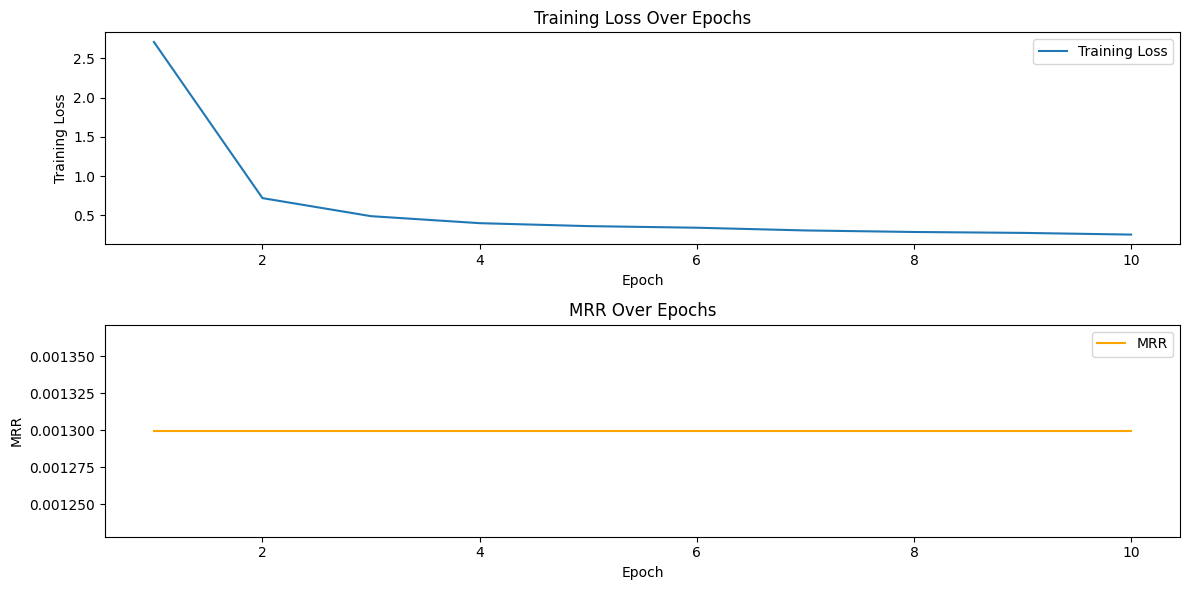

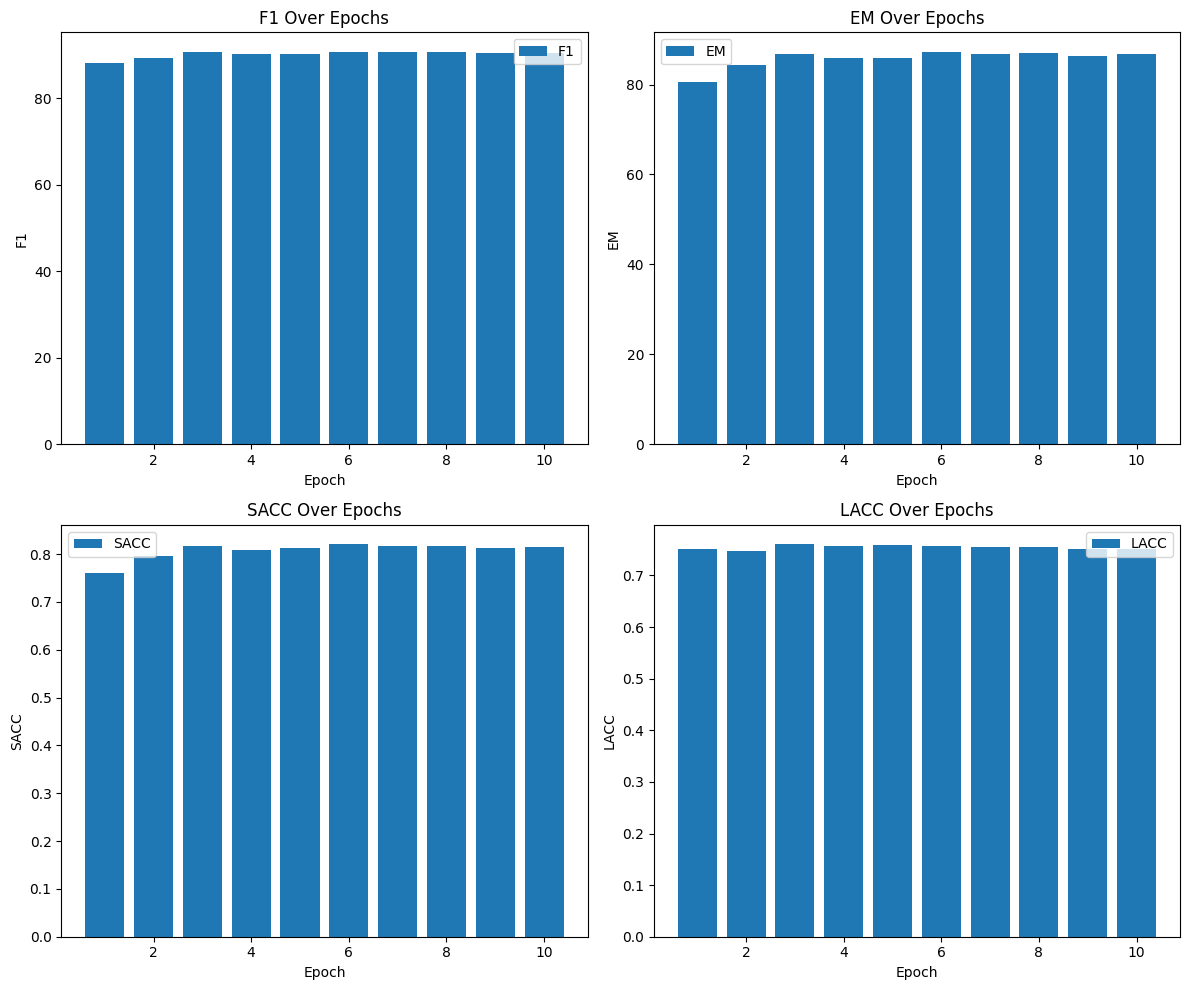

100%|██████████| 5450/5450 [15:14<00:00,  5.96it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:31,  7.09it/s]

Evaluation!


 10%|█         | 546/5450 [01:32<3:33:08,  2.61s/it]

Epoch 0 Metrics:
Training Loss: 2.7144402183523964
EM: 83.30275229357798
F1: 88.48791368440713
MRR: 0.0012996941896024465
Lacc: 0.7688073394495413
Sacc: 0.7880733944954128


 20%|██        | 1090/5450 [02:54<10:18,  7.05it/s] 

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 1 Metrics:
Training Loss: 0.7613844111425068
EM: 85.41284403669725
F1: 89.84154063003436
MRR: 0.004663608562691132
Lacc: 0.7766055045871559
Sacc: 0.8128440366972477


 30%|███       | 1635/5450 [04:25<08:56,  7.11it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:34<2:45:36,  2.61s/it]

Epoch 2 Metrics:
Training Loss: 0.5120063379458194
EM: 86.3302752293578
F1: 90.3685041468918
MRR: 0.002981651376146789
Lacc: 0.7678899082568807
Sacc: 0.8220183486238533


 40%|████      | 2180/5450 [05:57<07:51,  6.93it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:06<2:22:53,  2.62s/it]

Epoch 3 Metrics:
Training Loss: 0.4275302046132402
EM: 86.05504587155963
F1: 90.13734298445434
MRR: 0.002981651376146789
Lacc: 0.763302752293578
Sacc: 0.818348623853211


 50%|█████     | 2725/5450 [07:29<06:15,  7.26it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.28it/s]


Epoch 4 Metrics:
Training Loss: 0.3792453717878259
EM: 87.33944954128441
F1: 90.29112548452792
MRR: 0.002981651376146789
Lacc: 0.763302752293578
Sacc: 0.8302752293577982


 60%|██████    | 3270/5450 [09:00<05:06,  7.11it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:08<1:34:12,  2.59s/it]

Epoch 5 Metrics:
Training Loss: 0.3406906128092028
EM: 87.1559633027523
F1: 90.39671145932527
MRR: 0.002981651376146789
Lacc: 0.7587155963302752
Sacc: 0.8293577981651377


 70%|███████   | 3815/5450 [10:30<03:47,  7.19it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.21it/s]


Epoch 6 Metrics:
Training Loss: 0.3174238920523657
EM: 87.24770642201835
F1: 90.62682521736673
MRR: 0.002981651376146789
Lacc: 0.7545871559633027
Sacc: 0.8330275229357799


 80%|████████  | 4360/5450 [12:02<02:37,  6.91it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:10<47:26,  2.61s/it]

Epoch 7 Metrics:
Training Loss: 0.29702058566206585
EM: 87.06422018348624
F1: 90.391344082803
MRR: 0.002981651376146789
Lacc: 0.7582568807339449
Sacc: 0.828440366972477


 90%|█████████ | 4905/5450 [13:34<01:16,  7.17it/s]

Evaluation!


 90%|█████████ | 4906/5450 [13:42<23:41,  2.61s/it]

Epoch 8 Metrics:
Training Loss: 0.2906477382891478
EM: 87.61467889908256
F1: 90.64428128771002
MRR: 0.002981651376146789
Lacc: 0.7619266055045871
Sacc: 0.8348623853211009


100%|██████████| 5450/5450 [15:05<00:00,  7.07it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.35it/s]


Epoch 9 Metrics:
Training Loss: 0.26688300628560047
EM: 88.1651376146789
F1: 91.03881030609224
MRR: 0.002981651376146789
Lacc: 0.7619266055045871
Sacc: 0.8385321100917431
EM - Highest: 88.1651376146789, Lowest: 83.30275229357798, Average: 86.56880733944953
F1 - Highest: 91.03881030609224, Lowest: 88.48791368440713, Average: 90.22243992836128
MRR - Highest: 0.004663608562691132, Lowest: 0.0012996941896024465, Average: 0.002981651376146789
Lacc - Highest: 0.7766055045871559, Lowest: 0.7545871559633027, Average: 0.763532110091743
Sacc - Highest: 0.8385321100917431, Lowest: 0.7880733944954128, Average: 0.8235779816513761


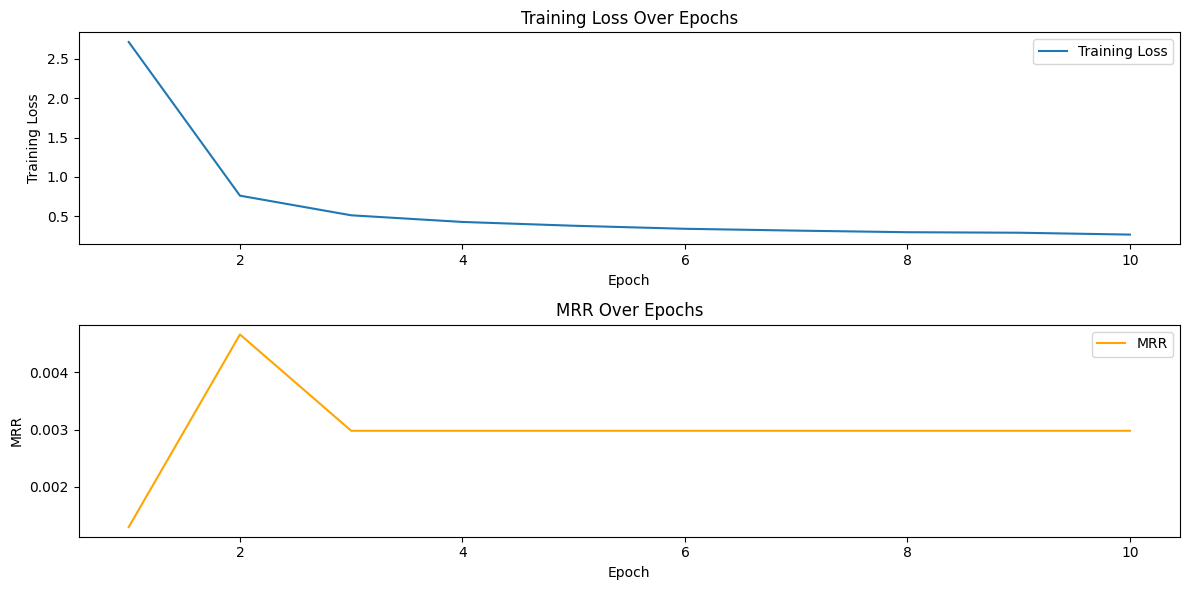

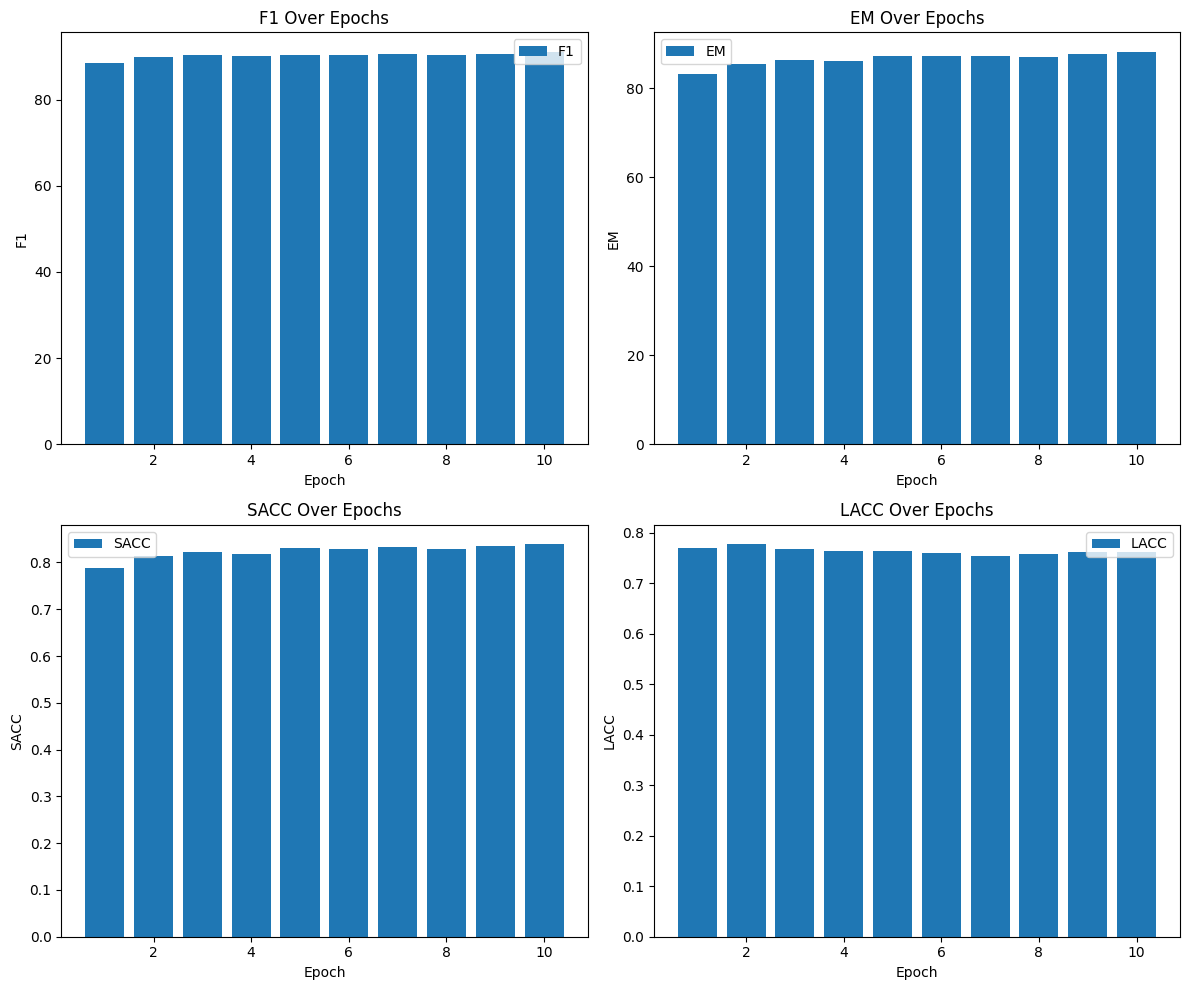

100%|██████████| 5450/5450 [15:15<00:00,  5.95it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:22<11:24,  7.16it/s]

Evaluation!


 10%|█         | 546/5450 [01:31<3:33:34,  2.61s/it]

Epoch 0 Metrics:
Training Loss: 2.721027517947582
EM: 80.8256880733945
F1: 87.24088668288522
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.7724770642201835


 20%|██        | 1090/5450 [02:54<10:17,  7.06it/s] 

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.18it/s]


Epoch 1 Metrics:
Training Loss: 0.7396241161186214
EM: 83.76146788990826
F1: 88.98078920548012
MRR: 0.0012996941896024465
Lacc: 0.7577981651376147
Sacc: 0.7963302752293578


 30%|███       | 1635/5450 [04:26<09:06,  6.98it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:34<2:45:56,  2.61s/it]

Epoch 2 Metrics:
Training Loss: 0.5224278116103159
EM: 84.6788990825688
F1: 89.10995765224882
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.808256880733945


 40%|████      | 2180/5450 [05:57<07:31,  7.24it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:06<2:22:31,  2.62s/it]

Epoch 3 Metrics:
Training Loss: 0.44079079012548844
EM: 86.60550458715596
F1: 90.72735051484703
MRR: 0.004663608562691131
Lacc: 0.7536697247706422
Sacc: 0.8256880733944955


 50%|█████     | 2725/5450 [07:28<06:17,  7.22it/s]  

Evaluation!


 50%|█████     | 2726/5450 [07:37<1:58:50,  2.62s/it]

Epoch 4 Metrics:
Training Loss: 0.3905393383683586
EM: 86.14678899082568
F1: 90.31639591847632
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.8211009174311926


 60%|██████    | 3270/5450 [09:00<05:07,  7.09it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.22it/s]


Epoch 5 Metrics:
Training Loss: 0.35418778473143936
EM: 87.1559633027523
F1: 90.97908603722472
MRR: 0.0012996941896024465
Lacc: 0.751834862385321
Sacc: 0.8311926605504587


 70%|███████   | 3815/5450 [10:32<03:45,  7.24it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:40<1:11:13,  2.62s/it]

Epoch 6 Metrics:
Training Loss: 0.3230390817563502
EM: 86.42201834862385
F1: 90.44658077320305
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8247706422018348


 80%|████████  | 4360/5450 [12:03<02:32,  7.17it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.19it/s]


Epoch 7 Metrics:
Training Loss: 0.3067475205338603
EM: 86.78899082568807
F1: 90.77214353501425
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.828440366972477


 90%|█████████ | 4905/5450 [13:34<01:15,  7.21it/s]

Evaluation!


 90%|█████████ | 4906/5450 [13:43<23:37,  2.61s/it]

Epoch 8 Metrics:
Training Loss: 0.29205700526710326
EM: 85.96330275229357
F1: 89.98606264342878
MRR: 0.0012996941896024465
Lacc: 0.7495412844036697
Sacc: 0.8201834862385321


100%|██████████| 5450/5450 [15:06<00:00,  7.26it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.34it/s]


Epoch 9 Metrics:
Training Loss: 0.27393681509740686
EM: 86.23853211009174
F1: 90.3147177084573
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.8211009174311926
EM - Highest: 87.1559633027523, Lowest: 80.8256880733945, Average: 85.45871559633026
F1 - Highest: 90.97908603722472, Lowest: 87.24088668288522, Average: 89.88739706712656
MRR - Highest: 0.004663608562691131, Lowest: 0.0012996941896024465, Average: 0.0016360856269113152
Lacc - Highest: 0.7577981651376147, Lowest: 0.7472477064220183, Average: 0.7516972477064221
Sacc - Highest: 0.8311926605504587, Lowest: 0.7724770642201835, Average: 0.814954128440367


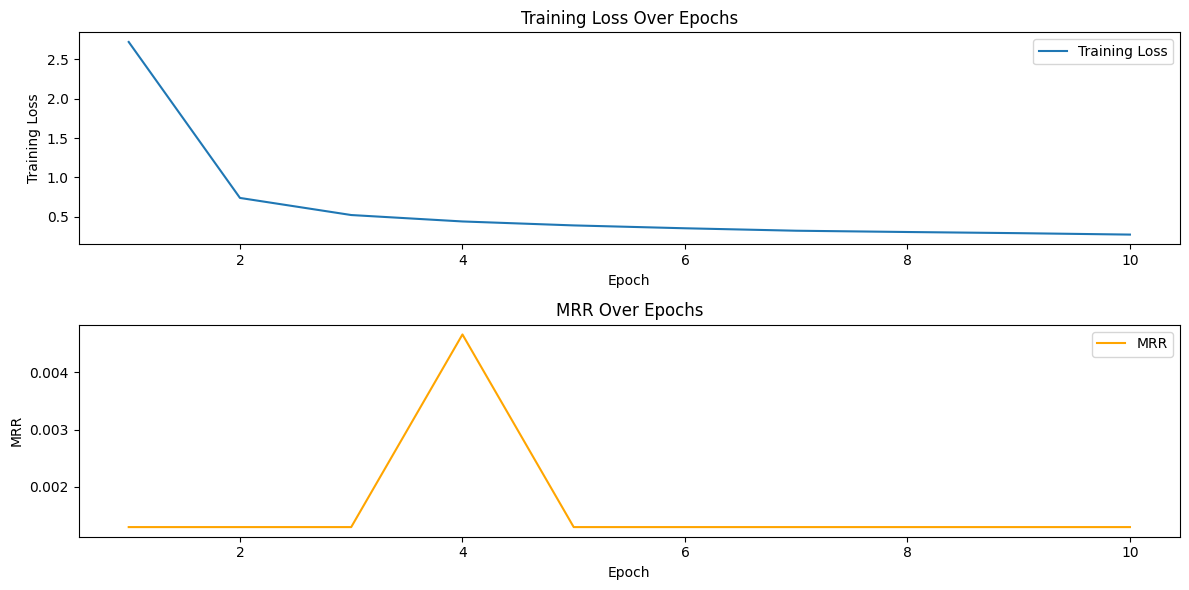

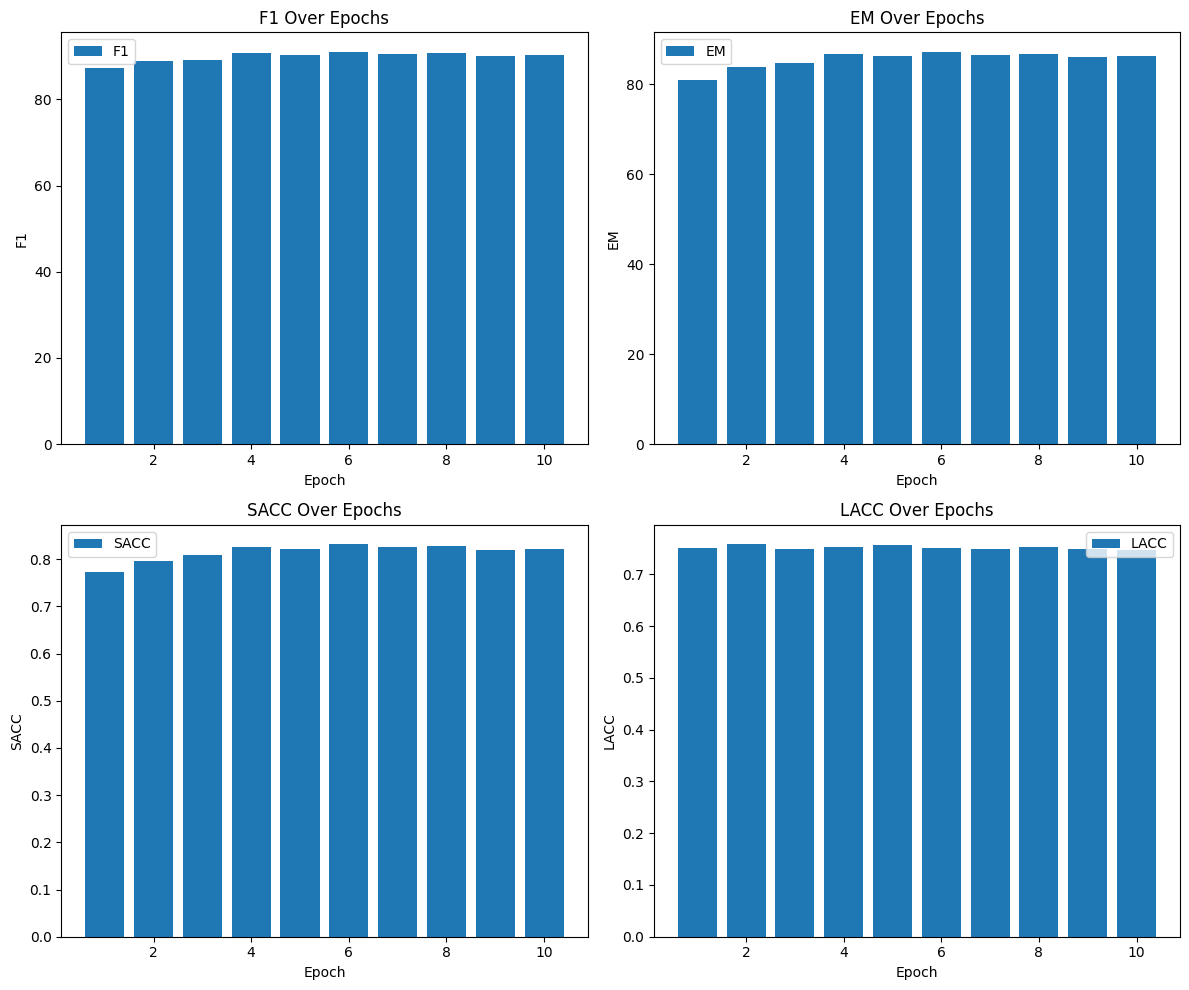

100%|██████████| 5450/5450 [15:16<00:00,  5.95it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:48,  6.93it/s]

Evaluation!


 10%|█         | 546/5450 [01:32<3:33:37,  2.61s/it]

Epoch 0 Metrics:
Training Loss: 2.819434809835132
EM: 80.45871559633028
F1: 87.13882076532096
MRR: 0.0012996941896024465
Lacc: 0.7440366972477064
Sacc: 0.7642201834862385


 20%|██        | 1090/5450 [02:54<10:09,  7.15it/s] 

Evaluation!


 20%|██        | 1091/5450 [03:02<3:09:33,  2.61s/it]

Epoch 1 Metrics:
Training Loss: 0.7502533567129472
EM: 83.6697247706422
F1: 89.09792405807951
MRR: 0.002981651376146789
Lacc: 0.755045871559633
Sacc: 0.7972477064220184


 30%|███       | 1635/5450 [04:25<08:42,  7.30it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:33<2:45:47,  2.61s/it]

Epoch 2 Metrics:
Training Loss: 0.48759676076369274
EM: 86.3302752293578
F1: 90.19580738690262
MRR: 0.0012996941896024465
Lacc: 0.751834862385321
Sacc: 0.818348623853211


 40%|████      | 2180/5450 [05:57<07:51,  6.93it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:05<2:22:12,  2.61s/it]

Epoch 3 Metrics:
Training Loss: 0.4206411347463898
EM: 87.79816513761467
F1: 91.14652944771642
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.8311926605504587


 50%|█████     | 2725/5450 [07:28<06:14,  7.28it/s]  

Evaluation!


 50%|█████     | 2726/5450 [07:37<1:58:58,  2.62s/it]

Epoch 4 Metrics:
Training Loss: 0.3553972554906835
EM: 86.3302752293578
F1: 89.66189870998258
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8174311926605504


 60%|██████    | 3270/5450 [08:59<05:09,  7.05it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:08<1:35:52,  2.64s/it]

Epoch 5 Metrics:
Training Loss: 0.3248414093869901
EM: 86.78899082568807
F1: 90.2263637613907
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8238532110091743


 70%|███████   | 3815/5450 [10:30<03:46,  7.21it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 6 Metrics:
Training Loss: 0.29887040325786507
EM: 86.97247706422019
F1: 90.16337924036517
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8275229357798165


 80%|████████  | 4360/5450 [12:02<02:32,  7.14it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:11<47:38,  2.63s/it]

Epoch 7 Metrics:
Training Loss: 0.2786181055771939
EM: 86.97247706422019
F1: 90.35924410309161
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8238532110091743


 90%|█████████ | 4905/5450 [13:34<01:16,  7.09it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.17it/s]


Epoch 8 Metrics:
Training Loss: 0.26835117487796506
EM: 87.33944954128441
F1: 90.42299100858165
MRR: 0.0021406727828746173
Lacc: 0.7504587155963303
Sacc: 0.8275229357798165


100%|██████████| 5450/5450 [15:05<00:00,  7.18it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.18it/s]


Epoch 9 Metrics:
Training Loss: 0.2563117603740416
EM: 86.69724770642202
F1: 90.03843229212872
MRR: 0.0021406727828746173
Lacc: 0.7486238532110092
Sacc: 0.8238532110091743
EM - Highest: 87.79816513761467, Lowest: 80.45871559633028, Average: 85.93577981651376
F1 - Highest: 91.14652944771642, Lowest: 87.13882076532096, Average: 89.84513907735601
MRR - Highest: 0.002981651376146789, Lowest: 0.0012996941896024465, Average: 0.0016360856269113148
Lacc - Highest: 0.755045871559633, Lowest: 0.7440366972477064, Average: 0.7494495412844037
Sacc - Highest: 0.8311926605504587, Lowest: 0.7642201834862385, Average: 0.8155045871559633


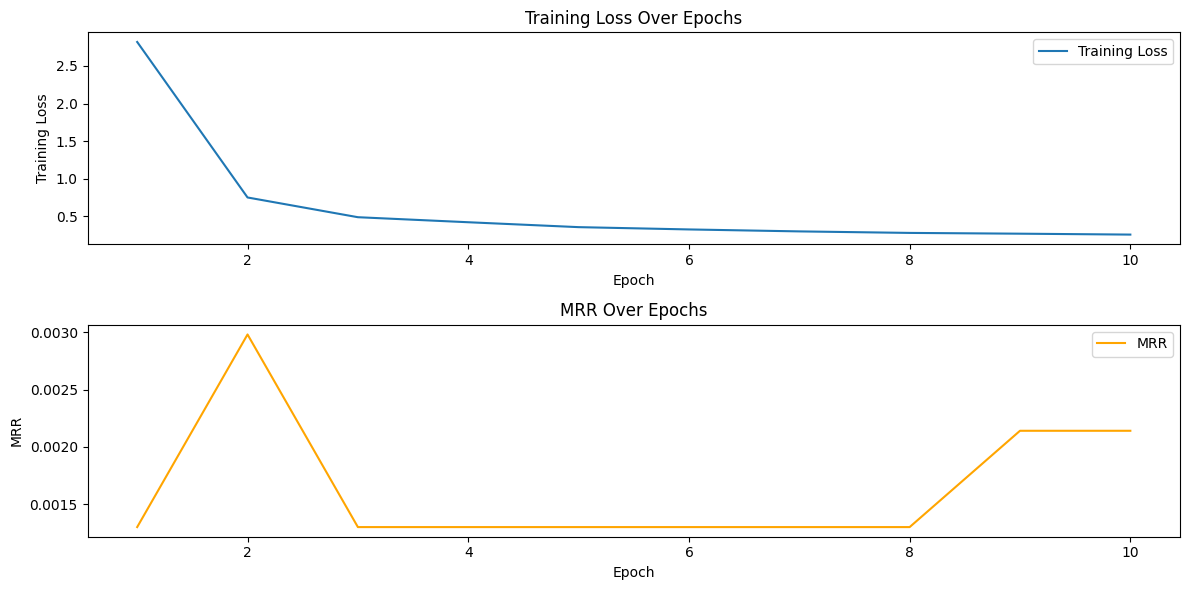

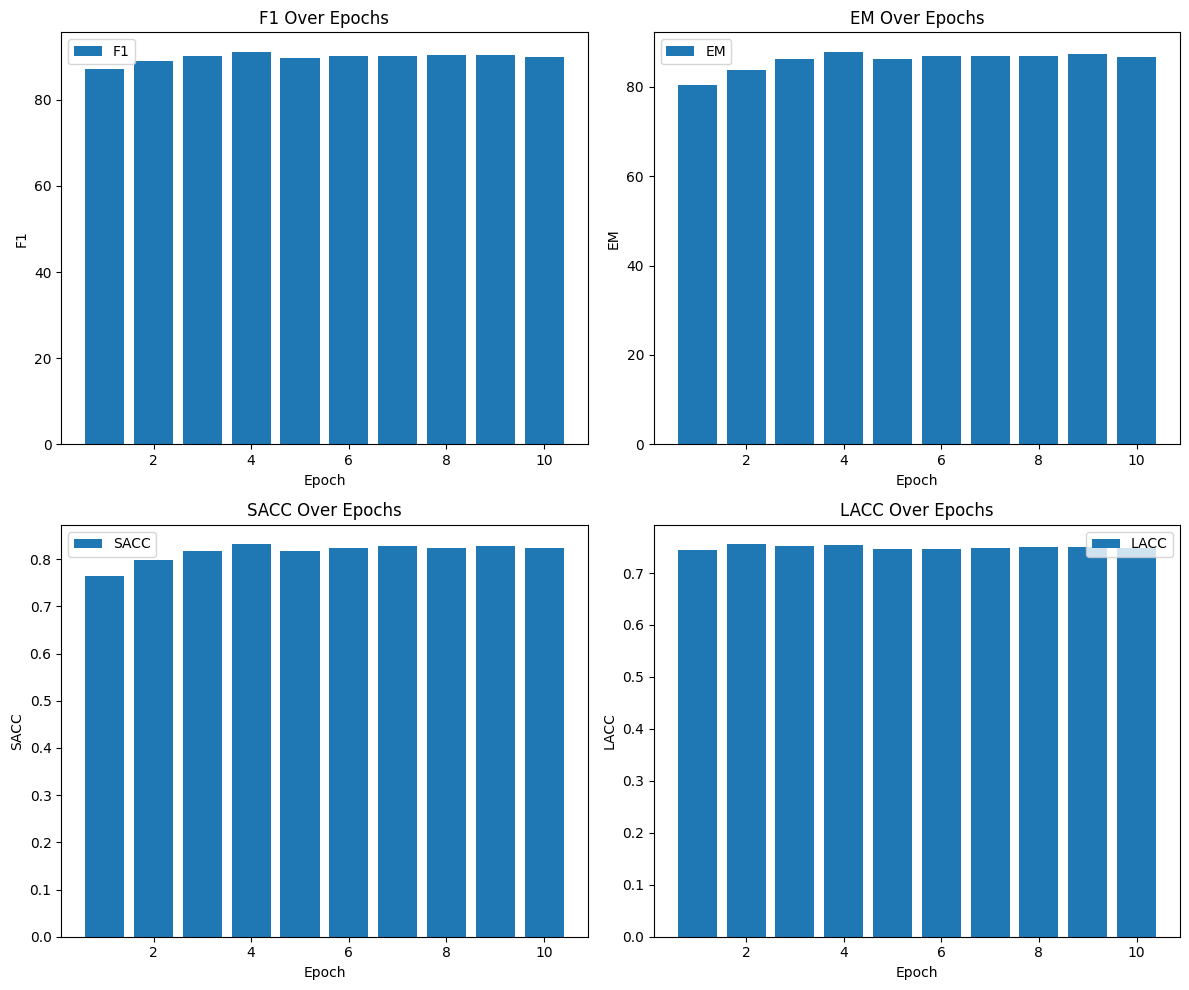

100%|██████████| 5450/5450 [15:14<00:00,  5.96it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:23,  7.18it/s]

Evaluation!


 10%|█         | 546/5450 [01:31<3:33:11,  2.61s/it]

Epoch 0 Metrics:
Training Loss: 2.7439513399786906
EM: 81.0091743119266
F1: 87.11394609483766
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.773394495412844


 20%|██        | 1090/5450 [02:55<10:05,  7.21it/s] 

Evaluation!


 20%|██        | 1091/5450 [03:03<3:09:57,  2.61s/it]

Epoch 1 Metrics:
Training Loss: 0.7711248048538462
EM: 84.58715596330275
F1: 89.24262692001348
MRR: 0.0012996941896024465
Lacc: 0.7513761467889908
Sacc: 0.8009174311926606


 30%|███       | 1635/5450 [04:26<08:41,  7.31it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 2 Metrics:
Training Loss: 0.5414634148257041
EM: 85.96330275229357
F1: 90.10470561603715
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8128440366972477


 40%|████      | 2180/5450 [05:57<07:38,  7.13it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:05<2:22:11,  2.61s/it]

Epoch 3 Metrics:
Training Loss: 0.4438034768079604
EM: 85.87155963302752
F1: 89.69465579140501
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8146788990825689


 50%|█████     | 2725/5450 [07:28<06:23,  7.11it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.24it/s]


Epoch 4 Metrics:
Training Loss: 0.3854713178034701
EM: 86.3302752293578
F1: 90.03936567136351
MRR: 0.0012996941896024465
Lacc: 0.7522935779816514
Sacc: 0.818348623853211


 60%|██████    | 3270/5450 [09:00<05:07,  7.10it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.14it/s]


Epoch 5 Metrics:
Training Loss: 0.3510079351548584
EM: 85.96330275229357
F1: 90.11710285653673
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8174311926605504


 70%|███████   | 3815/5450 [10:32<03:47,  7.19it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:40<1:10:44,  2.60s/it]

Epoch 6 Metrics:
Training Loss: 0.31935061639518725
EM: 87.1559633027523
F1: 90.5649669277712
MRR: 0.0021406727828746173
Lacc: 0.7564220183486239
Sacc: 0.8247706422018348


 80%|████████  | 4360/5450 [12:03<02:33,  7.09it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:11<47:19,  2.61s/it]

Epoch 7 Metrics:
Training Loss: 0.30957752292550705
EM: 87.43119266055047
F1: 90.84879013819989
MRR: 0.0012996941896024465
Lacc: 0.7545871559633027
Sacc: 0.8275229357798165


 90%|█████████ | 4905/5450 [13:34<01:15,  7.20it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.12it/s]


Epoch 8 Metrics:
Training Loss: 0.2866122757855786
EM: 86.97247706422019
F1: 90.61594398333538
MRR: 0.0012996941896024465
Lacc: 0.7532110091743119
Sacc: 0.8247706422018348


100%|██████████| 5450/5450 [15:07<00:00,  7.14it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.07it/s]


Epoch 9 Metrics:
Training Loss: 0.27740279215776764
EM: 87.24770642201835
F1: 90.74648927901828
MRR: 0.0012996941896024465
Lacc: 0.7559633027522936
Sacc: 0.826605504587156
EM - Highest: 87.43119266055047, Lowest: 81.0091743119266, Average: 85.85321100917432
F1 - Highest: 90.84879013819989, Lowest: 87.11394609483766, Average: 89.90885932785181
MRR - Highest: 0.0021406727828746173, Lowest: 0.0012996941896024465, Average: 0.0013837920489296637
Lacc - Highest: 0.7564220183486239, Lowest: 0.748165137614679, Average: 0.7522935779816514
Sacc - Highest: 0.8275229357798165, Lowest: 0.773394495412844, Average: 0.8141284403669726


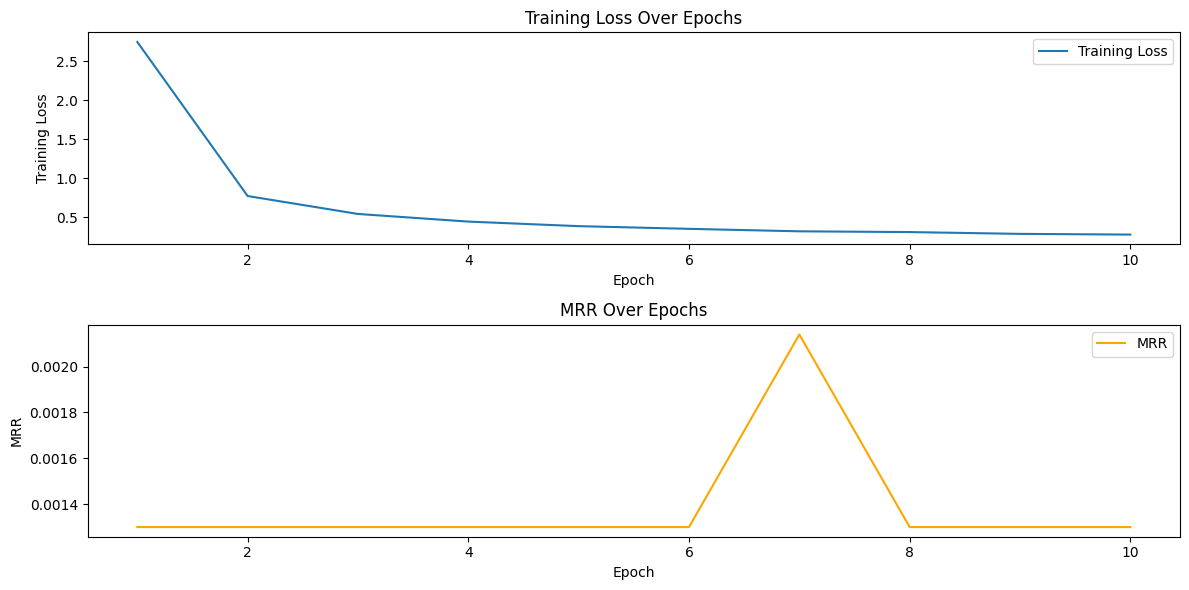

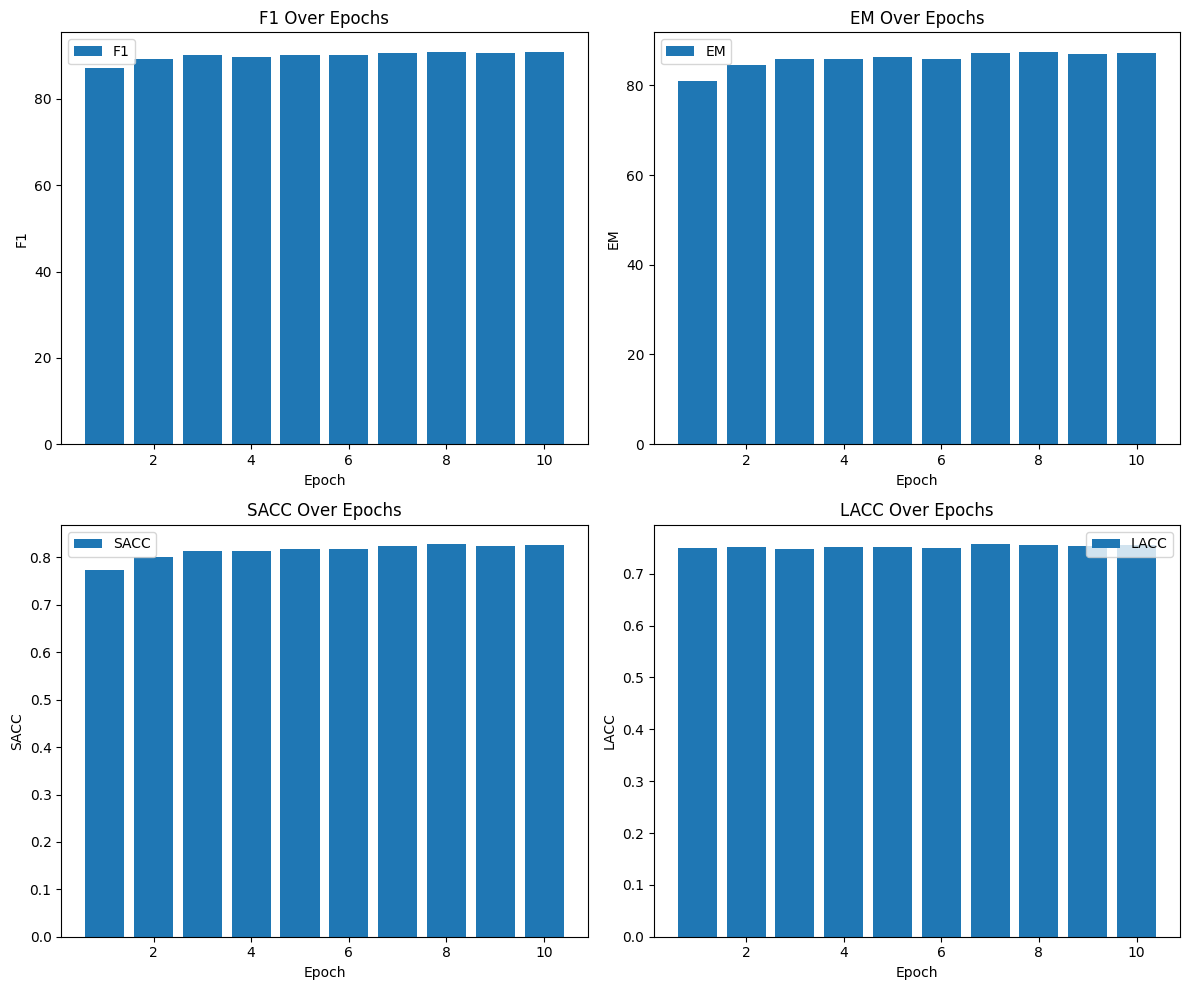

100%|██████████| 5450/5450 [15:16<00:00,  5.94it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:27,  7.14it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.21it/s]


Epoch 0 Metrics:
Training Loss: 2.7312753318920047
EM: 80.36697247706422
F1: 86.92789231368941
MRR: 0.0012996941896024465
Lacc: 0.7573394495412844
Sacc: 0.7669724770642202


 20%|██        | 1090/5450 [02:54<10:04,  7.21it/s] 

Evaluation!


 20%|██        | 1091/5450 [03:02<3:09:19,  2.61s/it]

Epoch 1 Metrics:
Training Loss: 0.7483868330204432
EM: 85.41284403669725
F1: 90.11614581542987
MRR: 0.0012996941896024465
Lacc: 0.7495412844036697
Sacc: 0.8073394495412844


 30%|███       | 1635/5450 [04:25<08:51,  7.18it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.21it/s]


Epoch 2 Metrics:
Training Loss: 0.5095464596934959
EM: 85.59633027522936
F1: 90.26706253800663
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8091743119266055


 40%|████      | 2180/5450 [05:57<07:45,  7.02it/s]  

Evaluation!


 40%|████      | 2181/5450 [06:06<2:22:26,  2.61s/it]

Epoch 3 Metrics:
Training Loss: 0.4102663077102171
EM: 85.41284403669725
F1: 89.65131281228066
MRR: 0.0012996941896024465
Lacc: 0.7444954128440368
Sacc: 0.8128440366972477


 50%|█████     | 2725/5450 [07:28<06:24,  7.09it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.24it/s]


Epoch 4 Metrics:
Training Loss: 0.35497462014676234
EM: 86.23853211009174
F1: 90.17499321738902
MRR: 0.0012996941896024465
Lacc: 0.7408256880733946
Sacc: 0.8165137614678899


 60%|██████    | 3270/5450 [08:59<05:04,  7.16it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:07<1:35:06,  2.62s/it]

Epoch 5 Metrics:
Training Loss: 0.3133175974079502
EM: 86.42201834862385
F1: 89.88633931226124
MRR: 0.0012996941896024465
Lacc: 0.7426605504587156
Sacc: 0.8192660550458716


 70%|███████   | 3815/5450 [10:31<03:50,  7.10it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:39<1:11:06,  2.61s/it]

Epoch 6 Metrics:
Training Loss: 0.29197692276158055
EM: 86.60550458715596
F1: 90.59921212973526
MRR: 0.0012996941896024465
Lacc: 0.744954128440367
Sacc: 0.8220183486238533


 80%|████████  | 4360/5450 [12:02<02:34,  7.04it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.11it/s]


Epoch 7 Metrics:
Training Loss: 0.27426096113108167
EM: 87.06422018348624
F1: 90.7588198733178
MRR: 0.0012996941896024465
Lacc: 0.7403669724770642
Sacc: 0.8247706422018348


 90%|█████████ | 4905/5450 [13:33<01:17,  7.04it/s]

Evaluation!


 90%|█████████ | 4906/5450 [13:42<23:37,  2.61s/it]

Epoch 8 Metrics:
Training Loss: 0.2569914052088813
EM: 86.97247706422019
F1: 90.37386950710507
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8256880733944955


100%|██████████| 5450/5450 [15:04<00:00,  7.08it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.22it/s]


Epoch 9 Metrics:
Training Loss: 0.24372104614238263
EM: 86.97247706422019
F1: 90.5284373379675
MRR: 0.0012996941896024465
Lacc: 0.7431192660550459
Sacc: 0.8247706422018348
EM - Highest: 87.06422018348624, Lowest: 80.36697247706422, Average: 85.70642201834862
F1 - Highest: 90.7588198733178, Lowest: 86.92789231368941, Average: 89.92840848571824
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7573394495412844, Lowest: 0.7403669724770642, Average: 0.7462844036697247
Sacc - Highest: 0.8256880733944955, Lowest: 0.7669724770642202, Average: 0.8129357798165138


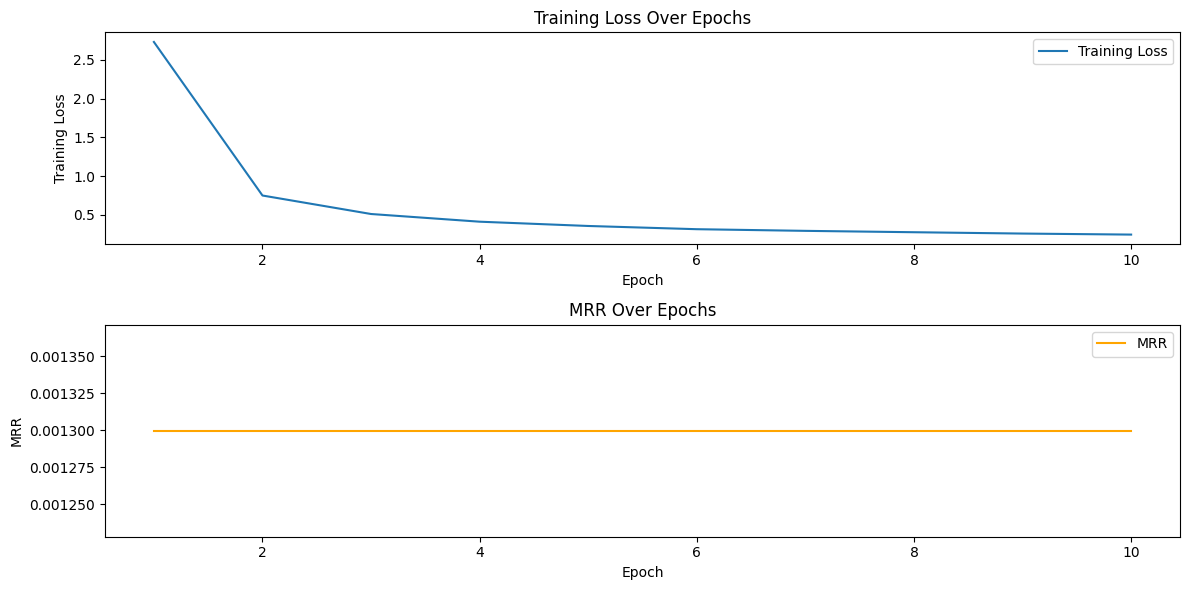

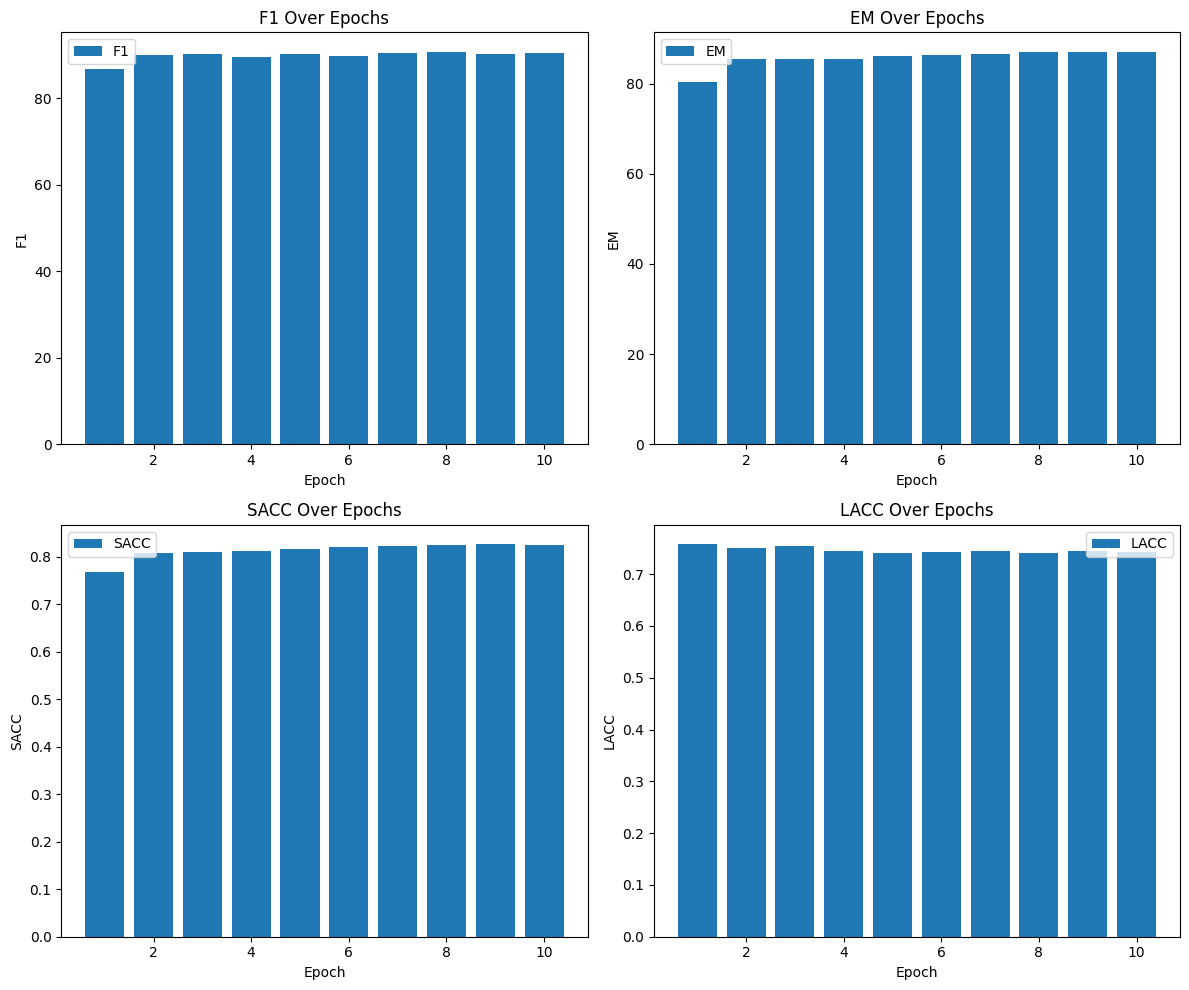

100%|██████████| 5450/5450 [15:14<00:00,  5.96it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:54,  6.87it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.19it/s]


Epoch 0 Metrics:
Training Loss: 2.6753906060796266
EM: 81.92660550458716
F1: 88.03770267195704
MRR: 0.005504587155963303
Lacc: 0.7504587155963303
Sacc: 0.7779816513761468


 20%|██        | 1090/5450 [02:55<10:33,  6.89it/s] 

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.19it/s]


Epoch 1 Metrics:
Training Loss: 0.6854208881325952
EM: 81.55963302752293
F1: 88.38944865038947
MRR: 0.0012996941896024465
Lacc: 0.7394495412844037
Sacc: 0.7697247706422018


 30%|███       | 1635/5450 [04:26<08:48,  7.22it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:35<2:45:53,  2.61s/it]

Epoch 2 Metrics:
Training Loss: 0.48429512028847266
EM: 84.77064220183486
F1: 89.46513110528075
MRR: 0.0012996941896024465
Lacc: 0.7472477064220183
Sacc: 0.8018348623853211


 40%|████      | 2180/5450 [05:57<07:45,  7.03it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.20it/s]


Epoch 3 Metrics:
Training Loss: 0.4020958247756876
EM: 85.77981651376147
F1: 89.73236546293603
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8128440366972477


 50%|█████     | 2725/5450 [07:29<06:22,  7.12it/s]  

Evaluation!


 50%|█████     | 2726/5450 [07:37<1:58:12,  2.60s/it]

Epoch 4 Metrics:
Training Loss: 0.3517944225870551
EM: 85.13761467889908
F1: 89.27317010372778
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8064220183486238


 60%|██████    | 3270/5450 [09:01<05:08,  7.07it/s]  

Evaluation!


 60%|██████    | 3271/5450 [09:09<1:34:57,  2.61s/it]

Epoch 5 Metrics:
Training Loss: 0.31079199243477895
EM: 86.88073394495413
F1: 90.3719168953111
MRR: 0.0012996941896024465
Lacc: 0.7458715596330275
Sacc: 0.8192660550458716


 70%|███████   | 3815/5450 [10:32<03:45,  7.24it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:40<1:11:01,  2.61s/it]

Epoch 6 Metrics:
Training Loss: 0.2928756705478876
EM: 84.86238532110092
F1: 89.49257485776187
MRR: 0.0012996941896024465
Lacc: 0.7339449541284404
Sacc: 0.8


 80%|████████  | 4360/5450 [12:03<02:38,  6.90it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:11<47:30,  2.62s/it]

Epoch 7 Metrics:
Training Loss: 0.2801279873226197
EM: 85.59633027522936
F1: 89.60402412322175
MRR: 0.0012996941896024465
Lacc: 0.7371559633027523
Sacc: 0.808256880733945


 90%|█████████ | 4905/5450 [13:34<01:16,  7.10it/s]

Evaluation!


 90%|█████████ | 4906/5450 [13:43<23:41,  2.61s/it]

Epoch 8 Metrics:
Training Loss: 0.26333723166325224
EM: 86.23853211009174
F1: 89.79989483885413
MRR: 0.0012996941896024465
Lacc: 0.7357798165137615
Sacc: 0.8110091743119267


100%|██████████| 5450/5450 [15:06<00:00,  7.12it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.26it/s]


Epoch 9 Metrics:
Training Loss: 0.24854643662158965
EM: 86.14678899082568
F1: 89.7295584474168
MRR: 0.0012996941896024465
Lacc: 0.736697247706422
Sacc: 0.8119266055045872
EM - Highest: 86.88073394495413, Lowest: 81.55963302752293, Average: 84.88990825688073
F1 - Highest: 90.3719168953111, Lowest: 88.03770267195704, Average: 89.38957871568567
MRR - Highest: 0.005504587155963303, Lowest: 0.0012996941896024465, Average: 0.0017201834862385322
Lacc - Highest: 0.7504587155963303, Lowest: 0.7339449541284404, Average: 0.7422477064220183
Sacc - Highest: 0.8192660550458716, Lowest: 0.7697247706422018, Average: 0.8019266055045872


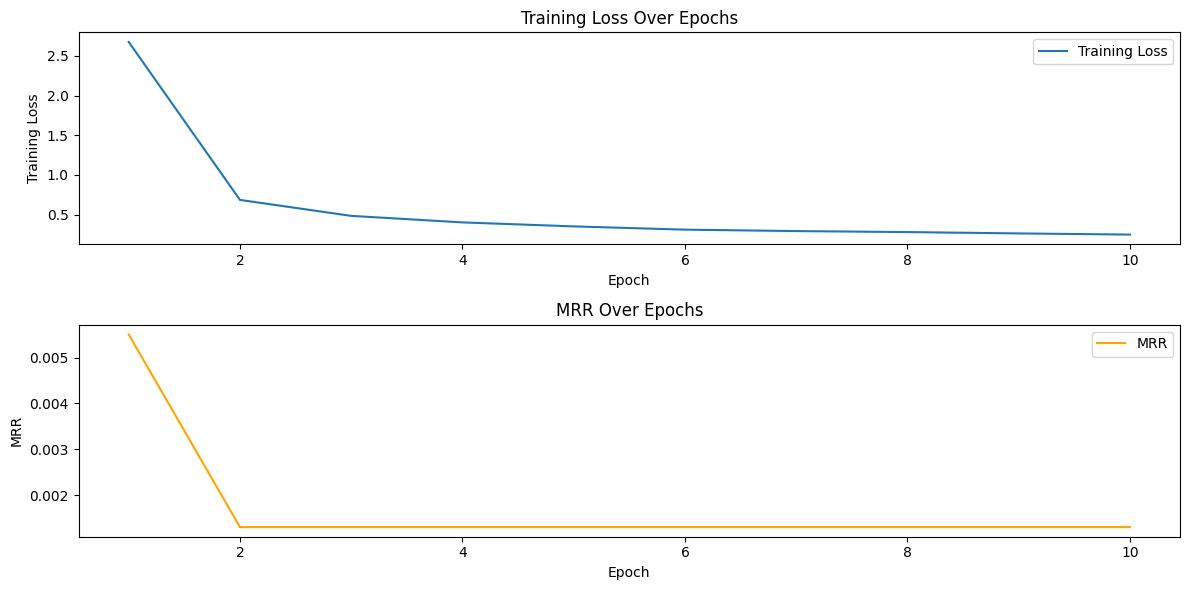

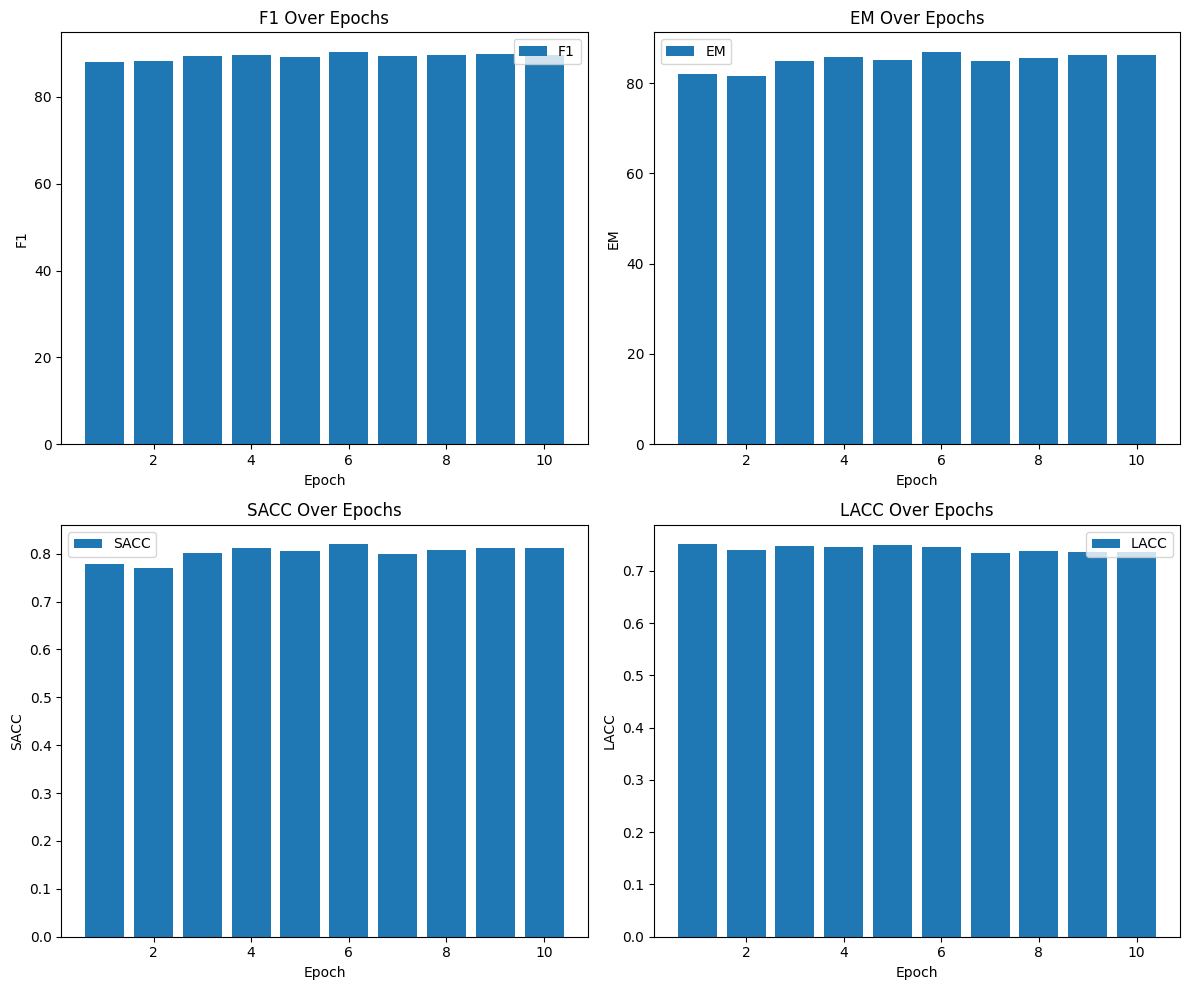

100%|██████████| 5450/5450 [15:16<00:00,  5.95it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:17,  7.24it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.20it/s]


Epoch 0 Metrics:
Training Loss: 2.7782553199644484
EM: 78.44036697247707
F1: 85.84703303209403
MRR: 0.0012996941896024465
Lacc: 0.755045871559633
Sacc: 0.7495412844036697


 20%|██        | 1090/5450 [02:54<10:17,  7.06it/s] 

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 1 Metrics:
Training Loss: 0.7456460264878809
EM: 83.76146788990826
F1: 88.89436453860273
MRR: 0.0012996941896024465
Lacc: 0.7605504587155963
Sacc: 0.7954128440366972


 30%|███       | 1635/5450 [04:26<09:02,  7.03it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:34<2:46:35,  2.62s/it]

Epoch 2 Metrics:
Training Loss: 0.5010498505444565
EM: 84.6788990825688
F1: 89.04534451797778
MRR: 0.0012996941896024465
Lacc: 0.7522935779816514
Sacc: 0.8045871559633028


 40%|████      | 2180/5450 [05:57<07:32,  7.22it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.14it/s]


Epoch 3 Metrics:
Training Loss: 0.4286305544009313
EM: 85.87155963302752
F1: 89.59332558574185
MRR: 0.0012996941896024465
Lacc: 0.7486238532110092
Sacc: 0.8137614678899082


 50%|█████     | 2725/5450 [07:28<06:15,  7.25it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.27it/s]


Epoch 4 Metrics:
Training Loss: 0.3668336143721442
EM: 86.97247706422019
F1: 90.22827130997933
MRR: 0.0012996941896024465
Lacc: 0.7509174311926605
Sacc: 0.8238532110091743


 60%|██████    | 3270/5450 [08:59<05:04,  7.16it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.12it/s]


Epoch 5 Metrics:
Training Loss: 0.33537469078902016
EM: 86.42201834862385
F1: 89.76146812679724
MRR: 0.0012996941896024465
Lacc: 0.7435779816513761
Sacc: 0.8165137614678899


 70%|███████   | 3815/5450 [10:31<03:50,  7.11it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:39<1:11:21,  2.62s/it]

Epoch 6 Metrics:
Training Loss: 0.31184639754628235
EM: 86.42201834862385
F1: 90.23085551958913
MRR: 0.0012996941896024465
Lacc: 0.748165137614679
Sacc: 0.8165137614678899


 80%|████████  | 4360/5450 [12:03<02:31,  7.19it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.20it/s]


Epoch 7 Metrics:
Training Loss: 0.28912057412634473
EM: 86.5137614678899
F1: 90.20448273224707
MRR: 0.0012996941896024465
Lacc: 0.7440366972477064
Sacc: 0.8155963302752294


 90%|█████████ | 4905/5450 [13:34<01:15,  7.22it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.32it/s]


Epoch 8 Metrics:
Training Loss: 0.27669143676821895
EM: 86.05504587155963
F1: 89.95836697236983
MRR: 0.0012996941896024465
Lacc: 0.7426605504587156
Sacc: 0.8137614678899082


100%|██████████| 5450/5450 [15:05<00:00,  7.05it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.23it/s]


Epoch 9 Metrics:
Training Loss: 0.261926628980965
EM: 86.3302752293578
F1: 90.00340781328224
MRR: 0.0012996941896024465
Lacc: 0.744954128440367
Sacc: 0.8155963302752294
EM - Highest: 86.97247706422019, Lowest: 78.44036697247707, Average: 85.14678899082568
F1 - Highest: 90.23085551958913, Lowest: 85.84703303209403, Average: 89.37669201486813
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7605504587155963, Lowest: 0.7426605504587156, Average: 0.7490825688073394
Sacc - Highest: 0.8238532110091743, Lowest: 0.7495412844036697, Average: 0.80651376146789


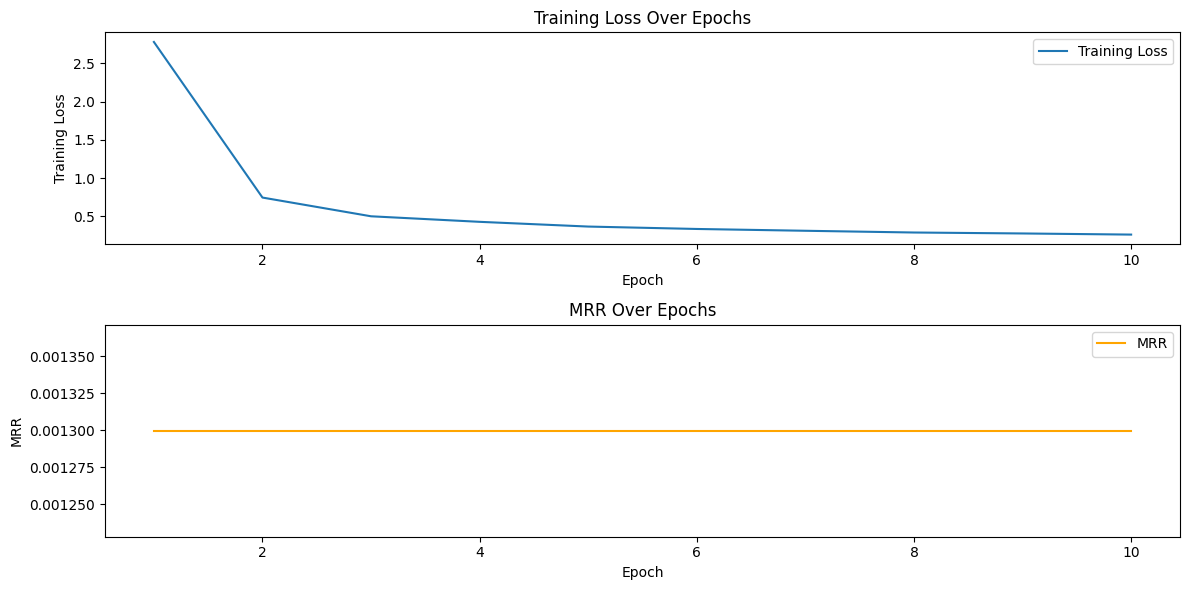

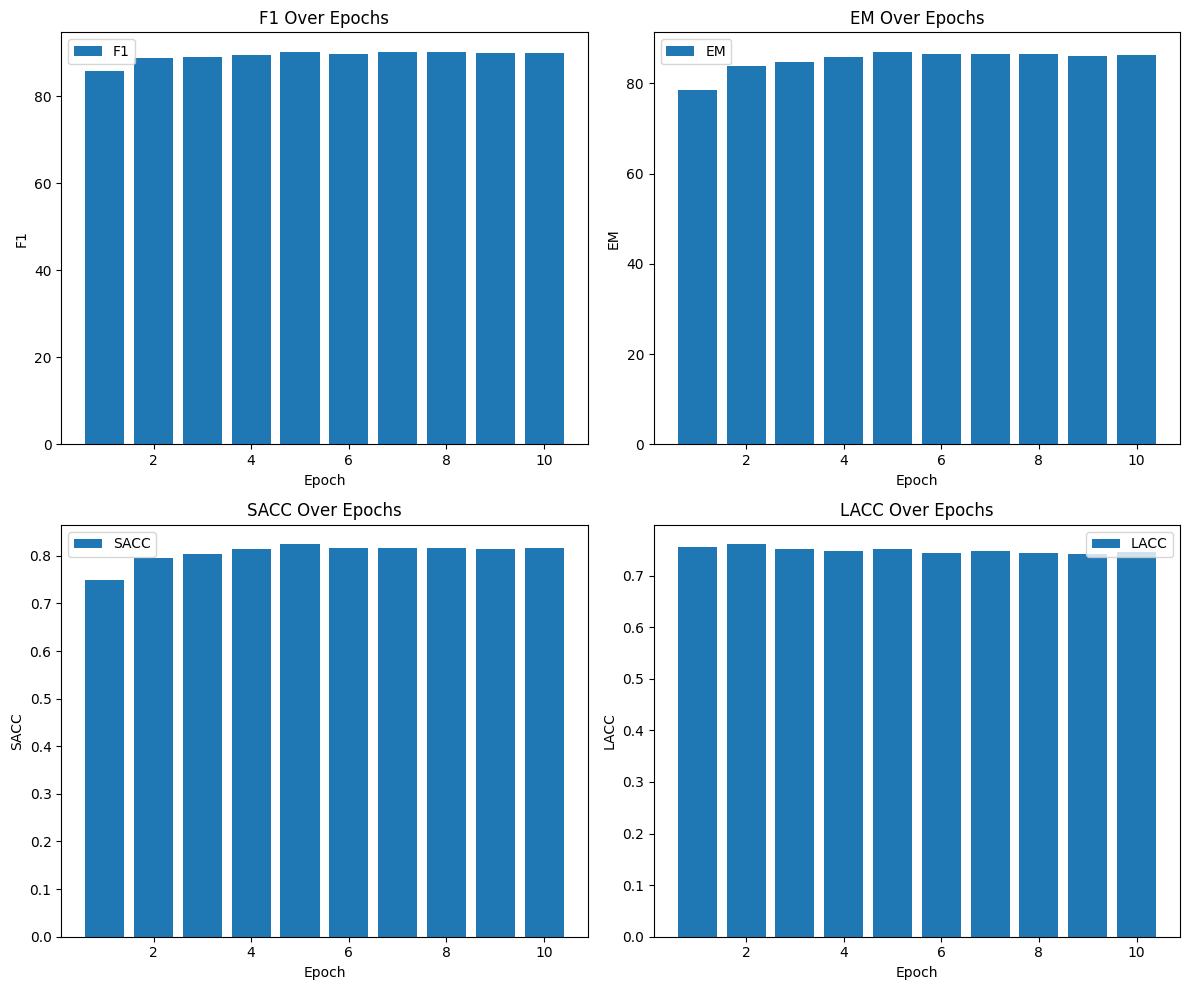

100%|██████████| 5450/5450 [15:15<00:00,  5.96it/s]
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 545/5450 [01:23<11:18,  7.23it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.15it/s]


Epoch 0 Metrics:
Training Loss: 2.6444006824985555
EM: 82.8440366972477
F1: 88.82908702364898
MRR: 0.0012996941896024465
Lacc: 0.7573394495412844
Sacc: 0.781651376146789


 20%|██        | 1090/5450 [02:55<10:18,  7.05it/s] 

Evaluation!


 20%|██        | 1091/5450 [03:03<3:09:44,  2.61s/it]

Epoch 1 Metrics:
Training Loss: 0.7130570060206116
EM: 86.05504587155963
F1: 90.07359448233973
MRR: 0.0012996941896024465
Lacc: 0.7697247706422018
Sacc: 0.8146788990825689


 30%|███       | 1635/5450 [04:26<08:48,  7.21it/s]  

Evaluation!


 30%|███       | 1636/5450 [04:34<2:45:35,  2.61s/it]

Epoch 2 Metrics:
Training Loss: 0.5094795062830415
EM: 85.96330275229357
F1: 90.05165089429426
MRR: 0.0012996941896024465
Lacc: 0.7545871559633027
Sacc: 0.8119266055045872


 40%|████      | 2180/5450 [05:57<07:37,  7.14it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.19it/s]


Epoch 3 Metrics:
Training Loss: 0.41449790203157777
EM: 84.6788990825688
F1: 89.35357421340873
MRR: 0.0012996941896024465
Lacc: 0.7541284403669725
Sacc: 0.8045871559633028


 50%|█████     | 2725/5450 [07:29<06:24,  7.09it/s]  

Evaluation!


 50%|█████     | 2726/5450 [07:38<1:58:36,  2.61s/it]

Epoch 4 Metrics:
Training Loss: 0.3706152341042329
EM: 86.78899082568807
F1: 90.03603785000085
MRR: 0.0012996941896024465
Lacc: 0.75
Sacc: 0.8165137614678899


 60%|██████    | 3270/5450 [09:00<05:06,  7.12it/s]  

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.27it/s]


Epoch 5 Metrics:
Training Loss: 0.33834957973967483
EM: 86.05504587155963
F1: 89.72925173397931
MRR: 0.0012996941896024465
Lacc: 0.7490825688073395
Sacc: 0.8119266055045872


 70%|███████   | 3815/5450 [10:31<03:46,  7.22it/s]  

Evaluation!


 70%|███████   | 3816/5450 [10:40<1:11:21,  2.62s/it]

Epoch 6 Metrics:
Training Loss: 0.31224319003543755
EM: 85.5045871559633
F1: 89.15040334937653
MRR: 0.0012996941896024465
Lacc: 0.7454128440366973
Sacc: 0.8064220183486238


 80%|████████  | 4360/5450 [12:03<02:34,  7.08it/s]  

Evaluation!


 80%|████████  | 4361/5450 [12:11<47:27,  2.62s/it]

Epoch 7 Metrics:
Training Loss: 0.2916533001126089
EM: 85.5045871559633
F1: 89.23294070555822
MRR: 0.0012996941896024465
Lacc: 0.7412844036697248
Sacc: 0.8055045871559633


 90%|█████████ | 4905/5450 [13:35<01:16,  7.16it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.19it/s]


Epoch 8 Metrics:
Training Loss: 0.2827454941150724
EM: 85.68807339449542
F1: 89.290521072273
MRR: 0.0012996941896024465
Lacc: 0.744954128440367
Sacc: 0.8091743119266055


100%|██████████| 5450/5450 [15:06<00:00,  7.11it/s]

Evaluation!


100%|██████████| 137/137 [00:06<00:00, 21.18it/s]


Epoch 9 Metrics:
Training Loss: 0.2607656376584809
EM: 85.96330275229357
F1: 89.42288909613433
MRR: 0.0012996941896024465
Lacc: 0.744954128440367
Sacc: 0.8119266055045872
EM - Highest: 86.78899082568807, Lowest: 82.8440366972477, Average: 85.5045871559633
F1 - Highest: 90.07359448233973, Lowest: 88.82908702364898, Average: 89.5169950421014
MRR - Highest: 0.0012996941896024465, Lowest: 0.0012996941896024465, Average: 0.0012996941896024467
Lacc - Highest: 0.7697247706422018, Lowest: 0.7412844036697248, Average: 0.7511467889908257
Sacc - Highest: 0.8165137614678899, Lowest: 0.781651376146789, Average: 0.8074311926605503


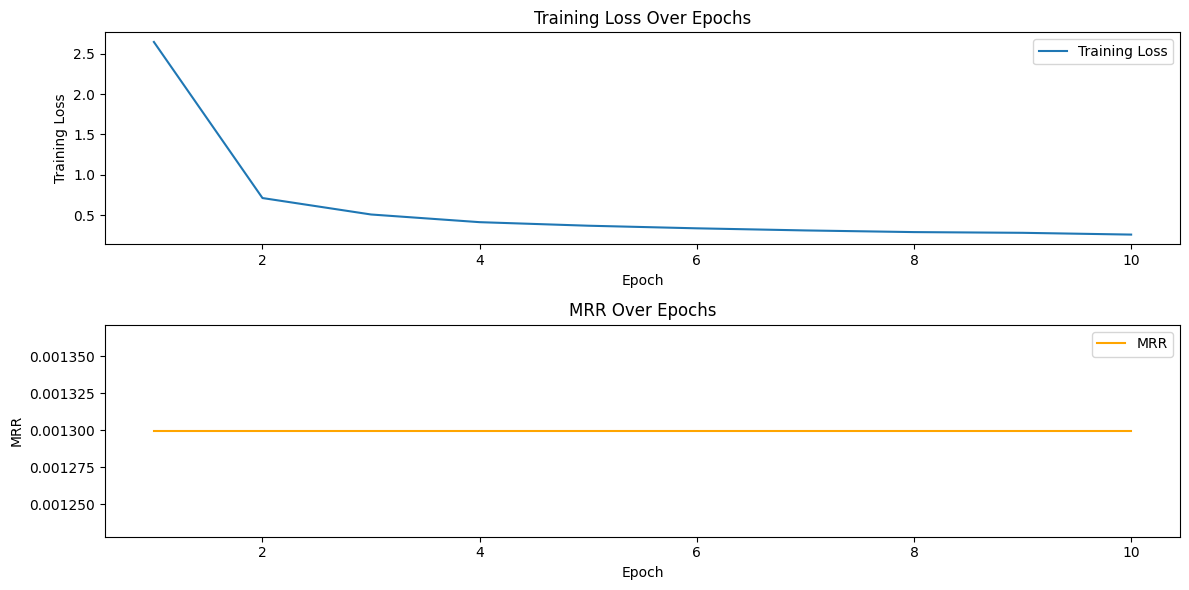

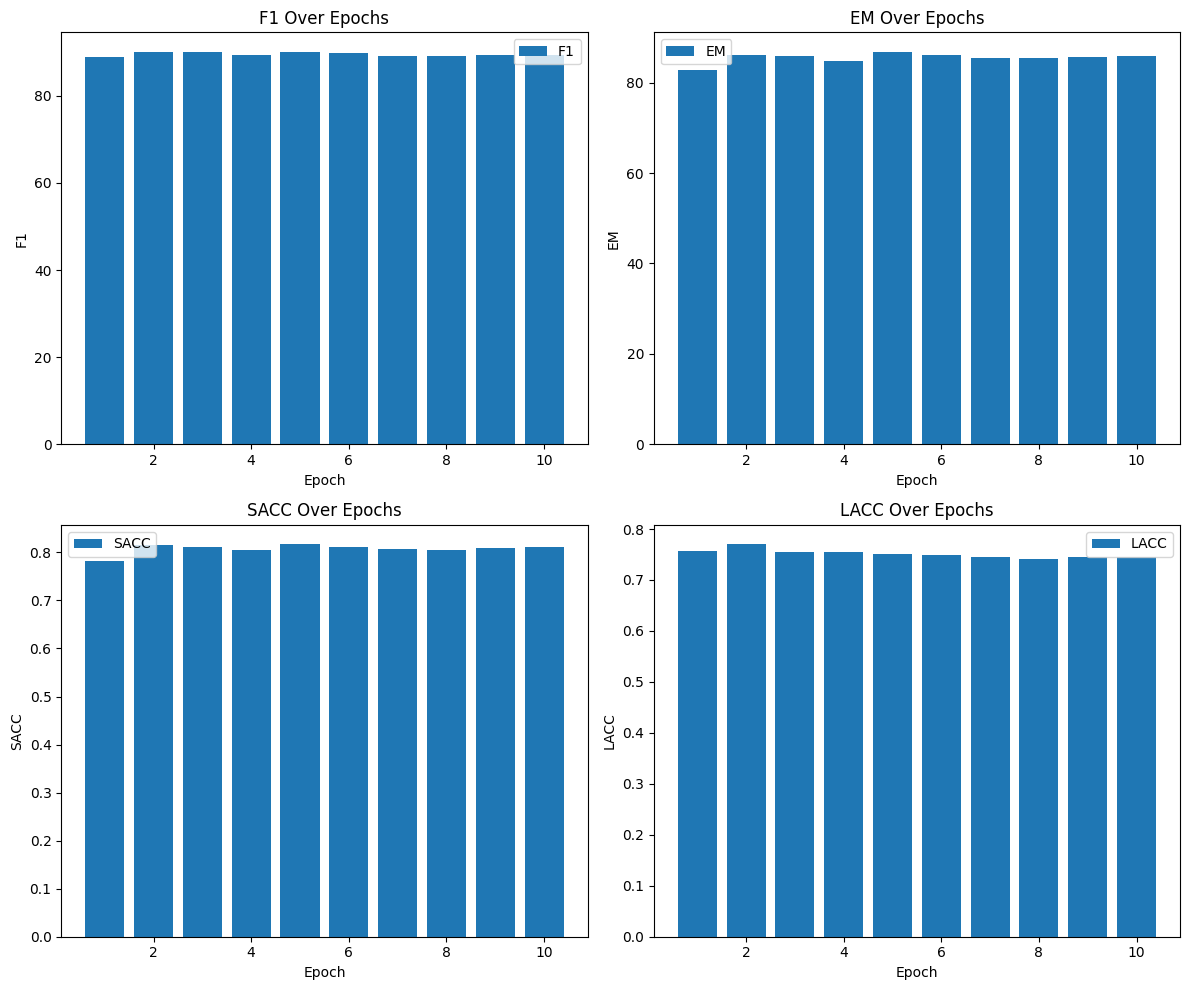

100%|██████████| 5450/5450 [15:16<00:00,  5.95it/s]


In [50]:
# import matplotlib.pyplot as plt

# 13
# Directory to save models
save_dir = 'biobert_ner_re_bilstm_bag_finetuned'


# Number of epochs for training
num_train_epochs = 10
# Train and save models
# bootstrap_samples = bootstrap_sampling(train_dataset, n_samples=10)
for i, train_data in enumerate(bootstrap_samples):
    train_and_save_model(train_data, validation_dataset, model_checkpoint, custom_collate_fn, CustomDataset, set_format, compute_metrics, raw_val_dataset, save_dir, i, num_train_epochs)

In [51]:
class EnsembleModel(PreTrainedModel):
    def __init__(self, config, model_paths):
        super().__init__(config)
        self.models = [self.load_custom_model(path) for path in model_paths]

    @staticmethod
    def load_custom_model(path):
        model_checkpoint = "bert-base-uncased"  # replace with the actual checkpoint used
        model = CustomBiLSTMModel(model_checkpoint)
        model.load_state_dict(torch.load(path, map_location=torch.device('cuda')))
        return model

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *model_args, **kwargs):
        config = AutoConfig.from_pretrained(pretrained_model_name_or_path, *model_args, **kwargs)
        model_paths = kwargs.pop("model_paths", None)
        return cls(config, model_paths)

    def forward(self, *args, **kwargs):
        outputs = [model(*args, **kwargs) for model in self.models]
        start_logits = torch.mean(torch.stack([output[0] for output in outputs]), dim=0)
        end_logits = torch.mean(torch.stack([output[1] for output in outputs]), dim=0)
        return start_logits, end_logits

In [52]:
# Directory where models are saved
# 14
save_dir = 'biobert_ner_re_bilstm_bag_finetuned'

# List of paths to the saved model files
model_paths = [
    os.path.join(save_dir, f"model_{i}.pt") for i in range(10)
]

# Load ensemble model
ensemble_model = EnsembleModel.from_pretrained(model_checkpoint, model_paths=model_paths)
ensemble_tokenizer = AutoTokenizer.from_pretrained(save_dir)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_ner and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at biobert_model_re and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: [

In [53]:
def evaluate_ensemble(model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    start_logits_list = []
    end_logits_list = []

    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)
            start_logits_list.append(outputs[0].cpu().numpy())
            end_logits_list.append(outputs[1].cpu().numpy())

    start_logits = np.concatenate(start_logits_list)[:len(validation_dataset)]
    end_logits = np.concatenate(end_logits_list)[:len(validation_dataset)]

    metrics = compute_metrics(start_logits, end_logits, validation_dataset, raw_val_dataset)

    print("Ensemble Model Metrics:")
    print(f"EM: {metrics['exact_match']}")
    print(f"F1: {metrics['f1']}")
    print(f"MRR: {metrics['mrr']}")
    print(f"Lacc: {metrics['lacc']}")
    print(f"Sacc: {metrics['sacc']}")

    return metrics

# Evaluate ensemble
ensemble_metrics = evaluate_ensemble(ensemble_model, validation_dataset, eval_dataloader, compute_metrics, raw_val_dataset)

Ensemble Model Metrics:
EM: 88.62385321100918
F1: 91.54693747582634
MRR: 0.0012996941896024465
Lacc: 0.7467889908256881
Sacc: 0.8366972477064221


In [54]:
# # from transformers import pipeline
# # Create the question answering pipeline
# question_answerer = pipeline("question-answering", model=ensemble_model, tokenizer=ensemble_tokenizer)

# # People with diabetes experience blurry vision because of what?
# # What are the symptoms of blurry vision for diabetes people?
# # Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications.
# question = "What are the symptoms of blurry vision for diabetes people?"
# context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."


# # Perform question answering
# answer = question_answerer(question=question, context=context)
# print(answer)


# Garbage

In [55]:
# from transformers import Pipeline
# from transformers.pipelines import QuestionAnsweringPipeline

# class CustomQuestionAnsweringPipeline(QuestionAnsweringPipeline):
#     def __init__(self, model, tokenizer, **kwargs):
#         super().__init__(model=model, tokenizer=tokenizer, **kwargs)

#     def __call__(self, *args, **kwargs):
#         return super().__call__(*args, **kwargs)


In [56]:


# # Load ensemble model and tokenizer
# # ensemble_model = EnsembleModel.from_pretrained("path_to_ensemble_model_directory", model_paths=model_paths)
# # ensemble_tokenizer = AutoTokenizer.from_pretrained("path_to_ensemble_model_directory")

# # # Create question answering pipeline
# # question_answerer = pipeline("question-answering", model=ensemble_model, tokenizer=ensemble_tokenizer)

# # # Example inference
# # question = "What are the consequences of blurry vision for diabetes people?"
# # context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."

# # answer = question_answerer(question=question, context=context)
# # print(answer)



# # Create custom question answering pipeline
# question_answerer = CustomQuestionAnsweringPipeline(model=ensemble_model, tokenizer=ensemble_tokenizer)

# # Example inference
# question = "What are the consequences of blurry vision for diabetes people?"
# context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."

# answer = question_answerer(question=question, context=context)
# print(answer)


In [57]:
# # Create custom question answering pipeline
# question_answerer = CustomQuestionAnsweringPipeline(model=ensemble_model, tokenizer=ensemble_tokenizer)

# # Example inference
# question = "Which hormone abnormalities are characteristic to Pendred syndrome?"
# context = "DOCA sensitive pendrin expression in kidney, heart, lung and thyroid tissues. BACKGROUND/AIMS: Pendrin (SLC26A4), a transporter accomplishing anion exchange, is expressed in inner ear, thyroid gland, kidneys, lung, liver and heart. Loss or reduction of function mutations of SLC26A4 underlie Pendred syndrome, a disorder invariably leading to hearing loss with enlarged vestibular aqueducts and in some patients to hypothyroidism and goiter. Renal pendrin expression is up-regulated by mineralocorticoids such as aldosterone or deoxycorticosterone (DOCA). Little is known about the impact of mineralocorticoids on pendrin expression in extrarenal tissues. METHODS: The present study utilized RT-qPCR and Western blotting to quantify the transcript levels and protein abundance of Slc26a4 in murine kidney, thyroid, heart and lung prior to and following subcutaneous administration of 100 mg/kg DOCA. RESULTS: Slc26a4 transcript levels as compared to Gapdh transcript levels were significantly increased by DOCA treatment in kidney, heart, lung and thyroid. Accordingly pendrin protein expression was again significantly increased by DOCA treatment in kidney, heart, lung and thyroid. CONCLUSION: The observations reveal mineralocorticoid sensitivity of pendrin expression in kidney, heart, thyroid and lung."

# answer = question_answerer(question=question, context=context)
# print(answer)

In [58]:
# # Create custom question answering pipeline
# question_answerer = CustomQuestionAnsweringPipeline(model=ensemble_model, tokenizer=ensemble_tokenizer)

# # Example inference
# question = "How is oprozomib administered?"
# context = "Current strategies for treatment of relapsed/refractory multiple myeloma. In spite of significant advances in the management of multiple myeloma (MM), the disease remains incurable and nearly all patients ultimately relapse and require salvage chemotherapy. As such, relapsed and relapsed-refractory MM remains a critical area of research pertaining to biological mechanisms of progression and chemotherapy resistance, as well as to the development of new pharmacologic agents and immunologic approaches for the disease. The immunomodulatory agents and proteasome inhibitors represent the cornerstone of treatment in this setting, with combination regimens incorporating these drugs demonstrating encouraging rates and duration of response, including the newer agents, pomalidomide and carfilzomib. In addition, novel drug classes have shown promising activity in RR MM, including the orally-administered proteasome inhibitors ixazomib and oprozomib; monoclonal antibodies such as the anti-CS1 monoclonal antibody elotuzumab and anti-CD38 monoclonal antibody daratumumab; and histone deacetylase inhibitors such as panobinostat and rocilinostat."

# answer = question_answerer(question=question, context=context)
# print(answer)

In [59]:
# # Create custom question answering pipeline
# question_answerer = CustomQuestionAnsweringPipeline(model=ensemble_model, tokenizer=ensemble_tokenizer)

# # Example inference
# question = "Which type of GTPases is required for amino acid-dependent activation of mTORC1?"
# context= "The Sestrins interact with GATOR2 to negatively regulate the amino-acid-sensing pathway upstream of mTORC1. The mechanistic target of rapamycin complex 1 (mTORC1) kinase is a major regulator of cell growth that responds to numerous environmental cues. A key input is amino acids, which act through the heterodimeric Rag GTPases (RagA or RagB bound to RagC or RagD) in order to promote the translocation of mTORC1 to the lysosomal surface, its site of activation. GATOR2 is a complex of unknown function that positively regulates mTORC1 signaling by acting upstream of or in parallel to GATOR1, which is a GTPase-activating protein (GAP) for RagA or RagB and an inhibitor of the amino-acid-sensing pathway. Here, we find that the Sestrins, a family of poorly understood growth regulators (Sestrin1-Sestrin3), interact with GATOR2 in an amino-acid-sensitive fashion. Sestrin2-mediated inhibition of mTORC1 signaling requires GATOR1 and the Rag GTPases, and the Sestrins regulate the localization of mTORC1 in response to amino acids. Thus, we identify the Sestrins as GATOR2-interacting proteins that regulate the amino-acid-sensing branch of the mTORC1 pathway."
# answer = question_answerer(question=question, context=context)
# print(answer)

In [60]:
# # Create custom question answering pipeline
# question_answerer = CustomQuestionAnsweringPipeline(model=ensemble_model, tokenizer=ensemble_tokenizer)

# # Example inference
# question = "What are the consequences of blurry vision for diabetes people?"
# context = "Diabetes is a chronic, long-term, incurable, but controllable condition. Diabetes mellitus (DM) is a group of metabolic disorders characterized by hyperglycemia that results from defects in insulin secretion, insulin action, or both. People who have diabetes often experience a variety of symptoms, including blurry vision, excessive thirst, fatigue, frequent urination, hunger, and weight loss. This review article includes a discussion on diabetes types, symptoms, diagnostic tests, and various therapies for treating, controlling, and managing blood glucose levels, with a focus on its most recent innovation of therapies and medications. Diabetes management will also be reviewed, along with clinical pharmacodynamics, bioavailability, advantages, and complications of combined drugs/medications."

# answer = question_answerer(question=question, context=context)
# print(answer)